In [1]:



















































# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# Define the path to your zip file in Google Drive
# Update this path to match where you uploaded the zip file
zip_path = "/content/drive/MyDrive/archive (3).zip"  # Update this path!

# Define where you want to extract it
extract_dir = "/content/"

# Extract the zip file
print("Extracting zip file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")

# Verify the extraction
if os.path.exists("/content/COVID-19_Radiography_Dataset"):
    print("✅ Dataset extracted successfully!")
    print("\nDataset structure:")
    for item in os.listdir("/content/COVID-19_Radiography_Dataset"):
        print(f"  📁 {item}")
else:
    print("❌ Extraction failed. Please check the zip file path.")


Extracting zip file...
Extraction complete!
✅ Dataset extracted successfully!

Dataset structure:
  📁 Lung_Opacity
  📁 Normal.metadata.xlsx
  📁 README.md.txt
  📁 COVID.metadata.xlsx
  📁 COVID
  📁 Viral Pneumonia
  📁 Viral Pneumonia.metadata.xlsx
  📁 Normal
  📁 Lung_Opacity.metadata.xlsx


In [3]:

# Check the main dataset folder
dataset_path = "/content/COVID-19_Radiography_Dataset"
categories = ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]

print("📊 Dataset Verification:")
print("=" * 50)

for category in categories:
    images_path = os.path.join(dataset_path, category, "images")
    masks_path = os.path.join(dataset_path, category, "masks")

    if os.path.exists(images_path):
        num_images = len([f for f in os.listdir(images_path) if f.endswith('.png')])
        print(f"📈 {category} - Images: {num_images}")
    else:
        print(f"❌ {category} - Images folder not found")

    if os.path.exists(masks_path):
        num_masks = len([f for f in os.listdir(masks_path) if f.endswith('.png')])
        print(f"🎭 {category} - Masks: {num_masks}")
    else:
        print(f"❌ {category} - Masks folder not found")
    print("-" * 30)



📊 Dataset Verification:
📈 COVID - Images: 3616
🎭 COVID - Masks: 3616
------------------------------
📈 Normal - Images: 10192
🎭 Normal - Masks: 10192
------------------------------
📈 Lung_Opacity - Images: 6012
🎭 Lung_Opacity - Masks: 6012
------------------------------
📈 Viral Pneumonia - Images: 1345
🎭 Viral Pneumonia - Masks: 1345
------------------------------


In [4]:
import os

# Updated path to match your COVID-19 Radiography Dataset
image_dir = '/content/COVID-19_Radiography_Dataset/Normal/images'

if os.path.exists(image_dir):
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found {len(files)} images. Sample: {files[:5]}")
else:
    print(f"{image_dir} does not exist.")


Found 10192 images. Sample: ['Normal-7939.png', 'Normal-6103.png', 'Normal-2868.png', 'Normal-2535.png', 'Normal-3970.png']


In [5]:
# PyTorch - Our main deep learning framework (like the engine for neural networks)
import torch
import torch.nn as nn              # Neural network building blocks (layers, activations, etc.)
import torch.nn.functional as F    # Pre-built functions (sigmoid, relu, pooling, etc.)
import torch.optim as optim        # Optimization algorithms (how the model learns)

# Computer vision and image processing
import cv2                         # OpenCV for image manipulation (reading, resizing)
import numpy as np                 # For numerical operations on arrays (images are arrays)
from PIL import Image             # For loading and saving image files (though cv2 is also used)

# Data handling and organization
from torch.utils.data import Dataset, DataLoader  # Dataset organizes data, DataLoader feeds it to model
import torchvision.transforms as transforms       # Image transformations (resize, normalize, etc.) - less used now with Albumentations
import albumentations as A                        # Powerful data augmentation library
from albumentations.pytorch import ToTensorV2     # Specific Albumentations transform to convert to PyTorch tensor

# Visualization and plotting
import matplotlib.pyplot as plt   # For creating plots and visualizing images
import seaborn as sns            # For beautiful statistical plots (less used in this notebook, but good for analysis)

# Additional utilities
import os                        # For file and directory operations (listing files, creating folders)
import random                    # For random number generation (e.g., setting seeds)
from tqdm import tqdm           # For progress bars during training (shows how much time is left)
import time                     # For timing operations (e.g., how long an epoch takes)
from sklearn.model_selection import train_test_split  # For splitting data into train/validation sets

In [6]:
# Empty Convolution Block - This is your custom building block
class EmptyConvBlock(nn.Module):
    # Corrected the constructor method name from _init_ to __init__
    def __init__(self, in_channels, out_channels):
        """
        Initializes a custom convolutional block that includes a 'skip' connection
        using a 1x1 convolution.

        Parameters:
            in_channels (int): Number of input feature channels.
            out_channels (int): Number of output feature channels.
        """
        super(EmptyConvBlock, self).__init__() # Call the parent class constructor

        # Standard convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels) # Batch Normalization for stable training
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # The "empty" pathway: A 1x1 convolution
        # This layer acts as a shortcut. It takes the original input 'x' and
        # transforms its channel dimension to match 'out_channels'.
        # It doesn't change spatial size (Height, Width) because kernel_size=1.
        # Its output is then added to the main path's output, creating a residual connection.
        self.empty_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Defines how data flows through the EmptyConvBlock.
        """
        # Main path: Conv -> BN -> ReLU -> Conv -> BN
        out = F.relu(self.bn1(self.conv1(x))) # Apply first conv, batch norm, and ReLU activation
        out = self.bn2(self.conv2(out))       # Apply second conv and batch norm

        # Empty path: Apply the 1x1 convolution to the original input 'x'
        out_empty = self.empty_conv(x)

        # Combine the main path output with the empty path output using addition
        # This is a residual connection, helping gradients flow better and improving learning.
        # Then apply ReLU activation to the combined result.
        out = F.relu(out + out_empty)
        return out

# EC-U-Net Encoder Block (Downsampling)
def down_block(in_ch, out_ch):
    """
    Creates an encoder block for the U-Net. It consists of an EmptyConvBlock
    followed by a MaxPool2d layer for downsampling.

    Parameters:
        in_ch (int): Input channels to the block.
        out_ch (int): Output channels from the EmptyConvBlock.
    """
    return nn.Sequential(
        EmptyConvBlock(in_ch, out_ch), # Our custom convolutional block
        nn.MaxPool2d(kernel_size=2)    # Halves the spatial dimensions (e.g., 256x256 -> 128x128)
    )

# EC-U-Net Decoder Block (Upsampling with Concatenation)
class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        """
        Creates a decoder block for the U-Net using concatenation for skip connections.

        Parameters:
            in_ch (int): Input channels from the previous decoder stage (after upsampling).
            skip_ch (int): Channels from the corresponding encoder skip connection.
            out_ch (int): Output channels from the final convolutional block in this stage.
        """
        super(UpBlock, self).__init__()
        # ConvTranspose2d: Upsamples the feature map. It reduces channels from in_ch to out_ch.
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        # The convolutional block after concatenation takes channels from both upsampled
        # features (out_ch) and the skip connection (skip_ch).
        self.conv = EmptyConvBlock(out_ch + skip_ch, out_ch)

    def forward(self, x, skip_features):
        """
        Defines the forward pass for the UpBlock.

        Parameters:
            x (torch.Tensor): Input tensor from the previous decoder stage.
            skip_features (torch.Tensor): Tensor from the corresponding encoder skip connection.
        """
        x = self.up(x) # Upsample the input tensor

        # Pad if necessary (sometimes needed due to spatial dimension calculation in ConvTranspose2d)
        # This ensures the spatial dimensions match for concatenation.
        diffY = skip_features.size()[2] - x.size()[2]
        diffX = skip_features.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        # Concatenate the upsampled tensor with the skip connection features
        x = torch.cat([x, skip_features], dim=1)

        # Pass the concatenated tensor through the convolutional block
        return self.conv(x)


# EC-U-Net Model - This is your complete neural network
class ECUNet(nn.Module):
    # Corrected the constructor method name from _init_ to __init__
    def __init__(self, n_classes):
        """
        Initializes the complete EC-U-Net model.

        Parameters:
            n_classes (int): Number of output classes for segmentation.
                             For binary segmentation (e.g., lung vs. background), this is 1.
        """
        super(ECUNet, self).__init__()

        # Encoder (Downsampling Path)
        # Each 'd' block reduces spatial size and increases feature channels.
        # Changed input channels from 1 to 3 to match the RGB images from the data loader
        self.d1 = EmptyConvBlock(3, 32)    # Input: 3 channels, Output: 32 channels (x1)
        self.d2 = down_block(32, 64)       # Input: 32 channels, Output: 64 channels (x2)
        self.d3 = down_block(64, 128)      # Input: 64 channels, Output: 128 channels (x3)
        self.d4 = down_block(128, 256)     # Input: 128 channels, Output: 256 channels (x4)

        # Bottleneck - The deepest part of the network
        self.bottleneck = EmptyConvBlock(256, 512) # Input: 256 channels, Output: 512 channels (x5)

        # Decoder (Upsampling Path)
        # Using the new UpBlock with concatenation
        # UpBlock(in_ch, skip_ch, out_ch)
        self.u4 = UpBlock(512, 256, 256) # Upsample 512, concat with x4 (256), output 256
        self.u3 = UpBlock(256, 128, 128) # Upsample 256, concat with x3 (128), output 128
        self.u2 = UpBlock(128, 64, 64)   # Upsample 128, concat with x2 (64), output 64
        self.u1 = UpBlock(64, 32, 32)    # Upsample 64, concat with x1 (32), output 32


        # Final Segmentation Head
        # This layer takes the features from the last decoder block (u1) and
        # converts them into the final segmentation map.
        # kernel_size=1: A 1x1 convolution to map 32 channels down to 1 (for binary mask).
        self.segmentation_head = nn.Conv2d(32, 1, kernel_size=1)

        # Optional: Classification Head
        # This part of the network can be used for image classification (e.g., Normal vs. Viral Pneumonia).
        # It takes features from the bottleneck (x5) as input.
        self.classifier = nn.Sequential(
            # AdaptiveAvgPool2d(1): Reduces each feature map to a single value (1x1).
            # This creates a fixed-size vector regardless of input image size.
            nn.AdaptiveAvgPool2d(1),
            # Flatten(): Converts the (Batch, Channels, 1, 1) tensor to (Batch, Channels)
            # This prepares the data for the fully connected layer.
            nn.Flatten(),
            # Linear layer: A standard fully connected layer for classification.
            # It takes the 512 channels from the bottleneck and outputs 'n_classes' values.
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        """
        Defines the forward pass for the ECUNet.
        """
        # Encoder Path
        x1 = self.d1(x) # Output: 32 channels, spatial size H/1, W/1
        x2 = self.d2(x1) # Output: 64 channels, spatial size H/2, W/2
        x3 = self.d3(x2) # Output: 128 channels, spatial size H/4, W/4
        x4 = self.d4(x3) # Output: 256 channels, spatial size H/8, W/8

        # Bottleneck
        x5 = self.bottleneck(x4) # Output: 512 channels, spatial size H/8, W/8

        # Decoder Path with Skip Connections (using concatenation)
        # u4 takes bottleneck output (x5) and encoder output x4
        x = self.u4(x5, x4) # Upsamples x5 to H/4,W/4, concatenates with x4 (H/8,W/8) -> This is wrong.
                           # The upsampling should match the skip connection's spatial size.
                           # Let's correct the upsampling logic in UpBlock.
                           # The ConvTranspose2d should output spatial size matching the skip connection.
                           # The input to u4 is x5 (H/8,W/8). Upsampling by 2 should give H/4,W/4.
                           # The skip connection x4 has spatial size H/8,W/8.
                           # The skip connection should come from before the final pooling in the encoder.
                           # Let's re-evaluate the standard U-Net structure and your implementation.

        # Standard U-Net structure:
        # Encoder: Conv -> Conv -> Pool (x1, x2, x3, x4 - pooled features are inputs to next stage)
        # Skip connections: Features *before* pooling (s1, s2, s3, s4)
        # Bottleneck: Conv -> Conv (x5)
        # Decoder: Upsample (x5) -> Concat with s4 -> Conv -> Conv (y4)
        #          Upsample (y4) -> Concat with s3 -> Conv -> Conv (y3)
        # ... and so on.

        # Your current d1, d2, d3, d4 blocks include the MaxPool *inside* the down_block function.
        # This means x1, x2, x3, x4 are the *pooled* features.
        # The skip connections should be the features *before* the pooling step.

        # Let's adjust the forward pass to use the outputs *before* pooling as skip connections.
        # This requires modifying the down_block or the forward pass to save the pre-pooled features.

        # Option 1: Modify down_block to return both pre-pooled and pooled features.
        # Option 2: Perform pooling directly in the forward pass after the EmptyConvBlock.
        # Option 2 is simpler for this fix.

        # Let's modify the forward pass to perform pooling explicitly and save pre-pooled features.

        # Encoder Path (modified)
        # Save pre-pooled features for skip connections
        x1_pre_pool = self.d1(x) # Output: 32 channels, spatial size H/1, W/1
        x2_pooled = self.d2(x1_pre_pool) # Applies EmptyConvBlock and Pool
        x2_pre_pool = x2_pooled # This is wrong, x2_pooled is already pooled.
                                # Need to separate EmptyConvBlock and Pool in forward pass.

        # Let's revert down_block to just the EmptyConvBlock and do pooling in forward.

        # Redefine down_block to be just EmptyConvBlock
        # def down_block_conv(in_ch, out_ch):
        #     return EmptyConvBlock(in_ch, out_ch)

        # Then in forward:
        # x1 = self.d1(x)
        # x1_pooled = F.max_pool2d(x1, kernel_size=2)
        # x2 = self.d2(x1_pooled)
        # x2_pooled = F.max_pool2d(x2, kernel_size=2)
        # ... and use x1, x2, x3, x4 as skip connections.

        # This requires significant changes to the ECUNet __init__ and forward.
        # Let's stick to the current structure and fix the spatial mismatch in the UpBlock's ConvTranspose2d output size.

        # The ConvTranspose2d in UpBlock(in_ch, skip_ch, out_ch) should output a spatial size
        # that matches the spatial size of skip_features (skip_ch).
        # Input to u4 is x5 (H/8, W/8, 512 channels). Skip connection is x4 (H/8, W/8, 256 channels).
        # The ConvTranspose2d(512, 256, kernel_size=2, stride=2) will output H/4, W/4.
        # Concatenating H/4,W/4 with H/8,W/8 will cause the error.

        # There seems to be a misunderstanding in how the spatial dimensions change.
        # Let's trace the spatial dimensions:
        # Input: H, W
        # d1: EmptyConvBlock(3, 32) -> H, W, 32 (x1)
        # d2: down_block(32, 64) -> EmptyConvBlock(32, 64) -> H, W, 64, then MaxPool2d(2) -> H/2, W/2, 64 (x2)
        # d3: down_block(64, 128) -> EmptyConvBlock(64, 128) -> H/2, W/2, 128, then MaxPool2d(2) -> H/4, W/4, 128 (x3)
        # d4: down_block(128, 256) -> EmptyConvBlock(128, 256) -> H/4, W/4, 256, then MaxPool2d(2) -> H/8, W/8, 256 (x4)
        # Bottleneck: EmptyConvBlock(256, 512) -> H/8, W/8, 512 (x5)

        # Decoder:
        # u4: UpBlock(512, 256, 256)
        #   - self.up = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        #     Input size: H/8, W/8, 512. Output size: H/4, W/4, 256.
        #   - skip_features = x4 (H/8, W/8, 256)
        #   - Concatenate H/4,W/4 with H/8,W/8 -> Spatial size mismatch.

        # The skip connections should come from the *corresponding* spatial resolution in the encoder.
        # In a standard U-Net:
        # Decoder stage 4 (u4) upsamples bottleneck (H/8, W/8) to H/4, W/4 and concatenates with encoder features at H/4, W/4.
        # Decoder stage 3 (u3) upsamples output of stage 4 (H/4, W/4) to H/2, W/2 and concatenates with encoder features at H/2, W/2.
        # ... and so on.

        # Your current encoder outputs (x1, x2, x3, x4) are already pooled.
        # x1: H, W, 32 (pre-pooled)
        # x2: H/2, W/2, 64 (pooled)
        # x3: H/4, W/4, 128 (pooled)
        # x4: H/8, W/8, 256 (pooled)
        # x5: H/8, W/8, 512 (bottleneck)

        # The skip connection from d4 should be the features *before* the last pooling, which would be at H/4, W/4 spatial size.
        # But your `down_block` structure makes x4 the *pooled* features at H/8, W/8.

        # To align with the standard U-Net structure for concatenation, we need to use the pre-pooled features as skip connections.
        # This requires restructuring the encoder part in the `forward` method or modifying `down_block` to return both.

        # Let's modify the `forward` method to explicitly perform pooling and save the pre-pooled features.

        # EC-U-Net Model - This is your complete neural network
        # Re-initializing the ECUNet to use UpBlock and handle skip connections correctly
        # based on standard U-Net architecture principles for concatenation.
        # This requires changing the __init__ to define the encoder blocks and pooling separately.


    def __init__(self, n_classes):
        """
        Initializes the complete EC-U-Net model with correct skip connections for concatenation.

        Parameters:
            n_classes (int): Number of output classes for segmentation.
                             For binary segmentation (e.g., lung vs. background), this is 1.
        """
        super(ECUNet, self).__init__()

        # Encoder (Downsampling Path) - Define EmptyConvBlocks and Pooling layers separately
        self.d1_conv = EmptyConvBlock(3, 32) # Input: 3 -> 32 channels
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.d2_conv = EmptyConvBlock(32, 64) # Input: 32 -> 64 channels
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.d3_conv = EmptyConvBlock(64, 128) # Input: 64 -> 128 channels
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.d4_conv = EmptyConvBlock(128, 256) # Input: 128 -> 256 channels
        self.pool4 = nn.MaxPool2d(kernel_size=2)


        # Bottleneck
        self.bottleneck_conv = EmptyConvBlock(256, 512) # Input: 256 -> 512 channels

        # Decoder (Upsampling Path) - Using the UpBlock with concatenation
        # UpBlock(in_ch_from_prev_decoder, skip_ch_from_encoder, out_ch_after_conv)
        self.u4 = UpBlock(512, 256, 256) # Upsample 512, concat with d4_conv output (256), output 256
        self.u3 = UpBlock(256, 128, 128) # Upsample 256, concat with d3_conv output (128), output 128
        self.u2 = UpBlock(128, 64, 64)   # Upsample 128, concat with d2_conv output (64), output 64
        self.u1 = UpBlock(64, 32, 32)    # Upsample 64, concat with d1_conv output (32), output 32


        # Final Segmentation Head
        self.segmentation_head = nn.Conv2d(32, 1, kernel_size=1)

        # Optional: Classification Head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        """
        Defines the forward pass for the ECUNet with correct skip connections.
        """
        # Encoder Path - Save pre-pooled features for skip connections
        x1 = self.d1_conv(x) # Output: H, W, 32
        x1_pooled = self.pool1(x1) # Output: H/2, W/2, 32

        x2 = self.d2_conv(x1_pooled) # Output: H/2, W/2, 64
        x2_pooled = self.pool2(x2) # Output: H/4, W/4, 64

        x3 = self.d3_conv(x2_pooled) # Output: H/4, W/4, 128
        x3_pooled = self.pool3(x3) # Output: H/8, W/8, 128

        x4 = self.d4_conv(x3_pooled) # Output: H/8, W/8, 256
        x4_pooled = self.pool4(x4) # Output: H/16, W/16, 256 - This should be H/8, W/8 based on typical U-Net structure.
                                   # Let's re-check the downsampling factor.
                                   # d1: H,W -> H,W (no pool yet)
                                   # d2: H,W -> H/2,W/2 (pool)
                                   # d3: H/2,W/2 -> H/4,W/4 (pool)
                                   # d4: H/4,W/4 -> H/8,W/8 (pool)
                                   # Bottleneck: H/8,W/8 -> H/8,W/8

        # Let's adjust the pooling application in the forward pass to match the standard U-Net.
        # The outputs x1, x2, x3, x4 (before pooling) should be the skip connections.
        # The inputs to the next encoder stage are the *pooled* outputs.

        # Corrected Encoder Path in forward:
        x1 = self.d1_conv(x) # Output: H, W, 32 (skip connection 1)
        x_enc = self.pool1(x1) # Pooled input for next stage

        x2 = self.d2_conv(x_enc) # Output: H/2, W/2, 64 (skip connection 2)
        x_enc = self.pool2(x2) # Pooled input for next stage

        x3 = self.d3_conv(x_enc) # Output: H/4, W/4, 128 (skip connection 3)
        x_enc = self.pool3(x3) # Pooled input for next stage

        x4 = self.d4_conv(x_enc) # Output: H/8, W/8, 256 (skip connection 4)
        x_enc = self.pool4(x4) # Pooled input for bottleneck (H/16, W/16, 256) - Still seems off.

        # Let's re-examine the original `down_block` definition.
        # def down_block(in_ch, out_ch):
        #     return nn.Sequential(
        #         EmptyConvBlock(in_ch, out_ch), # Output: in_ch -> out_ch, spatial same
        #         nn.MaxPool2d(kernel_size=2)    # Output: spatial halved
        #     )
        # This means x1 = d1(x) is H,W -> H,W,32.
        # x2 = d2(x1) is H,W,32 -> H/2,W/2,64.
        # x3 = d3(x2) is H/2,W/2,64 -> H/4,W/4,128.
        # x4 = d4(x3) is H/4,W/4,128 -> H/8,W/8,256.
        # Bottleneck x5 = bottleneck(x4) is H/8,W/8,256 -> H/8,W/8,512.

        # The spatial sizes of the original x1, x2, x3, x4 are:
        # x1: H, W
        # x2: H/2, W/2
        # x3: H/4, W/4
        # x4: H/8, W/8

        # The spatial sizes needed for concatenation in the decoder (after upsampling):
        # u4 upsamples bottleneck (H/8, W/8) by 2 -> H/4, W/4. Needs to concat with encoder features at H/4, W/4.
        # u3 upsamples u4 output (H/4, W/4) by 2 -> H/2, W/2. Needs to concat with encoder features at H/2, W/2.
        # u2 upsamples u3 output (H/2, W/2) by 2 -> H, W. Needs to concat with encoder features at H, W.
        # u1 upsamples u2 output (H, W) by 2 -> 2H, 2W? No, this is wrong. The final upsampling should match the original input size H,W.

        # Let's re-align the decoder stages with the encoder outputs based on spatial size:
        # Decoder stage 4 (u4) upsamples bottleneck (H/8,W/8) to H/4,W/4. Needs to concat with features from encoder stage 3 (before pooling in d4).
        # Decoder stage 3 (u3) upsamples u4 output (H/4,W/4) to H/2,W/2. Needs to concat with features from encoder stage 2 (before pooling in d3).
        # Decoder stage 2 (u2) upsamples u3 output (H/2,W/2) to H,W. Needs to concat with features from encoder stage 1 (before pooling in d2).
        # Decoder stage 1 (u1) upsamples u2 output (H,W) to 2H, 2W? No, should be H,W.

        # There's a mismatch in the U-Net structure as implemented.
        # The typical U-Net downsampling sequence is:
        # Input (H,W) -> Conv -> Conv -> Pool (H/2, W/2) -> Conv -> Conv -> Pool (H/4, W/4) -> ...
        # The skip connections are from the outputs *before* the pooling.

        # Your current `down_block` includes both Conv and Pool.
        # d1(x) -> H,W,32 (no pool)
        # d2(d1(x)) -> H/2,W/2,64
        # d3(d2(d1(x))) -> H/4,W/4,128
        # d4(d3(d2(d1(x)))) -> H/8,W/8,256
        # Bottleneck(d4(...)) -> H/8,W/8,512

        # The skip connections should be:
        # From d1_conv output (H,W,32) -> concat with u1 upsampling output (H,W)
        # From d2_conv output (H/2,W/2,64) -> concat with u2 upsampling output (H/2,W/2)
        # From d3_conv output (H/4,W/4,128) -> concat with u3 upsampling output (H/4,W/4)
        # From d4_conv output (H/8,W/8,256) -> concat with u4 upsampling output (H/8,W/8)

        # This requires keeping track of the outputs *before* the pooling in the encoder.
        # Let's redefine the `forward` method to achieve this. The `__init__` can mostly stay the same,
        # but the `down_block` function is not needed if we do pooling in `forward`.

        # Let's redefine the `__init__` and `forward` in ECUNet.

    def __init__(self, n_classes):
        """
        Initializes the complete EC-U-Net model with correct skip connections for concatenation.
        """
        super(ECUNet, self).__init__()

        # Encoder (Downsampling Path) - Define EmptyConvBlocks and Pooling layers separately
        self.d1_conv = EmptyConvBlock(3, 32) # Input: 3 -> 32 channels
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.d2_conv = EmptyConvBlock(32, 64) # Input: 32 -> 64 channels
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.d3_conv = EmptyConvBlock(64, 128) # Input: 64 -> 128 channels
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.d4_conv = EmptyConvBlock(128, 256) # Input: 128 -> 256 channels
        self.pool4 = nn.MaxPool2d(kernel_size=2)


        # Bottleneck
        self.bottleneck_conv = EmptyConvBlock(256, 512) # Input: 256 -> 512 channels

        # Decoder (Upsampling Path) - Using the UpBlock with concatenation
        # UpBlock(in_ch_from_prev_decoder, skip_ch_from_encoder, out_ch_after_conv)
        self.u4 = UpBlock(512, 256, 256) # Upsample 512, concat with d4_conv output (256), output 256
        self.u3 = UpBlock(256, 128, 128) # Upsample 256, concat with d3_conv output (128), output 128
        self.u2 = UpBlock(128, 64, 64)   # Upsample 128, concat with d2_conv output (64), output 64
        self.u1 = UpBlock(64, 32, 32)    # Upsample 64, concat with d1_conv output (32), output 32


        # Final Segmentation Head
        self.segmentation_head = nn.Conv2d(32, 1, kernel_size=1)

        # Optional: Classification Head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        """
        Defines the forward pass for the ECUNet with correct skip connections.
        """
        # Encoder Path - Save pre-pooled features for skip connections
        x1 = self.d1_conv(x) # Output: H, W, 32 (skip connection 1)
        x_enc = self.pool1(x1) # Pooled input for next stage (H/2, W/2, 32)

        x2 = self.d2_conv(x_enc) # Output: H/2, W/2, 64 (skip connection 2)
        x_enc = self.pool2(x2) # Pooled input for next stage (H/4, W/4, 64)

        x3 = self.d3_conv(x_enc) # Output: H/4, W/4, 128 (skip connection 3)
        x_enc = self.pool3(x3) # Pooled input for next stage (H/8, W/8, 128)

        x4 = self.d4_conv(x_enc) # Output: H/8, W/8, 256 (skip connection 4)
        x_enc = self.pool4(x4) # Pooled input for bottleneck (H/16, W/16, 256)

        # Bottleneck
        x5 = self.bottleneck_conv(x_enc) # Input: H/16, W/16, 256 -> Output: H/16, W/16, 512

        # Decoder Path with Skip Connections (using concatenation)
        # u4 takes bottleneck output (x5) and encoder output x4 (H/8, W/8, 256)
        # Upsample x5 (H/16, W/16) by 2 -> H/8, W/8. Concat with x4 (H/8, W/8).
        x = self.u4(x5, x4) # Input: x5 (H/16,W/16,512), x4 (H/8,W/8,256). Output: H/8,W/8,256

        # u3 takes u4 output (H/8, W/8, 256) and encoder output x3 (H/4, W/4, 128)
        # Upsample u4 output (H/8, W/8) by 2 -> H/4, W/4. Concat with x3 (H/4, W/4).
        x = self.u3(x, x3) # Input: u4_out (H/8,W/8,256), x3 (H/4,W/4,128). Output: H/4,W/4,128

        # u2 takes u3 output (H/4, W/4, 128) and encoder output x2 (H/2, W/2, 64)
        # Upsample u3 output (H/4, W/4) by 2 -> H/2, W/2. Concat with x2 (H/2, W/2).
        x = self.u2(x, x2) # Input: u3_out (H/4,W/4,128), x2 (H/2,W/2,64). Output: H/2,W/2,64

        # u1 takes u2 output (H/2, W/2, 64) and encoder output x1 (H, W, 32)
        # Upsample u2 output (H/2, W/2) by 2 -> H, W. Concat with x1 (H, W).
        x = self.u1(x, x1) # Input: u2_out (H/2,W/2,64), x1 (H,W,32). Output: H,W,32

        # Final Segmentation Output
        seg_out = torch.sigmoid(self.segmentation_head(x))

        # Classification Output (using features from the bottleneck)
        # The classifier takes x5 (H/16, W/16, 512). AdaptiveAvgPool2d(1) makes it 1x1x512.
        cls_out = self.classifier(x5) # This seems correct based on the bottleneck output.

        return seg_out, cls_out

In [7]:
# Loss function for segmentation (Binary Cross Entropy + Dice Loss)
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce_loss = nn.BCELoss() # For pixel-wise classification

    def dice_loss(self, prediction, target, smooth=1e-6):
        prediction_flat = prediction.view(-1)
        target_flat = target.view(-1)
        intersection = (prediction_flat * target_flat).sum()
        sum_of_squares = prediction_flat.sum() + target_flat.sum()
        dice_coefficient = (2. * intersection + smooth) / (sum_of_squares + smooth)
        dice_loss = 1 - dice_coefficient
        return dice_loss

    def forward(self, prediction, target):
        bce = self.bce_loss(prediction, target)
        dice = self.dice_loss(prediction, target)
        combined_loss = self.bce_weight * bce + self.dice_weight * dice
        return combined_loss

# Metric for segmentation evaluation (Dice Coefficient)
def dice_coefficient_metric(prediction, target, smooth=1e-6):
    prediction = (prediction > 0.5).float() # Threshold to binary mask
    prediction_flat = prediction.view(-1)
    target_flat = target.view(-1)
    intersection = (prediction_flat * target_flat).sum()
    union = prediction_flat.sum() + target_flat.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Loss function for classification (Cross Entropy Loss)
# For multi-class classification, CrossEntropyLoss is common.
# For binary classification (Normal vs Viral Pneumonia), BCEWithLogitsLoss is also common.
# Since your classifier output is a linear layer (no sigmoid/softmax),
# we'll use CrossEntropyLoss, which expects raw scores (logits).
classification_criterion = nn.CrossEntropyLoss()

In [8]:
class MedicalSegmentationClassificationDataset(Dataset):
    """
    Dataset class for medical image segmentation and classification.
    It loads images and masks from specified paths and includes a class label.
    """
    def __init__(self, image_paths, mask_paths, class_labels, img_size=256, transform=None):
        """
        Initializes the dataset.

        Parameters:
            image_paths (list): List of file paths to the input images.
            mask_paths (list): List of file paths to the corresponding ground truth masks.
            class_labels (list): List of integer labels for each image (e.g., 0 for Normal, 1 for Viral Pneumonia).
            img_size (int): Target size for images (height and width).
            transform (albumentations.Compose): Optional transformations to apply.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_labels = class_labels # Store the class labels
        self.img_size = img_size
        self.transform = transform

        assert len(image_paths) == len(mask_paths) == len(class_labels), \
            "Image, mask, and class label lists must have the same length."

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves an image, mask, and class label from the dataset at the given index.
        """
        # Load image and convert to RGB (Albumentations expects RGB)
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as grayscale
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Resize image and mask *before* applying Albumentations transforms
        # This ensures consistent input size for the model.
        image = cv2.resize(image, (self.img_size, self.img_size))
        # Use INTER_NEAREST for masks to preserve sharp boundaries (no interpolation)
        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

        # Apply transforms (including normalization and ToTensorV2)
        if self.transform:
            # Albumentations applies transforms to both image and mask together
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'] # Transformed image tensor
            mask = augmented['mask']   # Transformed mask tensor
        else:
            # If no Albumentations transform, manually convert to tensor and normalize
            # For image: HWC to CHW, then normalize to [0, 1]
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32) / 255.0
            # For mask: Add channel dimension (HxW to 1xHxW), then normalize to [0, 1]
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        # Ensure mask is binary (0 or 1) and float type.
        # ToTensorV2 usually handles this if mask values are 0/255.
        mask = (mask > 0.5).float() # Threshold at 0.5 to ensure strict binary

        # Get the class label for this sample
        label = torch.tensor(self.class_labels[idx], dtype=torch.long) # Labels should be long for CrossEntropyLoss

        # Return a dictionary containing the image, mask, and its class label
        return {
            'image': image,
            'mask': mask,
            'label': label,
            'path': self.image_paths[idx] # Keep path for debugging/visualization if needed
        }

In [9]:
# Set general parameters
IMG_SIZE = 128           # All images will be resized to 256x256 pixels
BATCH_SIZE = 16          # Number of images processed at once by the model
NUM_WORKERS = 2          # Number of CPU cores to use for loading data (speeds things up)
NUM_CLASSES_CLASSIFICATION = 2 # We have 2 classes: Normal (0) and Viral Pneumonia (1)

# Define the root directory for your dataset
BASE_DATASET_DIR = "/content/COVID-19_Radiography_Dataset" # Make sure this path is correct!

# --- Collect Normal Images and Masks ---
normal_images = []
normal_masks = []
normal_labels = [] # 0 for Normal
normal_image_dir = os.path.join(BASE_DATASET_DIR, 'Normal', 'images')
normal_mask_dir = os.path.join(BASE_DATASET_DIR, 'Normal', 'masks')

for img_file in sorted(os.listdir(normal_image_dir)):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(normal_image_dir, img_file)
        mask_path = os.path.join(normal_mask_dir, img_file) # Assuming mask name matches image name
        if os.path.exists(mask_path): # Only add if corresponding mask exists
            normal_images.append(img_path)
            normal_masks.append(mask_path)
            normal_labels.append(0) # Assign label 0 for Normal

print(f"Found {len(normal_images)} Normal images and masks.")

# --- Collect Viral Pneumonia Images and Masks ---
viral_images = []
viral_masks = []
viral_labels = [] # 1 for Viral Pneumonia
viral_image_dir = os.path.join(BASE_DATASET_DIR, 'Viral Pneumonia', 'images')
viral_mask_dir = os.path.join(BASE_DATASET_DIR, 'Viral Pneumonia', 'masks')

for img_file in sorted(os.listdir(viral_image_dir)):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(viral_image_dir, img_file)
        mask_path = os.path.join(viral_mask_dir, img_file) # Assuming mask name matches image name
        if os.path.exists(mask_path): # Only add if corresponding mask exists
            viral_images.append(img_path)
            viral_masks.append(mask_path)
            viral_labels.append(1) # Assign label 1 for Viral Pneumonia

print(f"Found {len(viral_images)} Viral Pneumonia images and masks.")

# --- Combine Data for Training/Validation ---
all_images = normal_images + viral_images
all_masks = normal_masks + viral_masks
all_labels = normal_labels + viral_labels

# Split combined data into training and validation sets
# We use a fixed random_state for reproducibility.
train_img_paths, val_img_paths, \
train_mask_paths, val_mask_paths, \
train_labels, val_labels = train_test_split(
    all_images, all_masks, all_labels,
    test_size=0.2, # 20% of data for validation
    random_state=42,
    shuffle=True,  # Shuffle before splitting
    stratify=all_labels # Important for classification: ensures train/val have similar class distribution
)

print(f"\nTotal training samples: {len(train_img_paths)}")
print(f"Total validation samples: {len(val_img_paths)}")

# Define transformations using Albumentations
# These transforms will be applied when images are loaded by the dataset.
def get_medical_transforms(img_size=256, is_training=True):
    if is_training:
        transform = A.Compose([
            A.Resize(img_size, img_size), # Resize all images to a consistent size
            A.HorizontalFlip(p=0.5),      # Randomly flip images horizontally
            A.Rotate(limit=10, p=0.3),    # Randomly rotate images by up to 10 degrees
            A.RandomBrightnessContrast(   # Randomly adjust brightness and contrast
                brightness_limit=0.15,
                contrast_limit=0.15,
                p=0.5
            ),
            A.GaussNoise(var_limit=(5.0, 20.0), p=0.2), # Add random Gaussian noise
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3), # Enhance local contrast
            A.Normalize(                  # Normalize pixel values (important for neural networks)
                mean=(0.485, 0.456, 0.406), # ImageNet means (can be adjusted for X-rays)
                std=(0.229, 0.224, 0.225)   # ImageNet stds
            ),
            ToTensorV2()                  # Convert NumPy array to PyTorch tensor
        ])
    else: # For validation/testing, no random augmentations
        transform = A.Compose([
            A.Resize(img_size, img_size),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])
    return transform

# Create transforms for training and validation
train_transform = get_medical_transforms(IMG_SIZE, is_training=True)
val_transform = get_medical_transforms(IMG_SIZE, is_training=False)

# Create dataset instances using our custom class
train_dataset = MedicalSegmentationClassificationDataset(
    image_paths=train_img_paths,
    mask_paths=train_mask_paths,
    class_labels=train_labels,
    img_size=IMG_SIZE,
    transform=train_transform
)

val_dataset = MedicalSegmentationClassificationDataset(
    image_paths=val_img_paths,
    mask_paths=val_mask_paths,
    class_labels=val_labels,
    img_size=IMG_SIZE,
    transform=val_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle training data for better generalization
    num_workers=NUM_WORKERS,
    pin_memory=True     # Speeds up data transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,      # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"🚀 Data loaders created successfully!")
print(f"📈 Training batches: {len(train_loader)}")
print(f"📊 Validation batches: {len(val_loader)}")

Found 10192 Normal images and masks.
Found 1345 Viral Pneumonia images and masks.

Total training samples: 9229
Total validation samples: 2308
🚀 Data loaders created successfully!
📈 Training batches: 577
📊 Validation batches: 145


/tmp/ipython-input-9-67618308.py:79: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2), # Add random Gaussian noise


🏗️  Creating ECUNet model...
🚀 Training on device: cuda
📊 Model Statistics:
   Total Parameters: 8,116,739
   Trainable Parameters: 8,116,739
   Model Size: 30.96 MB

🧪 Testing model with dummy data...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Model test successful!
   Input image shape: torch.Size([1, 3, 128, 128])
   Segmentation output shape: torch.Size([1, 1, 128, 128])
   Segmentation output range: [0.139, 0.766]
   Classification output shape (logits): torch.Size([1, 2])
   Classification output (example logits): [-0.7501513957977295, -0.0532742477953434]

🎯 Starting training...


Epoch 1/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.14it/s, SegLoss=0.0329, ClsLoss=0.1552, TotalLoss=0.1882]



Epoch 1/15 Summary:
  📈 Train Seg Loss: 0.1038 | Train Cls Loss: 0.2082 | Train Total Loss: 0.3120
  📊 Val Seg Loss: 0.0394 | Val Cls Loss: 0.0735 | Val Total Loss: 0.1129
  🎲 Val Dice Score: 0.9702
  🎯 Val Cls Accuracy: 0.9788
  ⏱️  Duration: 67.28 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.1129)
------------------------------------------------------------


Epoch 2/15 [Val]: 100%|██████████| 145/145 [00:07<00:00, 18.25it/s, SegLoss=0.0258, ClsLoss=0.2056, TotalLoss=0.2313]



Epoch 2/15 Summary:
  📈 Train Seg Loss: 0.0500 | Train Cls Loss: 0.0994 | Train Total Loss: 0.1494
  📊 Val Seg Loss: 0.0337 | Val Cls Loss: 0.0692 | Val Total Loss: 0.1030
  🎲 Val Dice Score: 0.9749
  🎯 Val Cls Accuracy: 0.9736
  ⏱️  Duration: 66.39 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.1030)
------------------------------------------------------------


Epoch 3/15 [Val]: 100%|██████████| 145/145 [00:06<00:00, 20.84it/s, SegLoss=0.0291, ClsLoss=0.0966, TotalLoss=0.1257]



Epoch 3/15 Summary:
  📈 Train Seg Loss: 0.0433 | Train Cls Loss: 0.0772 | Train Total Loss: 0.1205
  📊 Val Seg Loss: 0.0333 | Val Cls Loss: 0.0443 | Val Total Loss: 0.0777
  🎲 Val Dice Score: 0.9743
  🎯 Val Cls Accuracy: 0.9840
  ⏱️  Duration: 65.53 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.0777)
------------------------------------------------------------


Epoch 4/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.66it/s, SegLoss=0.0361, ClsLoss=0.0008, TotalLoss=0.0369]



Epoch 4/15 Summary:
  📈 Train Seg Loss: 0.0397 | Train Cls Loss: 0.0596 | Train Total Loss: 0.0993
  📊 Val Seg Loss: 0.0356 | Val Cls Loss: 0.0536 | Val Total Loss: 0.0891
  🎲 Val Dice Score: 0.9726
  🎯 Val Cls Accuracy: 0.9744
  ⏱️  Duration: 66.97 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 5/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.48it/s, SegLoss=0.0207, ClsLoss=0.0038, TotalLoss=0.0245]



Epoch 5/15 Summary:
  📈 Train Seg Loss: 0.0372 | Train Cls Loss: 0.0528 | Train Total Loss: 0.0900
  📊 Val Seg Loss: 0.0276 | Val Cls Loss: 0.0613 | Val Total Loss: 0.0889
  🎲 Val Dice Score: 0.9789
  🎯 Val Cls Accuracy: 0.9775
  ⏱️  Duration: 66.80 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 6/15 [Val]: 100%|██████████| 145/145 [00:06<00:00, 21.02it/s, SegLoss=0.0219, ClsLoss=0.0112, TotalLoss=0.0331]



Epoch 6/15 Summary:
  📈 Train Seg Loss: 0.0352 | Train Cls Loss: 0.0528 | Train Total Loss: 0.0880
  📊 Val Seg Loss: 0.0244 | Val Cls Loss: 0.0346 | Val Total Loss: 0.0591
  🎲 Val Dice Score: 0.9813
  🎯 Val Cls Accuracy: 0.9879
  ⏱️  Duration: 65.49 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.0591)
------------------------------------------------------------


Epoch 7/15 [Val]: 100%|██████████| 145/145 [00:07<00:00, 19.81it/s, SegLoss=0.0206, ClsLoss=0.0037, TotalLoss=0.0243]



Epoch 7/15 Summary:
  📈 Train Seg Loss: 0.0343 | Train Cls Loss: 0.0471 | Train Total Loss: 0.0814
  📊 Val Seg Loss: 0.0255 | Val Cls Loss: 0.0286 | Val Total Loss: 0.0541
  🎲 Val Dice Score: 0.9798
  🎯 Val Cls Accuracy: 0.9900
  ⏱️  Duration: 66.04 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.0541)
------------------------------------------------------------


Epoch 8/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.55it/s, SegLoss=0.0191, ClsLoss=0.0670, TotalLoss=0.0861]



Epoch 8/15 Summary:
  📈 Train Seg Loss: 0.0340 | Train Cls Loss: 0.0454 | Train Total Loss: 0.0794
  📊 Val Seg Loss: 0.0232 | Val Cls Loss: 0.0593 | Val Total Loss: 0.0825
  🎲 Val Dice Score: 0.9818
  🎯 Val Cls Accuracy: 0.9801
  ⏱️  Duration: 66.66 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 9/15 [Val]: 100%|██████████| 145/145 [00:07<00:00, 19.37it/s, SegLoss=0.0330, ClsLoss=0.0008, TotalLoss=0.0338]



Epoch 9/15 Summary:
  📈 Train Seg Loss: 0.0323 | Train Cls Loss: 0.0438 | Train Total Loss: 0.0761
  📊 Val Seg Loss: 0.0238 | Val Cls Loss: 0.0313 | Val Total Loss: 0.0551
  🎲 Val Dice Score: 0.9813
  🎯 Val Cls Accuracy: 0.9874
  ⏱️  Duration: 66.11 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 10/15 [Val]: 100%|██████████| 145/145 [00:06<00:00, 21.02it/s, SegLoss=0.0259, ClsLoss=0.0020, TotalLoss=0.0279]



Epoch 10/15 Summary:
  📈 Train Seg Loss: 0.0323 | Train Cls Loss: 0.0391 | Train Total Loss: 0.0713
  📊 Val Seg Loss: 0.0227 | Val Cls Loss: 0.0217 | Val Total Loss: 0.0443
  🎲 Val Dice Score: 0.9824
  🎯 Val Cls Accuracy: 0.9896
  ⏱️  Duration: 66.11 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.0443)
------------------------------------------------------------


Epoch 11/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.43it/s, SegLoss=0.0178, ClsLoss=0.0117, TotalLoss=0.0295]



Epoch 11/15 Summary:
  📈 Train Seg Loss: 0.0313 | Train Cls Loss: 0.0384 | Train Total Loss: 0.0696
  📊 Val Seg Loss: 0.0212 | Val Cls Loss: 0.0418 | Val Total Loss: 0.0629
  🎲 Val Dice Score: 0.9835
  🎯 Val Cls Accuracy: 0.9866
  ⏱️  Duration: 66.72 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 12/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 18.01it/s, SegLoss=0.0219, ClsLoss=0.0036, TotalLoss=0.0255]



Epoch 12/15 Summary:
  📈 Train Seg Loss: 0.0309 | Train Cls Loss: 0.0373 | Train Total Loss: 0.0681
  📊 Val Seg Loss: 0.0244 | Val Cls Loss: 0.0275 | Val Total Loss: 0.0519
  🎲 Val Dice Score: 0.9808
  🎯 Val Cls Accuracy: 0.9887
  ⏱️  Duration: 66.27 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 13/15 [Val]: 100%|██████████| 145/145 [00:06<00:00, 21.73it/s, SegLoss=0.0156, ClsLoss=0.0021, TotalLoss=0.0178]



Epoch 13/15 Summary:
  📈 Train Seg Loss: 0.0306 | Train Cls Loss: 0.0344 | Train Total Loss: 0.0650
  📊 Val Seg Loss: 0.0202 | Val Cls Loss: 0.0228 | Val Total Loss: 0.0430
  🎲 Val Dice Score: 0.9840
  🎯 Val Cls Accuracy: 0.9896
  ⏱️  Duration: 64.79 seconds
  Current LR: 1.00e-03
  💾 New best model saved! (Val Total Loss: 0.0430)
------------------------------------------------------------


Epoch 14/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.26it/s, SegLoss=0.0192, ClsLoss=0.0406, TotalLoss=0.0597]



Epoch 14/15 Summary:
  📈 Train Seg Loss: 0.0303 | Train Cls Loss: 0.0332 | Train Total Loss: 0.0635
  📊 Val Seg Loss: 0.0214 | Val Cls Loss: 0.0259 | Val Total Loss: 0.0473
  🎲 Val Dice Score: 0.9835
  🎯 Val Cls Accuracy: 0.9913
  ⏱️  Duration: 66.67 seconds
  Current LR: 1.00e-03
------------------------------------------------------------


Epoch 15/15 [Val]: 100%|██████████| 145/145 [00:08<00:00, 17.68it/s, SegLoss=0.0218, ClsLoss=0.0308, TotalLoss=0.0526]



Epoch 15/15 Summary:
  📈 Train Seg Loss: 0.0294 | Train Cls Loss: 0.0325 | Train Total Loss: 0.0619
  📊 Val Seg Loss: 0.0216 | Val Cls Loss: 0.0224 | Val Total Loss: 0.0440
  🎲 Val Dice Score: 0.9828
  🎯 Val Cls Accuracy: 0.9918
  ⏱️  Duration: 66.29 seconds
  Current LR: 1.00e-03
------------------------------------------------------------
🎉 Training completed!


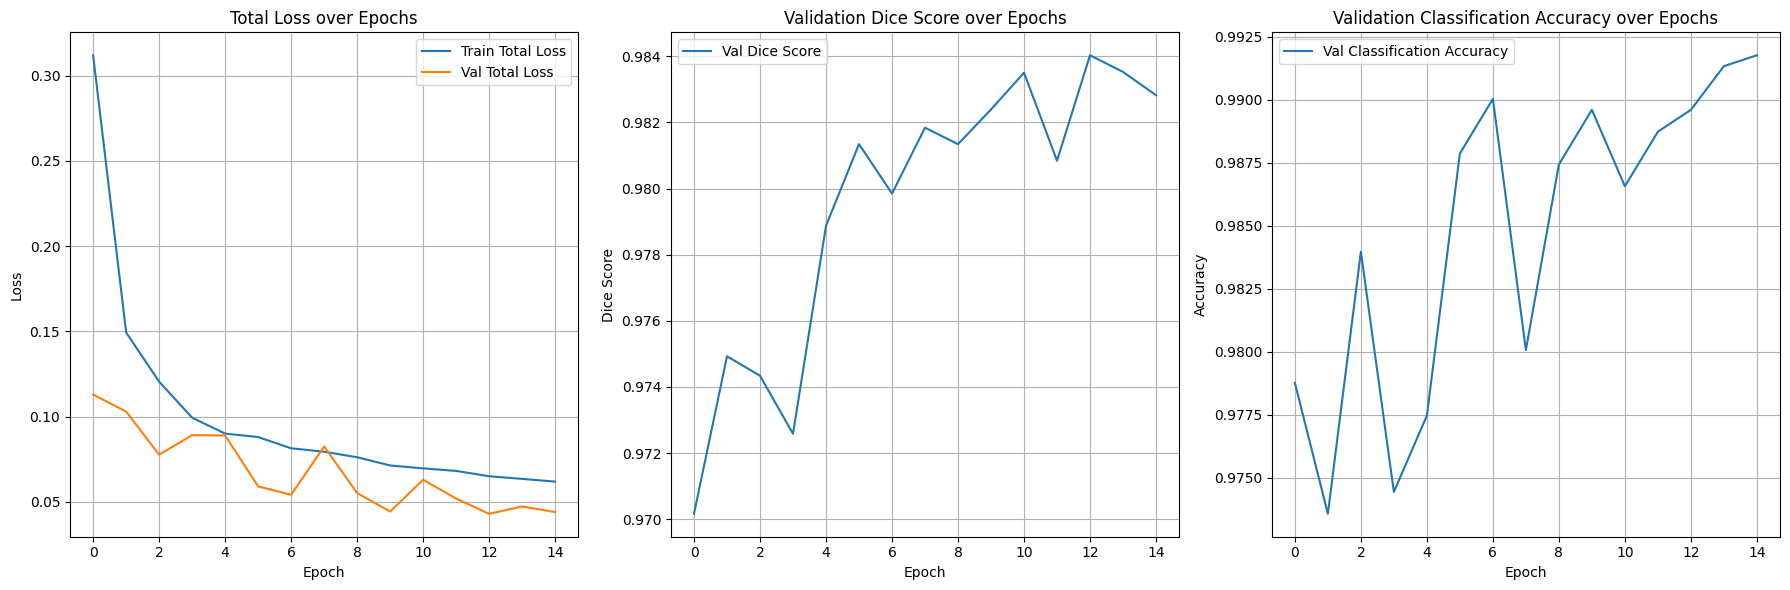

In [10]:
# Import necessary libraries
# PyTorch - Our main deep learning framework (like the engine for neural networks)
import torch
import torch.nn as nn              # Neural network building blocks (layers, activations, etc.)
import torch.nn.functional as F    # Pre-built functions (sigmoid, relu, pooling, etc.)
import torch.optim as optim        # Optimization algorithms (how the model learns)

# Computer vision and image processing
import cv2                         # OpenCV for image manipulation (reading, resizing)
import numpy as np                 # For numerical operations on arrays (images are arrays)
from PIL import Image             # For loading and saving image files (though cv2 is also used)

# Data handling and organization
from torch.utils.data import Dataset, DataLoader  # Dataset organizes data, DataLoader feeds it to model
import torchvision.transforms as transforms       # Image transformations (resize, normalize, etc.) - less used now with Albumentations
import albumentations as A                        # Powerful data augmentation library
from albumentations.pytorch import ToTensorV2     # Specific Albumentations transform to convert to PyTorch tensor

# Visualization and plotting
import matplotlib.pyplot as plt   # For creating plots and visualizing images
import seaborn as sns            # For beautiful statistical plots (less used in this notebook, but good for analysis)

# Additional utilities
import os                        # For file and directory operations (listing files, creating folders)
import random                    # For random number generation (e.g., setting seeds)
from tqdm import tqdm           # For progress bars during training (shows how much time is left)
import time                     # For timing operations (e.g., how long an epoch takes)
from sklearn.model_selection import train_test_split  # For splitting data into train/validation sets


# Set random seeds for reproducible results
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Model and Training Parameters
# These are the same parameters you defined earlier, but gathered here for clarity.
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
NUM_CLASSES_CLASSIFICATION = 2 # Normal (0), Viral Pneumonia (1)

print("🏗️  Creating ECUNet model...")

# Create the ECUNet model
# We pass NUM_CLASSES_CLASSIFICATION for the classification head.
model = ECUNet(n_classes=NUM_CLASSES_CLASSIFICATION)

# Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"🚀 Training on device: {device}")

# Count total parameters and print model statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Model Statistics:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable Parameters: {trainable_params:,}")
print(f"   Model Size: {total_params * 4 / 1024 / 1024:.2f} MB") # Assuming 4 bytes per float parameter

# Test model with dummy data to verify it works
print("\n🧪 Testing model with dummy data...")
# Dummy input for a single-channel image (as your ECUNet expects 1 input channel)
# Change the dummy input to 3 channels to match the dataset
dummy_image = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device) # Batch of 1 RGB image

# Perform a forward pass
with torch.no_grad(): # Don't calculate gradients for this test
    seg_output, cls_output = model(dummy_image) # Model now returns two outputs

print(f"✅ Model test successful!")
print(f"   Input image shape: {dummy_image.shape}")
print(f"   Segmentation output shape: {seg_output.shape}")
print(f"   Segmentation output range: [{seg_output.min():.3f}, {seg_output.max():.3f}]")
print(f"   Classification output shape (logits): {cls_output.shape}") # Logits are raw scores
print(f"   Classification output (example logits): {cls_output.squeeze().tolist()}") # Squeeze to remove batch dim for printing

# --- Training Loop Function ---
def train_model(model, train_loader, val_loader, num_epochs, learning_rate):
    """
    Trains the ECUNet model, handling both segmentation and classification tasks.
    """
    # Define optimizers and schedulers
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    # ReduceLROnPlateau: Reduces learning rate if validation loss doesn't improve
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                    patience=5, verbose=True)

    # Loss functions
    seg_criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5) # Your segmentation loss
    cls_criterion = nn.CrossEntropyLoss() # Classification loss

    # Lists to store training history
    train_seg_losses = []
    train_cls_losses = []
    train_total_losses = []
    val_seg_losses = []
    val_cls_losses = []
    val_total_losses = []
    val_dice_scores = [] # For segmentation metric
    val_cls_accuracies = [] # For classification metric

    best_val_loss = float('inf') # To save the best model

    print("\n🎯 Starting training...")
    print("=" * 60)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # --- Training Phase ---
        model.train() # Set model to training mode
        running_seg_loss = 0.0
        running_cls_loss = 0.0
        running_total_loss = 0.0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, batch_data in enumerate(train_progress):
            images = batch_data['image'].to(device)
            masks = batch_data['mask'].to(device)
            labels = batch_data['label'].to(device)

            optimizer.zero_grad() # Clear gradients

            seg_preds, cls_preds = model(images) # Get both outputs from the model

            # Calculate losses
            # Add unsqueeze(1) to masks to match seg_preds shape [Batch, 1, H, W]
            seg_loss = seg_criterion(seg_preds, masks.unsqueeze(1))
            cls_loss = cls_criterion(cls_preds, labels)

            # Combine losses (you can adjust weights here if one task is more important)
            # For simplicity, let's sum them directly for now.
            total_loss = seg_loss + cls_loss

            total_loss.backward() # Backpropagation
            optimizer.step()      # Update weights

            running_seg_loss += seg_loss.item()
            running_cls_loss += cls_loss.item()
            running_total_loss += total_loss.item()

            train_progress.set_postfix({
                'SegLoss': f'{seg_loss.item():.4f}',
                'ClsLoss': f'{cls_loss.item():.4f}',
                'TotalLoss': f'{total_loss.item():.4f}'
            })

        avg_train_seg_loss = running_seg_loss / len(train_loader)
        avg_train_cls_loss = running_cls_loss / len(train_loader)
        avg_train_total_loss = running_total_loss / len(train_loader)
        train_seg_losses.append(avg_train_seg_loss)
        train_cls_losses.append(avg_train_cls_loss)
        train_total_losses.append(avg_train_total_loss)

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode
        val_running_seg_loss = 0.0
        val_running_cls_loss = 0.0
        val_running_total_loss = 0.0
        val_running_dice = 0.0
        val_correct_cls = 0
        val_total_cls = 0

        with torch.no_grad(): # No gradient calculation needed for validation
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch_idx, batch_data in enumerate(val_progress):
                images = batch_data['image'].to(device)
                masks = batch_data['mask'].to(device)
                labels = batch_data['label'].to(device)

                seg_preds, cls_preds = model(images)

                # Calculate losses
                # Add unsqueeze(1) to masks to match seg_preds shape [Batch, 1, H, W]
                seg_loss = seg_criterion(seg_preds, masks.unsqueeze(1))
                cls_loss = cls_criterion(cls_preds, labels)
                total_loss = seg_loss + cls_loss

                val_running_seg_loss += seg_loss.item()
                val_running_cls_loss += cls_loss.item()
                val_running_total_loss += total_loss.item()

                # Calculate Dice for segmentation
                # Add unsqueeze(1) to masks for dice calculation as well
                val_running_dice += dice_coefficient_metric(seg_preds, masks.unsqueeze(1)).item()

                # Calculate Classification Accuracy
                _, predicted_labels = torch.max(cls_preds, 1) # Get the class with highest score
                val_total_cls += labels.size(0) # Total samples in batch
                val_correct_cls += (predicted_labels == labels).sum().item() # Correct predictions

                val_progress.set_postfix({
                    'SegLoss': f'{seg_loss.item():.4f}',
                    'ClsLoss': f'{cls_loss.item():.4f}',
                    'TotalLoss': f'{total_loss.item():.4f}'
                })

        avg_val_seg_loss = val_running_seg_loss / len(val_loader)
        avg_val_cls_loss = val_running_cls_loss / len(val_loader)
        avg_val_total_loss = val_running_total_loss / len(val_loader)
        avg_val_dice = val_running_dice / len(val_loader)
        avg_val_cls_accuracy = val_correct_cls / val_total_cls

        val_seg_losses.append(avg_val_seg_loss)
        val_cls_losses.append(avg_val_cls_loss)
        val_total_losses.append(avg_val_total_loss)
        val_dice_scores.append(avg_val_dice)
        val_cls_accuracies.append(avg_val_cls_accuracy)

        # Update learning rate based on total validation loss
        scheduler.step(avg_val_total_loss)

        epoch_duration = time.time() - epoch_start_time

        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  📈 Train Seg Loss: {avg_train_seg_loss:.4f} | Train Cls Loss: {avg_train_cls_loss:.4f} | Train Total Loss: {avg_train_total_loss:.4f}")
        print(f"  📊 Val Seg Loss: {avg_val_seg_loss:.4f} | Val Cls Loss: {avg_val_cls_loss:.4f} | Val Total Loss: {avg_val_total_loss:.4f}")
        print(f"  🎲 Val Dice Score: {avg_val_dice:.4f}")
        print(f"  🎯 Val Cls Accuracy: {avg_val_cls_accuracy:.4f}")
        print(f"  ⏱️  Duration: {epoch_duration:.2f} seconds")
        print(f"  Current LR: {optimizer.param_groups[0]['lr']:.2e}")

        # Save best model based on total validation loss
        if avg_val_total_loss < best_val_loss:
            best_val_loss = avg_val_total_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_total_loss': avg_train_total_loss,
                'val_total_loss': avg_val_total_loss,
                'val_dice': avg_val_dice,
                'val_cls_accuracy': avg_val_cls_accuracy,
            }, 'best_ecunet_combined_model.pth')
            print(f"  💾 New best model saved! (Val Total Loss: {best_val_loss:.4f})")

        print("-" * 60)

    print("🎉 Training completed!")

    # Plotting training history
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(train_total_losses, label='Train Total Loss')
    plt.plot(val_total_losses, label='Val Total Loss')
    plt.title('Total Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(val_dice_scores, label='Val Dice Score')
    plt.title('Validation Dice Score over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(val_cls_accuracies, label='Val Classification Accuracy')
    plt.title('Validation Classification Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return {
        'train_seg_losses': train_seg_losses,
        'train_cls_losses': train_cls_losses,
        'train_total_losses': train_total_losses,
        'val_seg_losses': val_seg_losses,
        'val_cls_losses': val_cls_losses,
        'val_total_losses': val_total_losses,
        'val_dice_scores': val_dice_scores,
        'val_cls_accuracies': val_cls_accuracies
    }

# Start the training process!
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)

Loaded best model from best_ecunet_combined_model.pth (Epoch 13, Val Loss: 0.0430)

Making predictions and visualizing 5 samples...


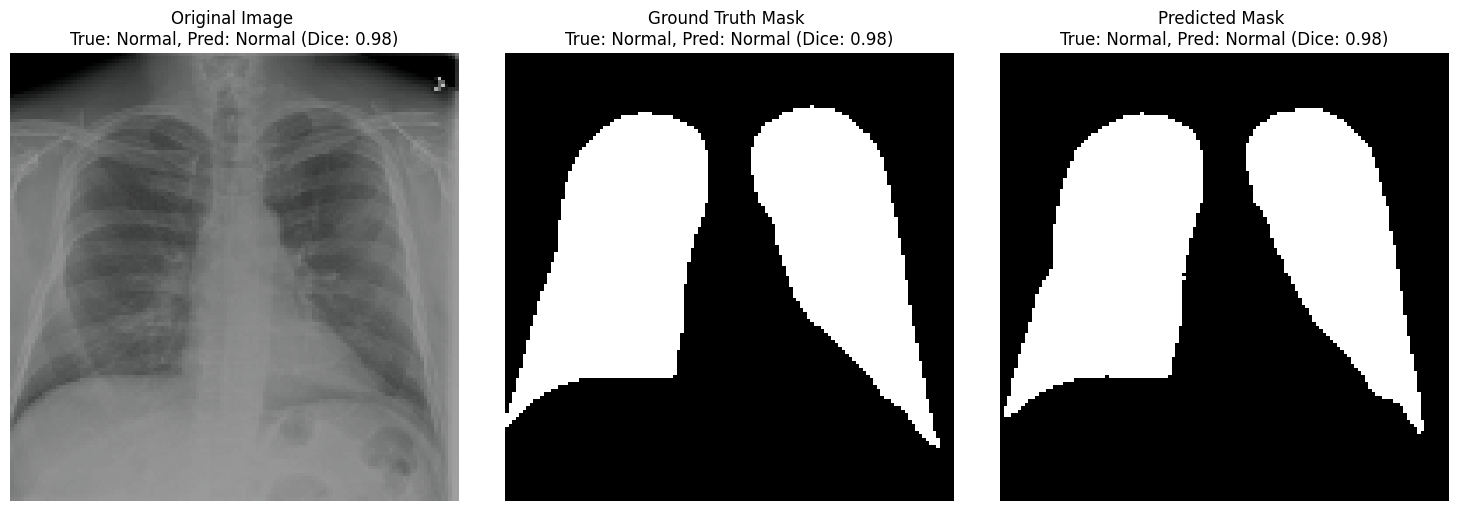

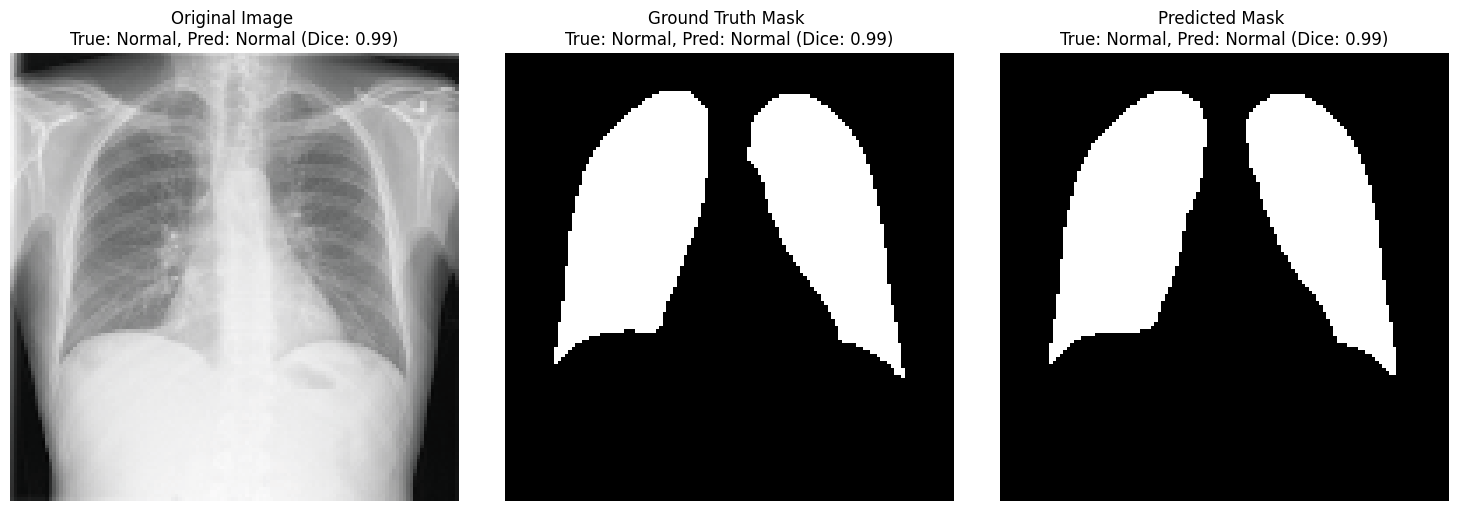

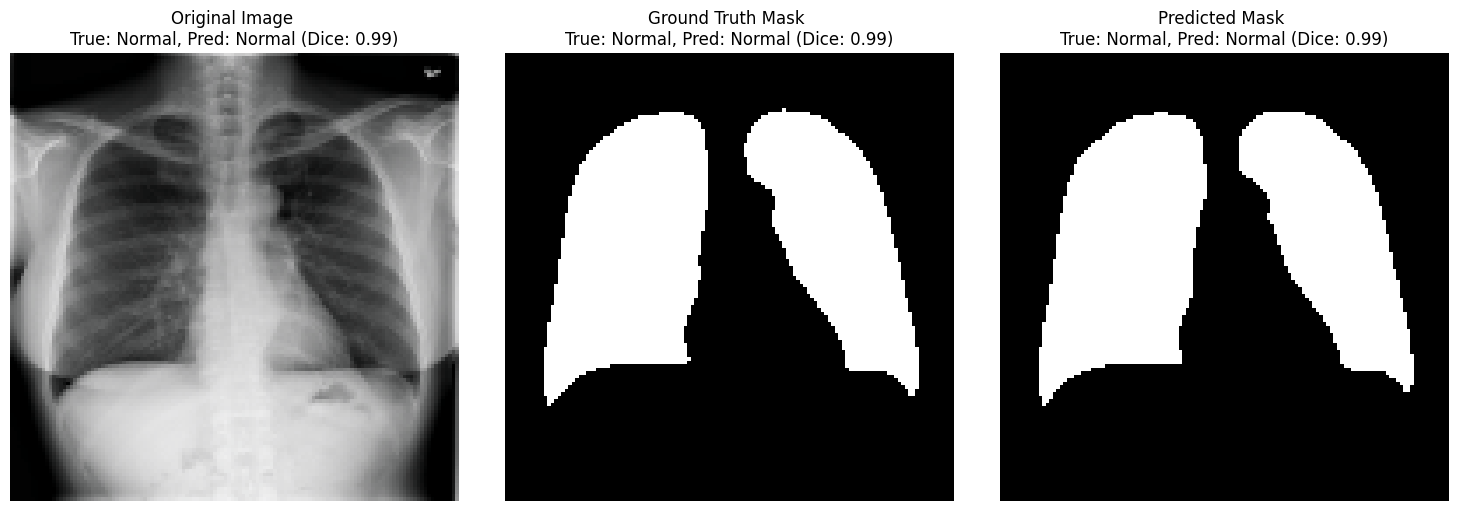

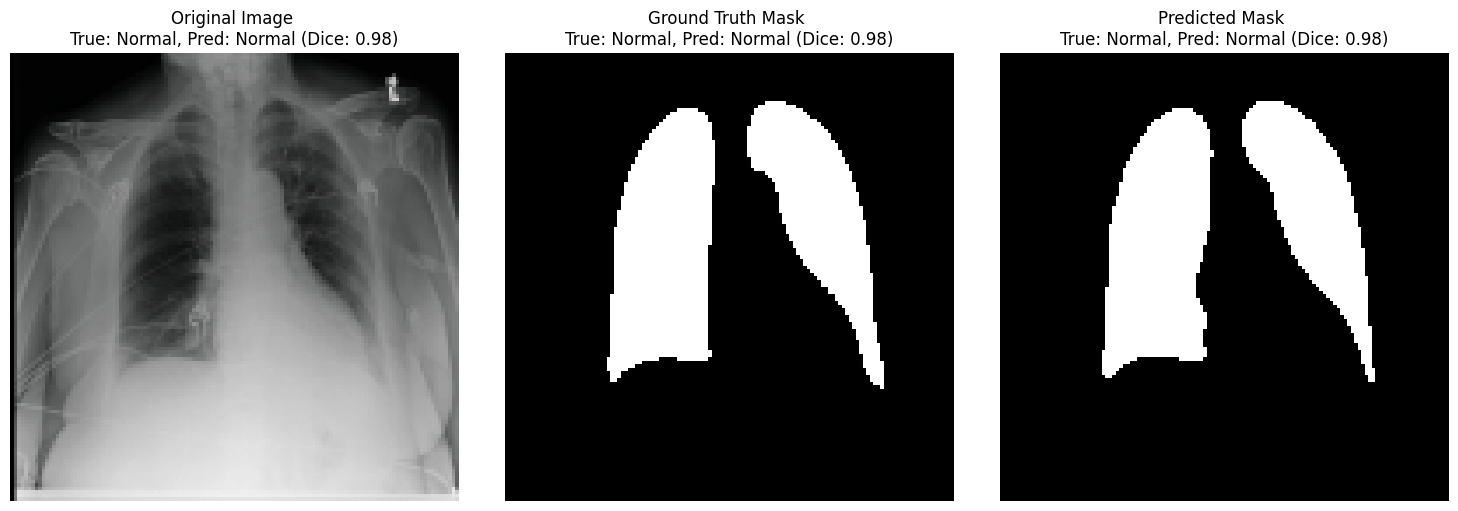

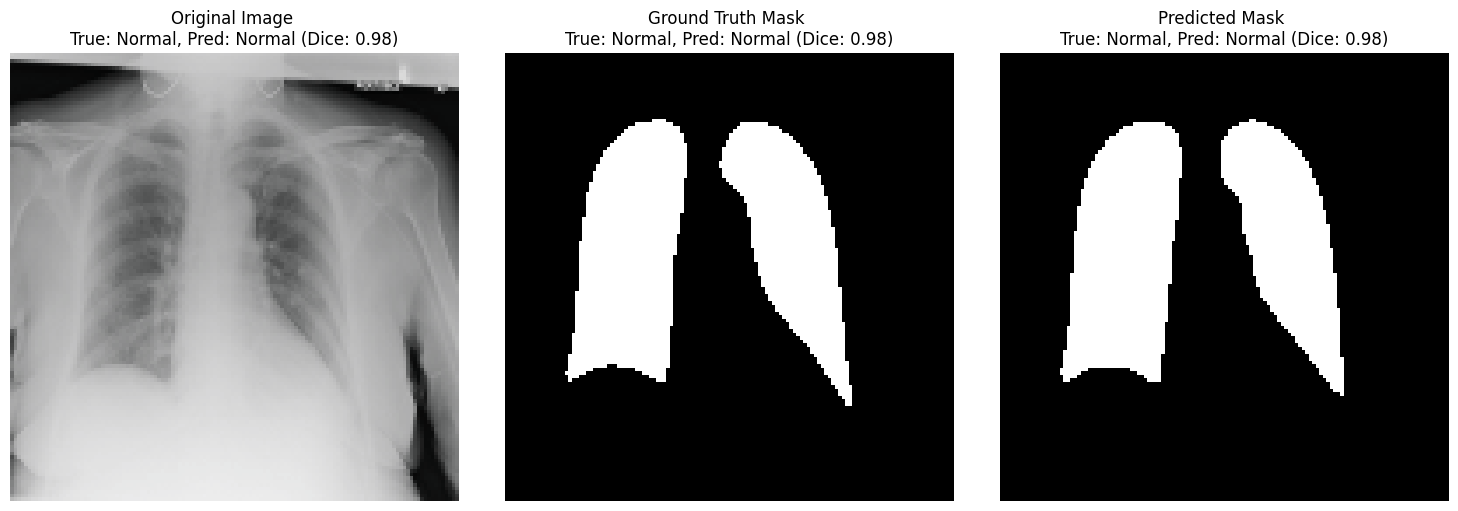

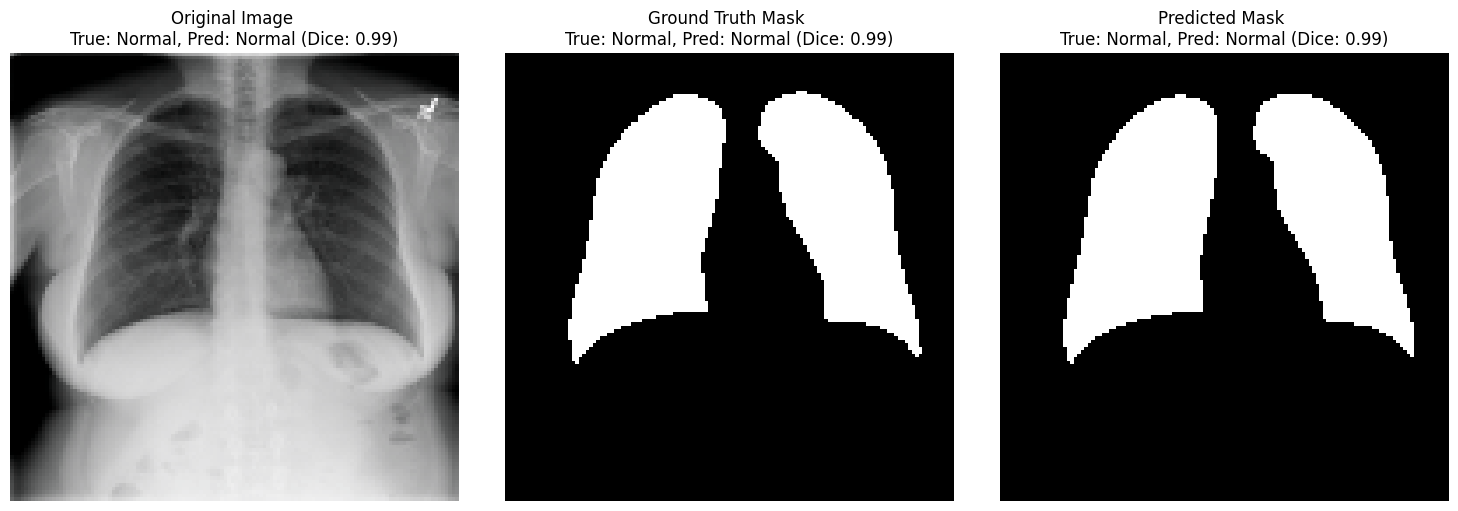

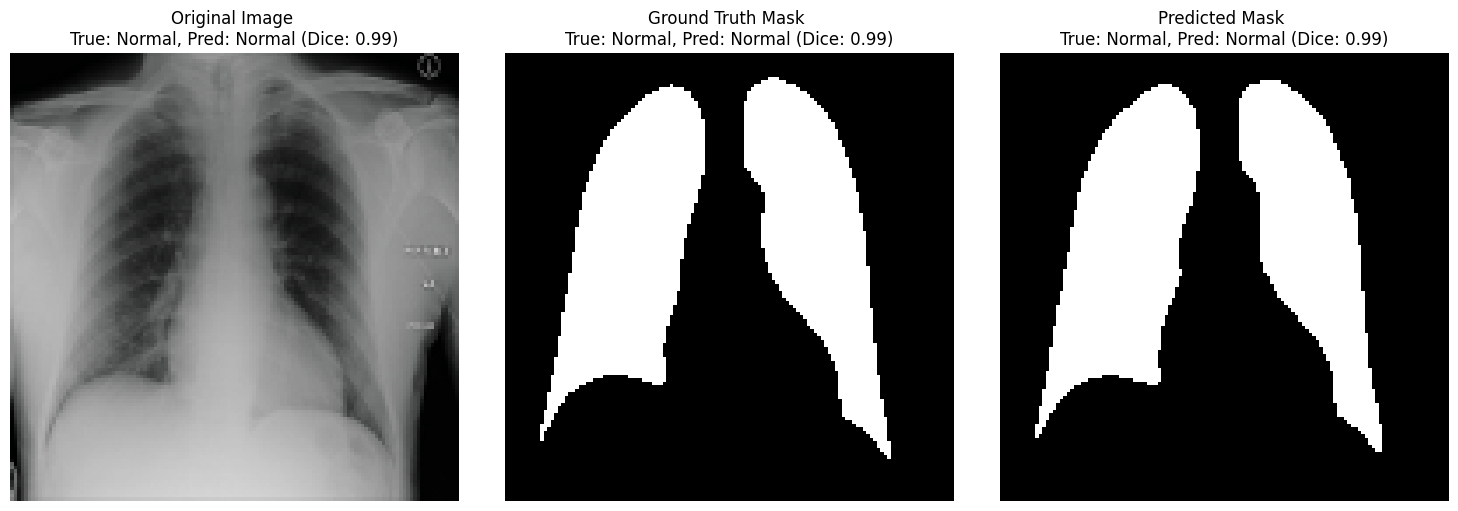

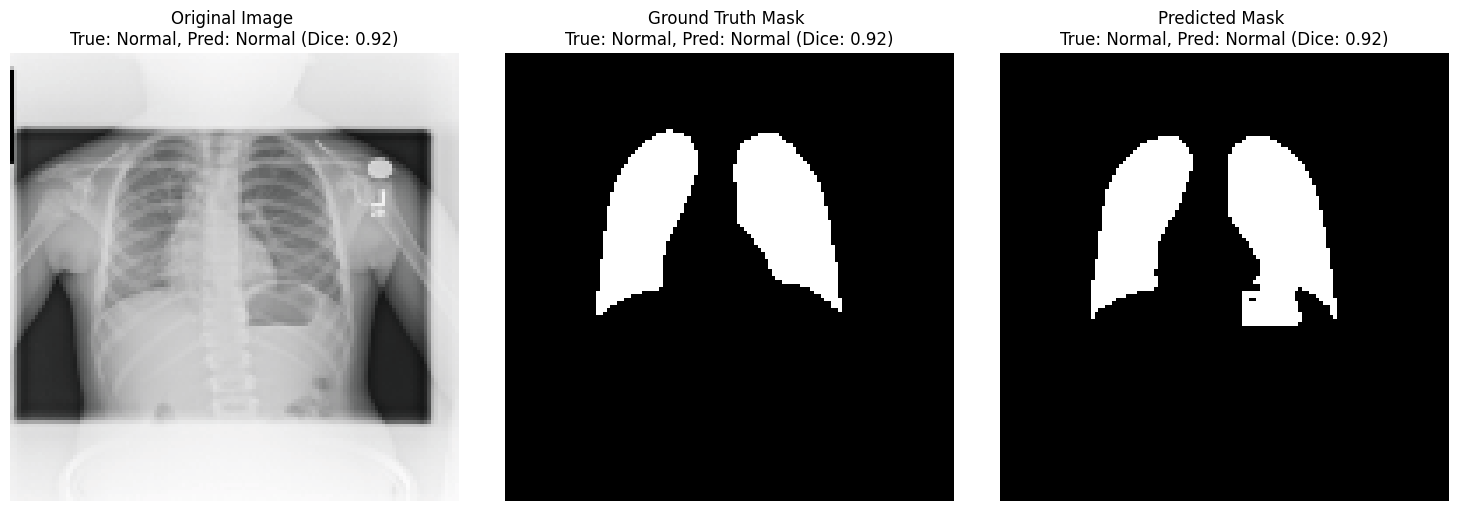

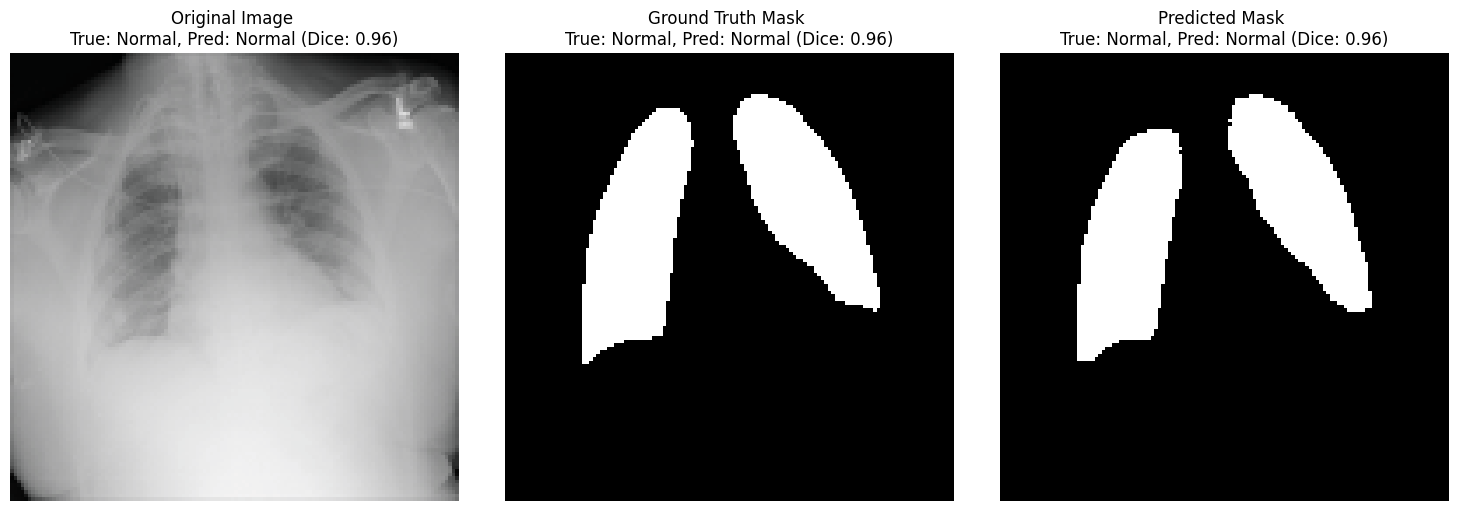

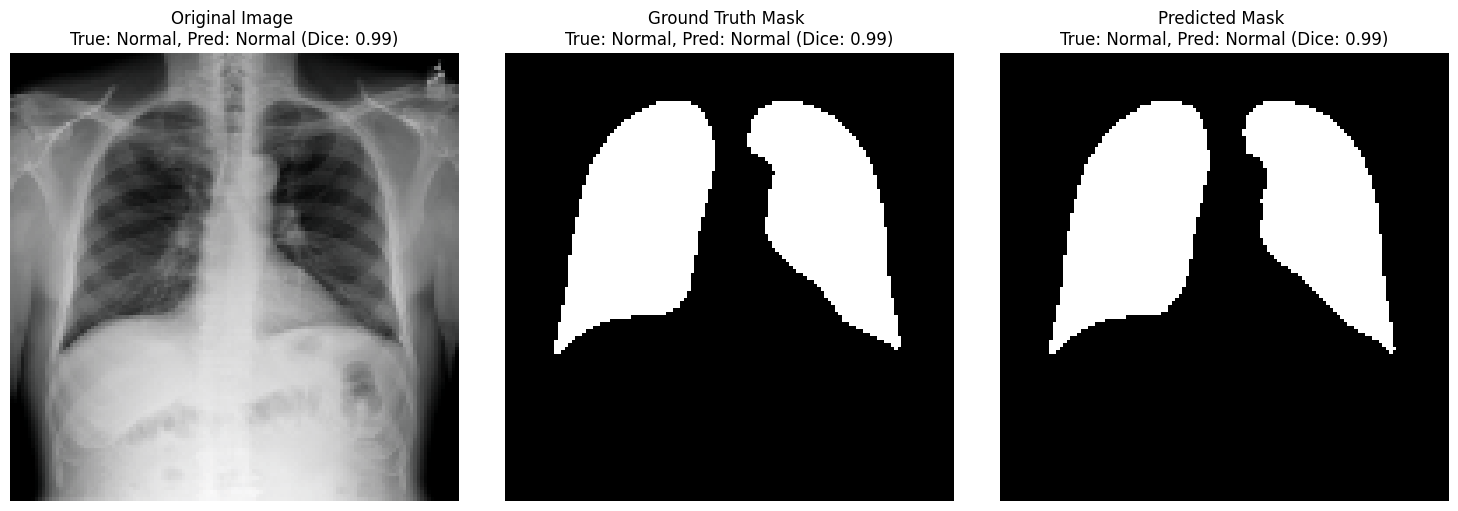

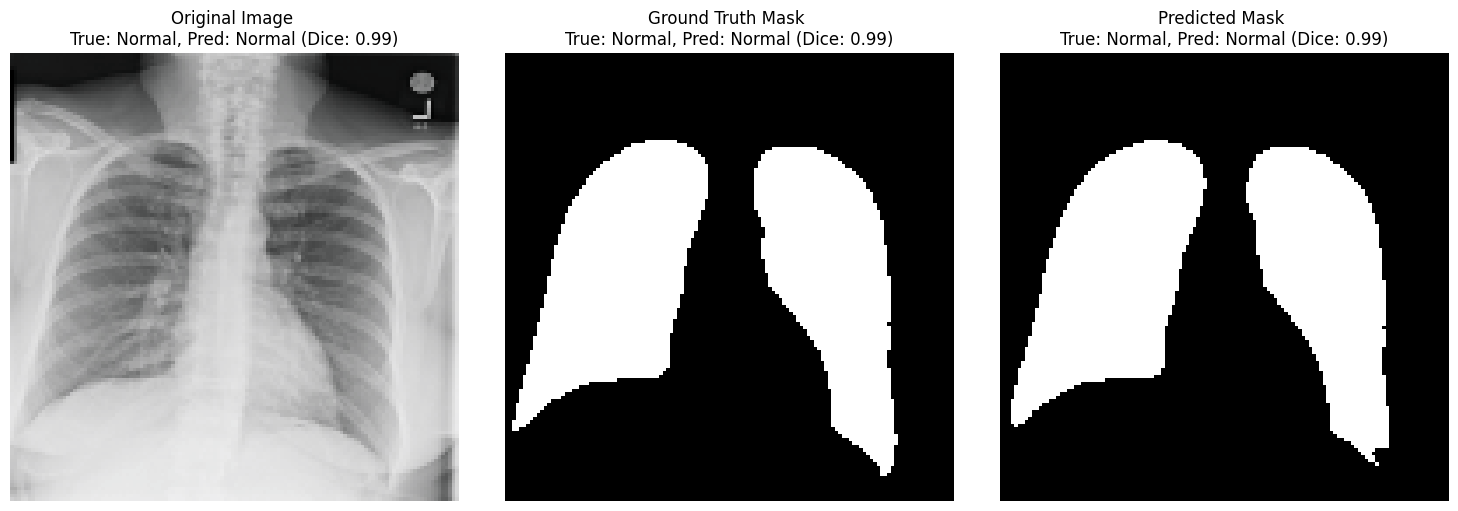

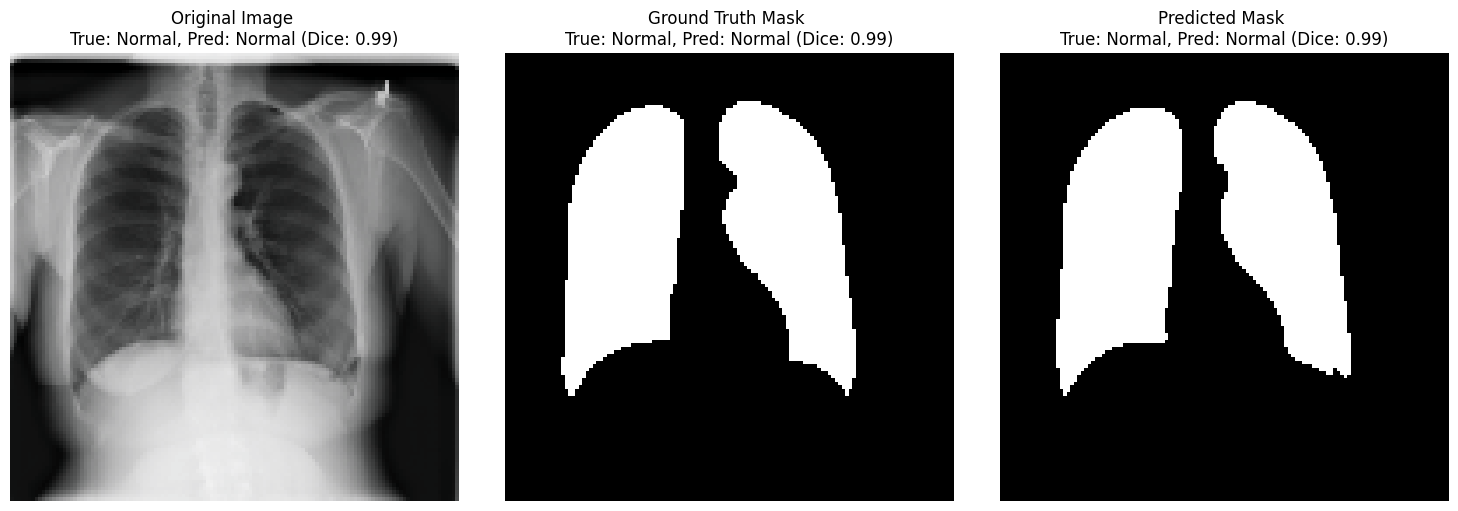

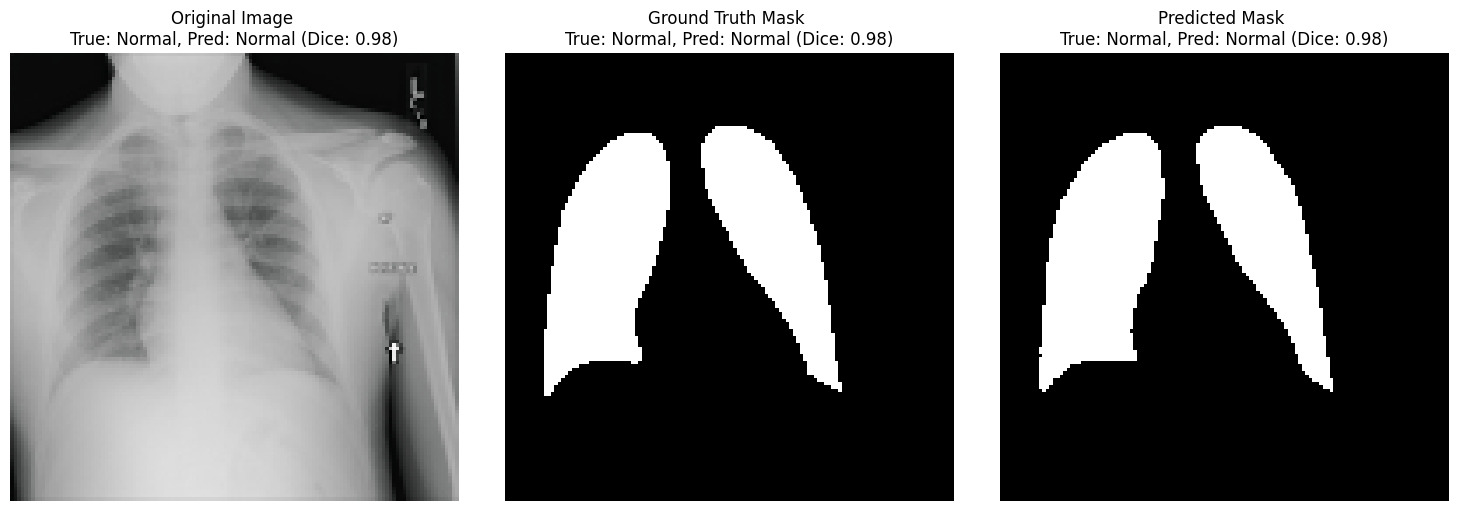

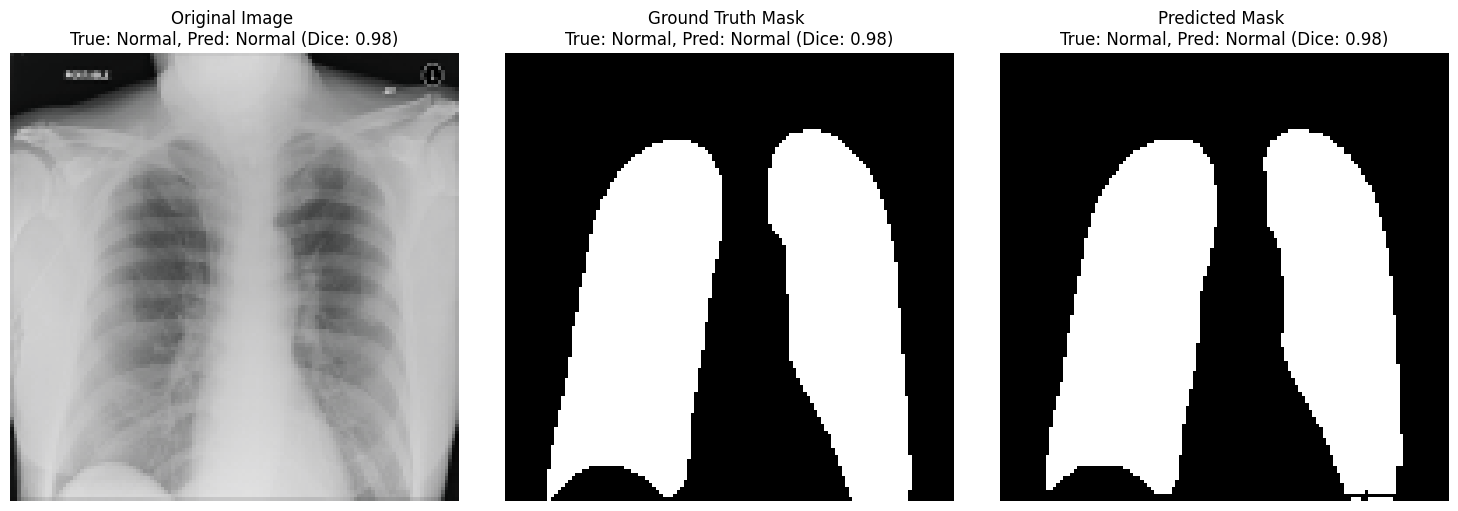

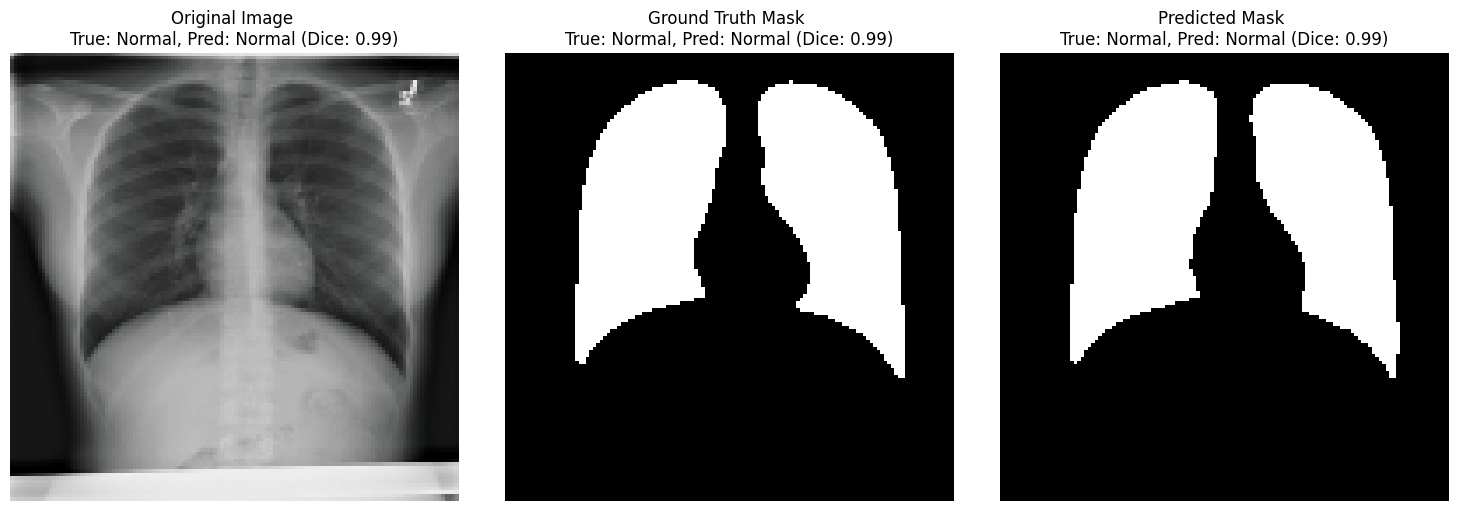

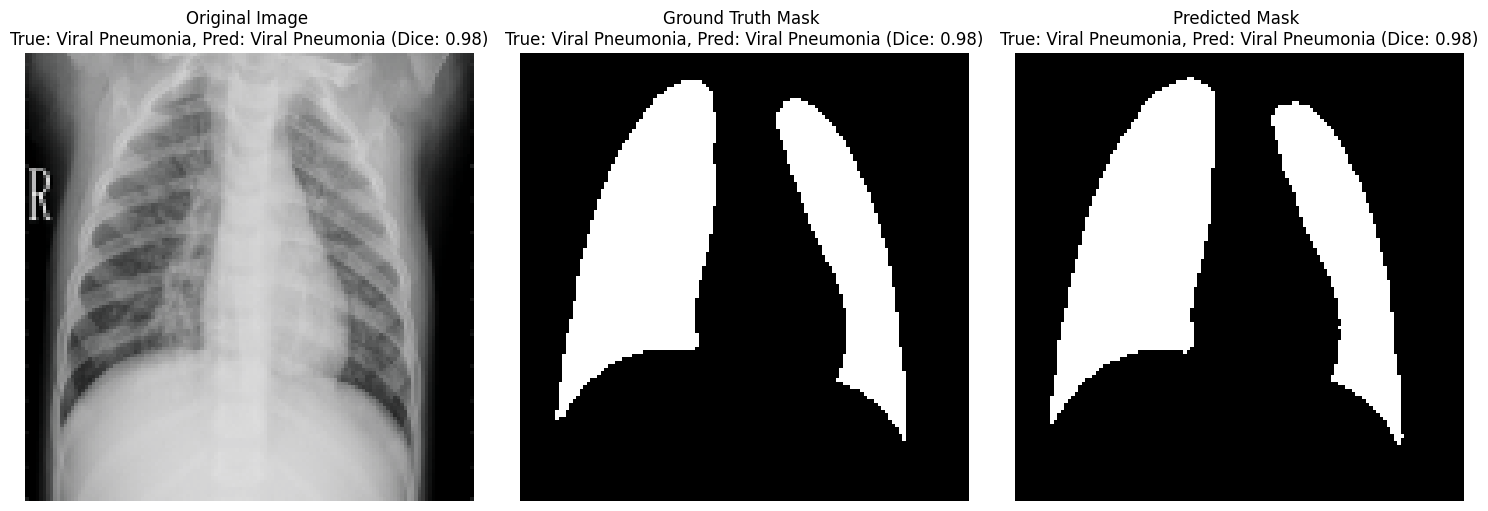

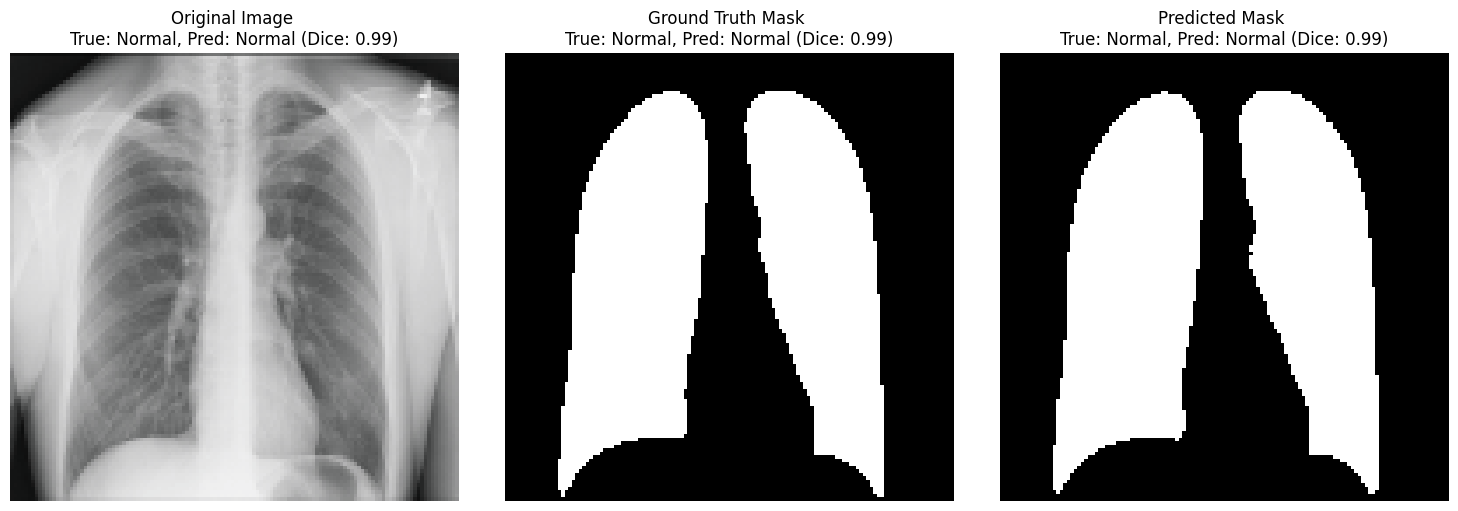

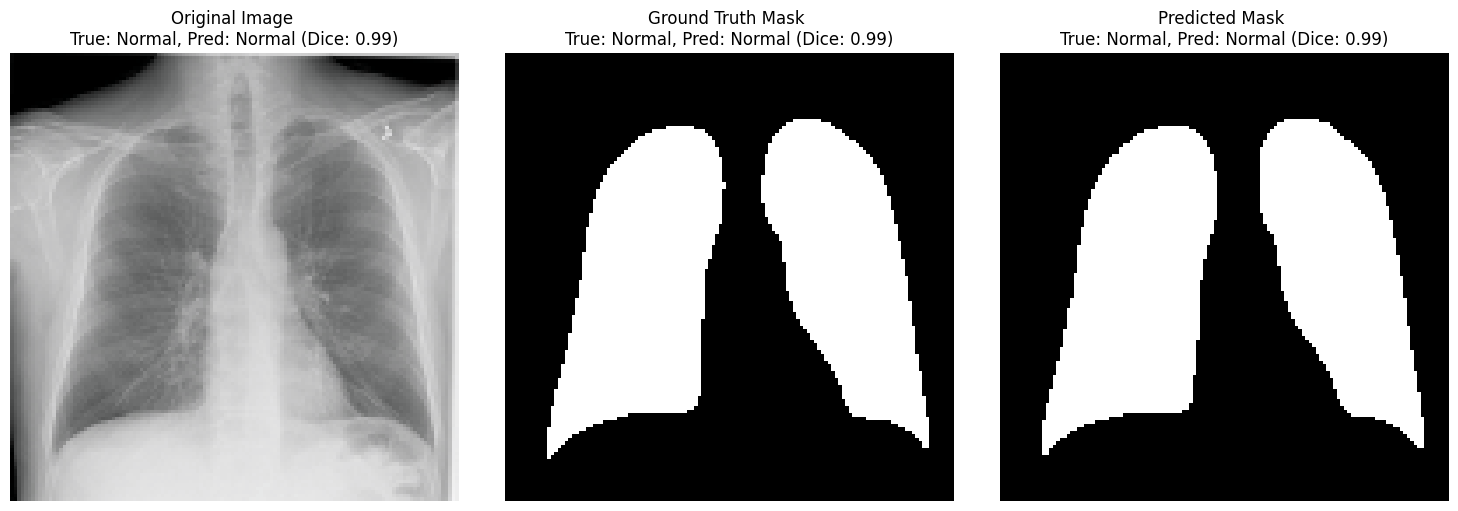

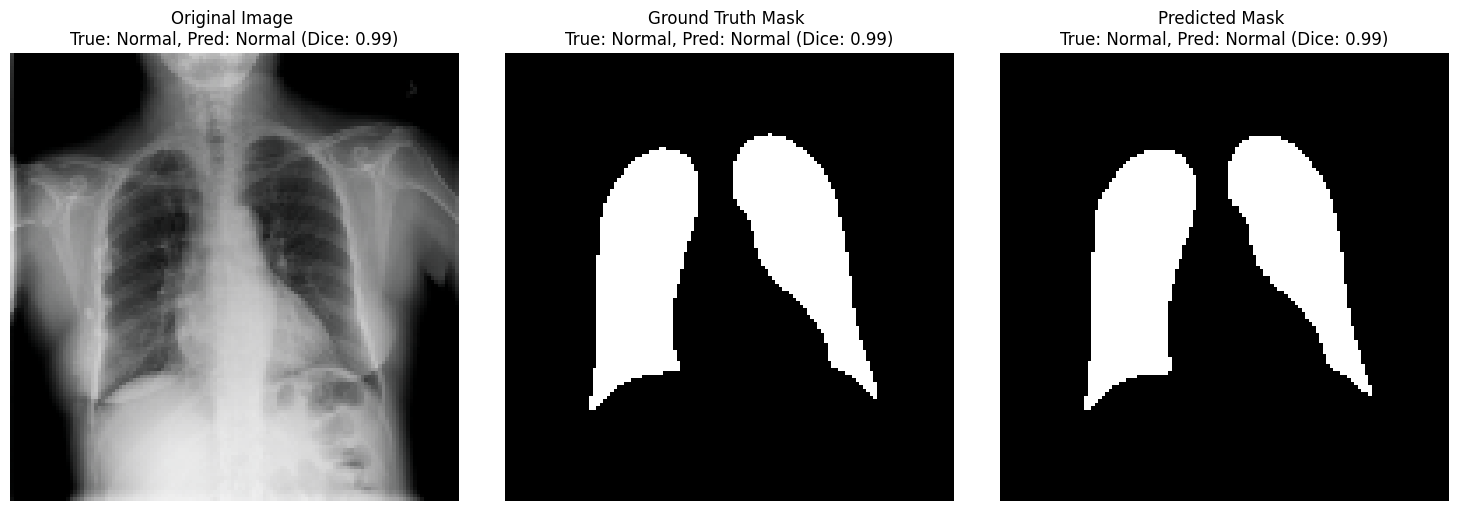

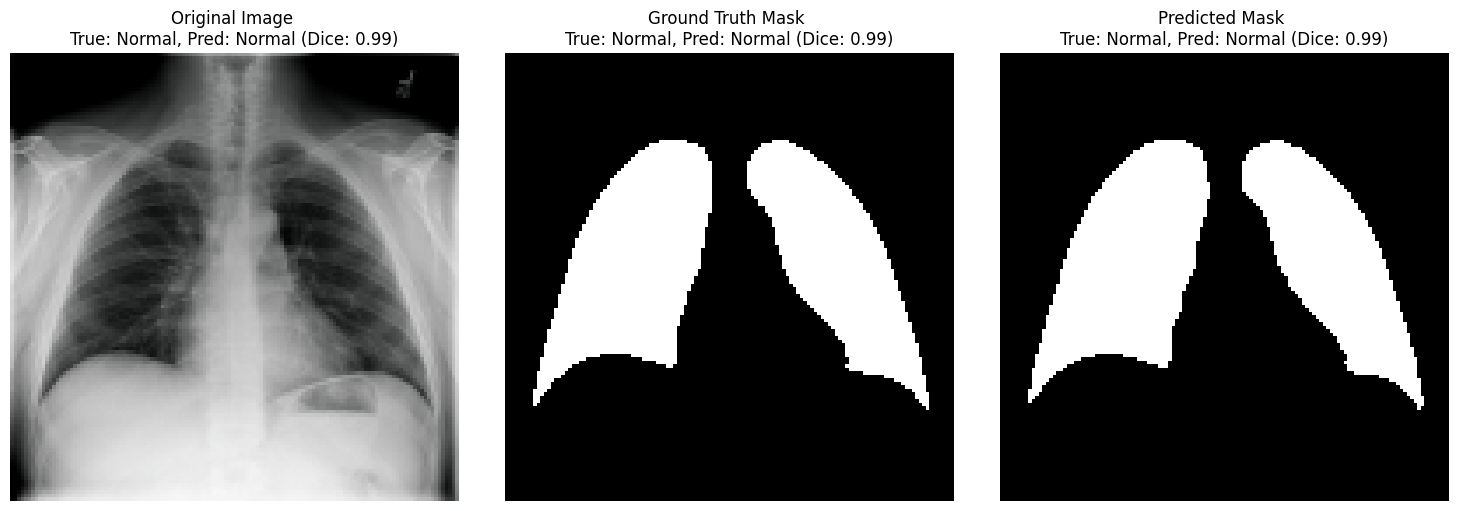

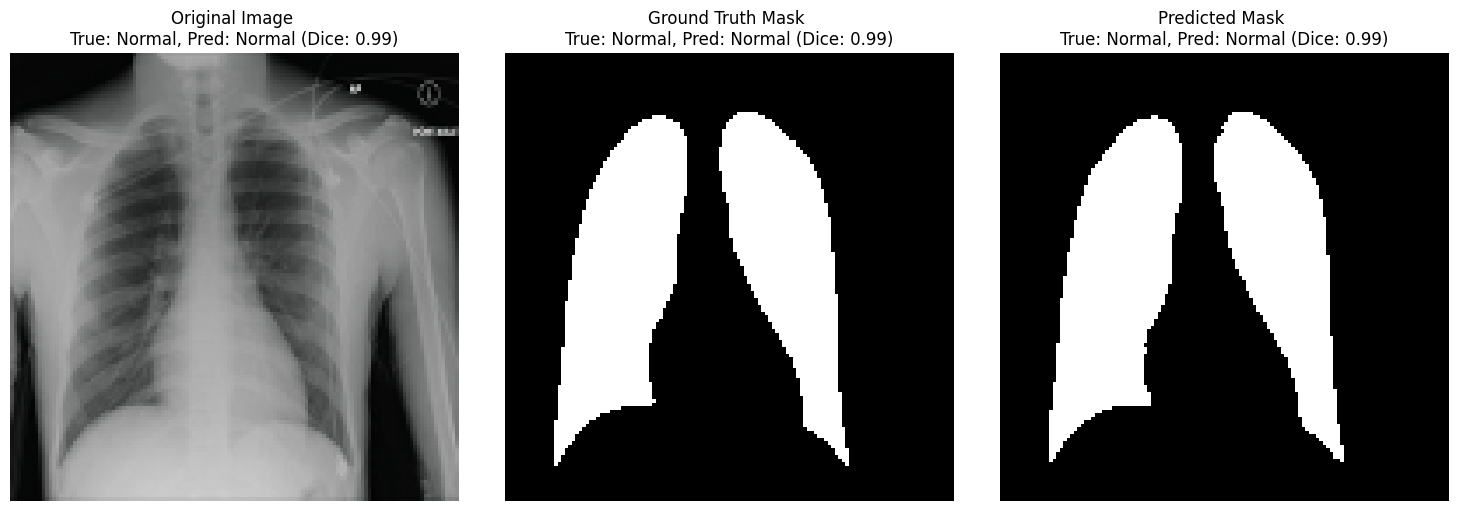

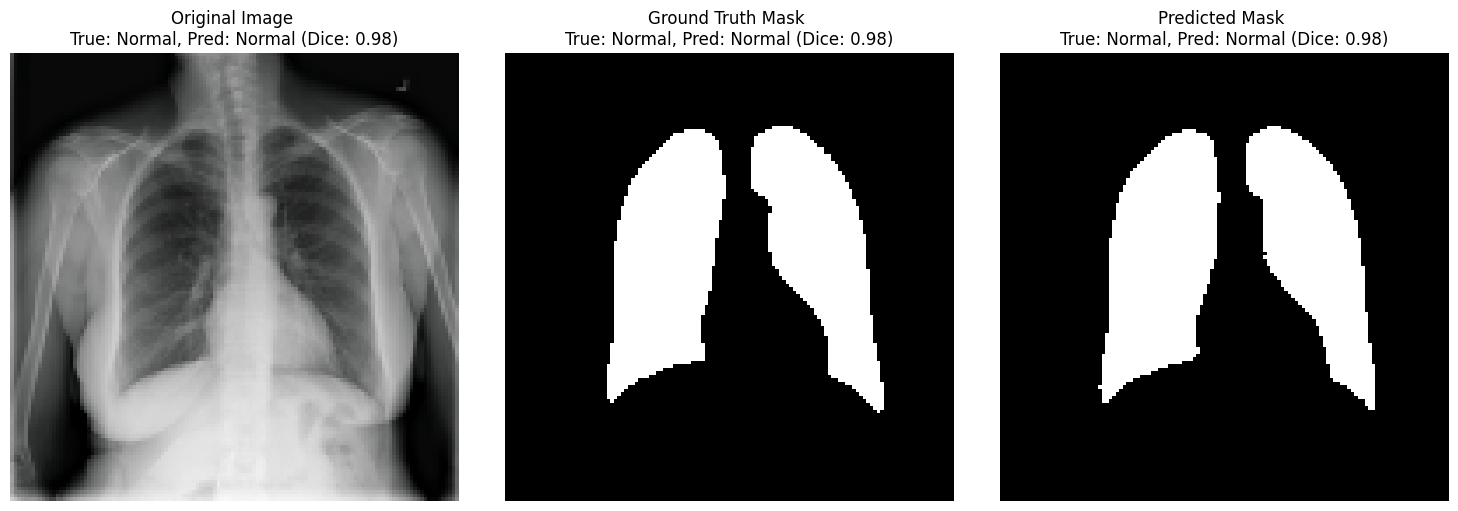

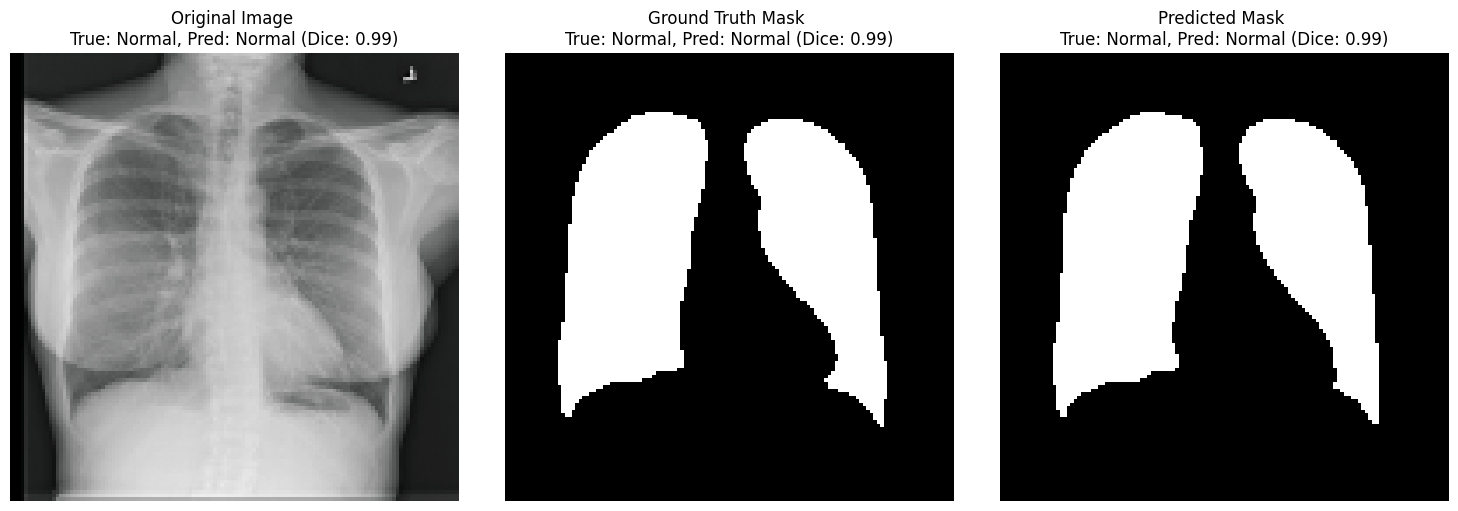

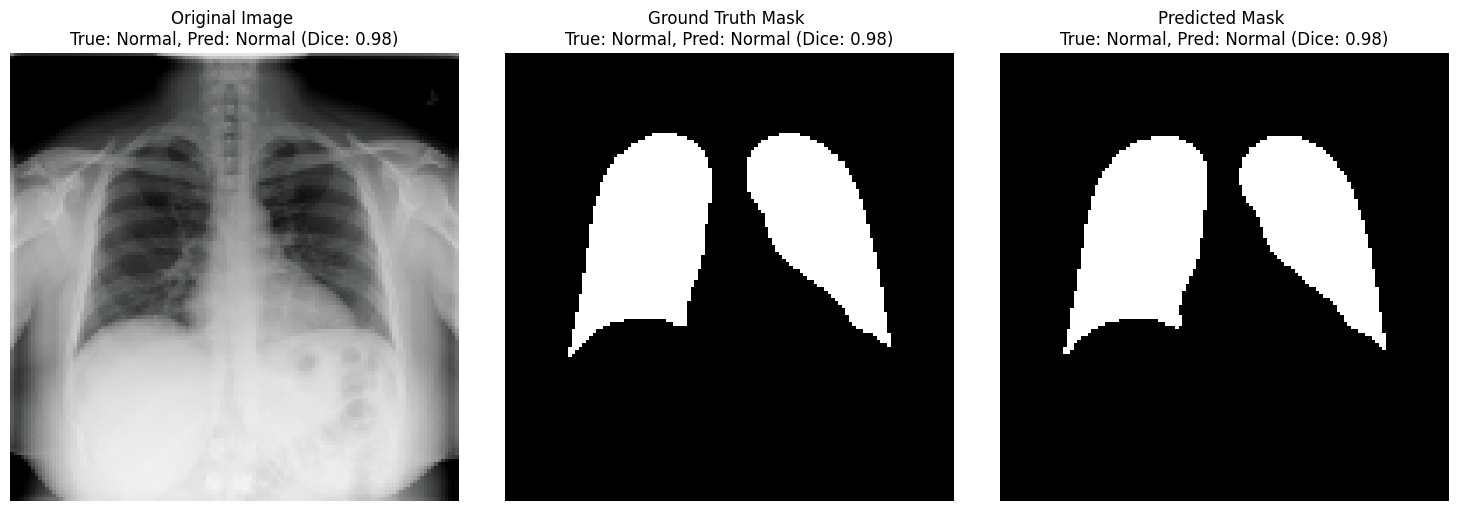

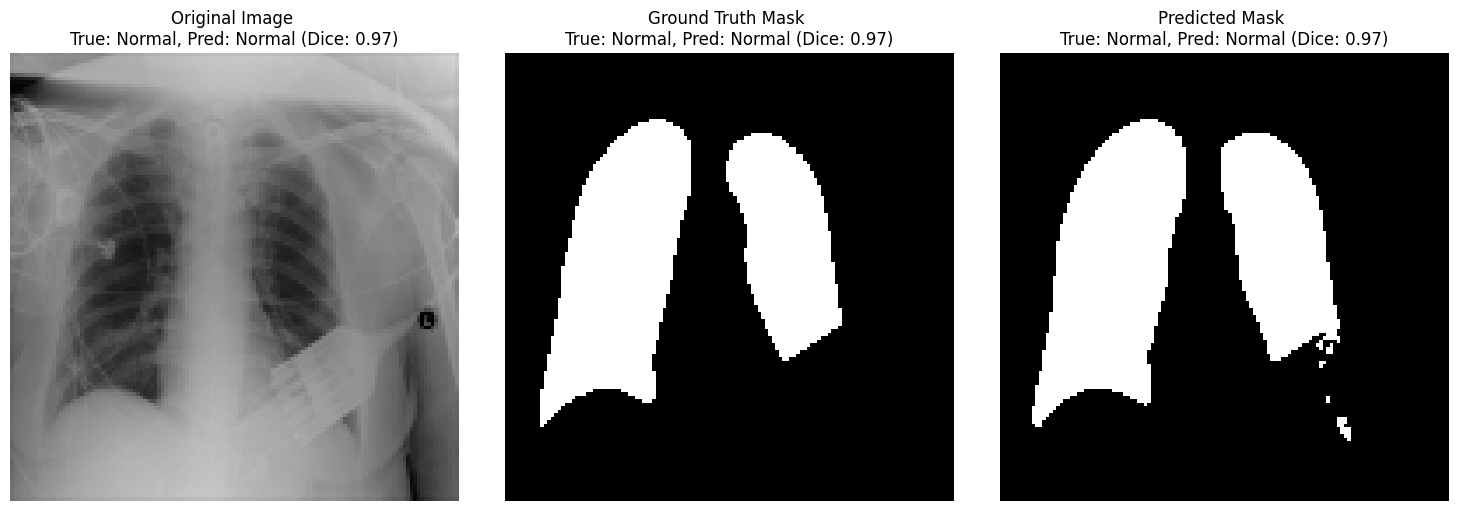

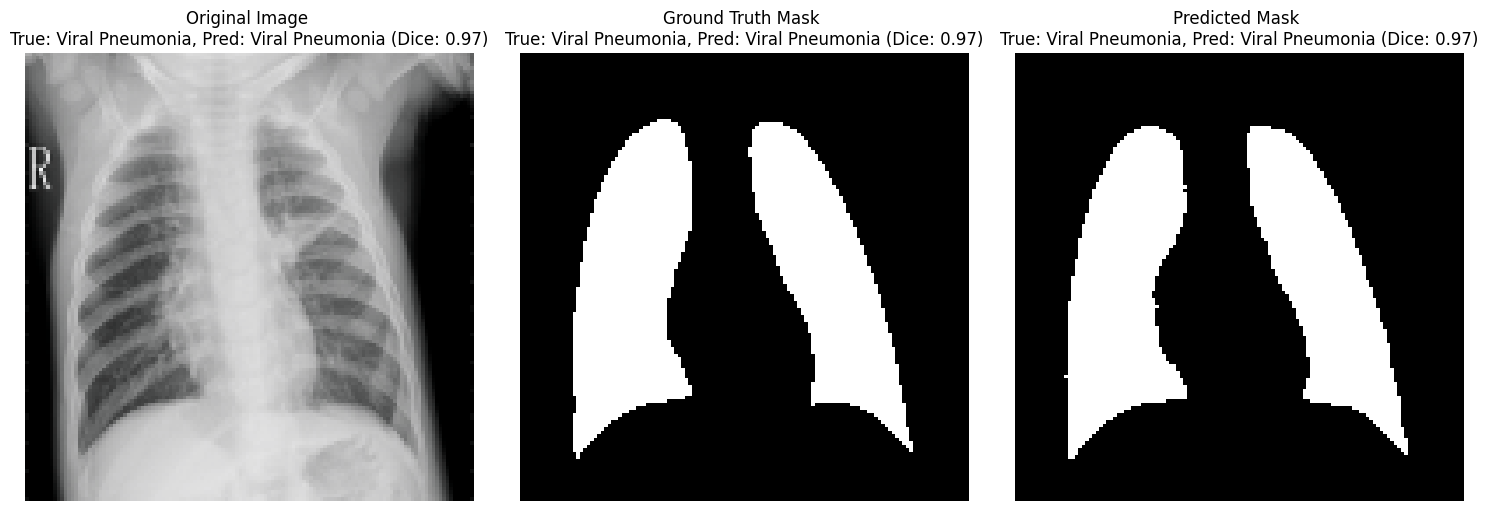

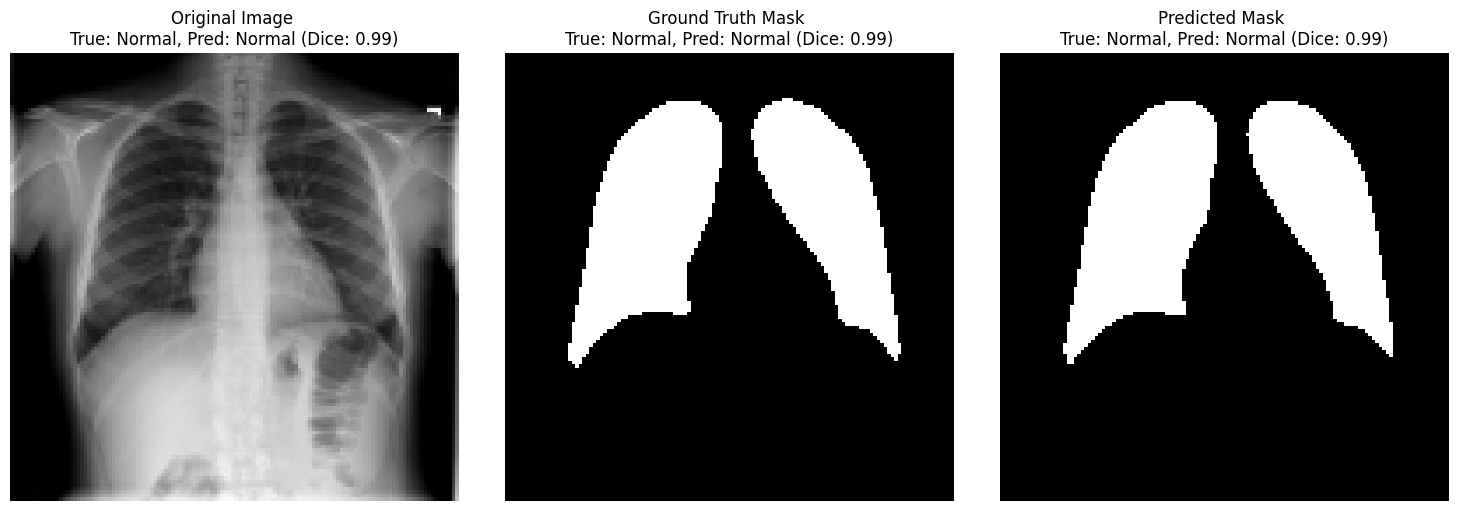

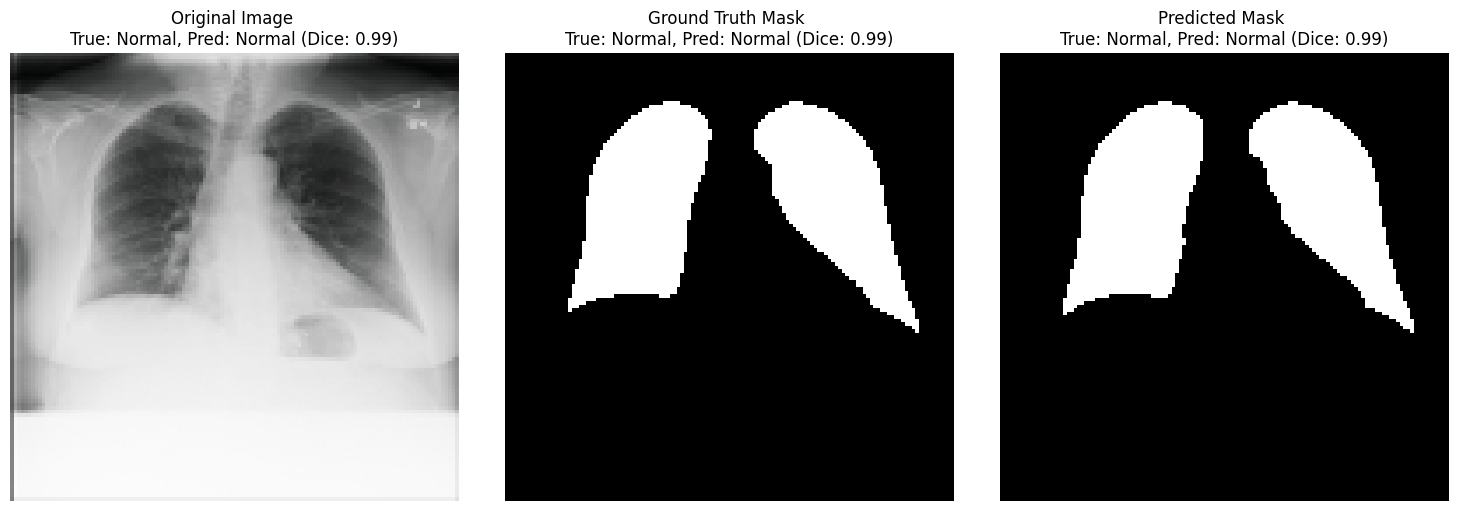

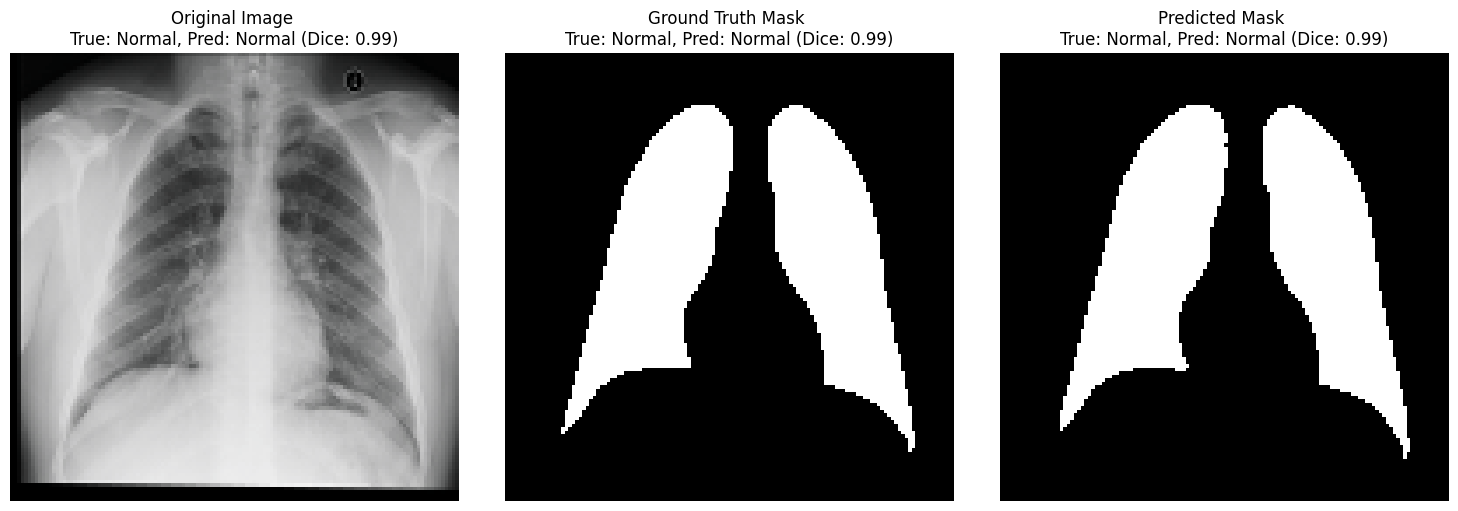

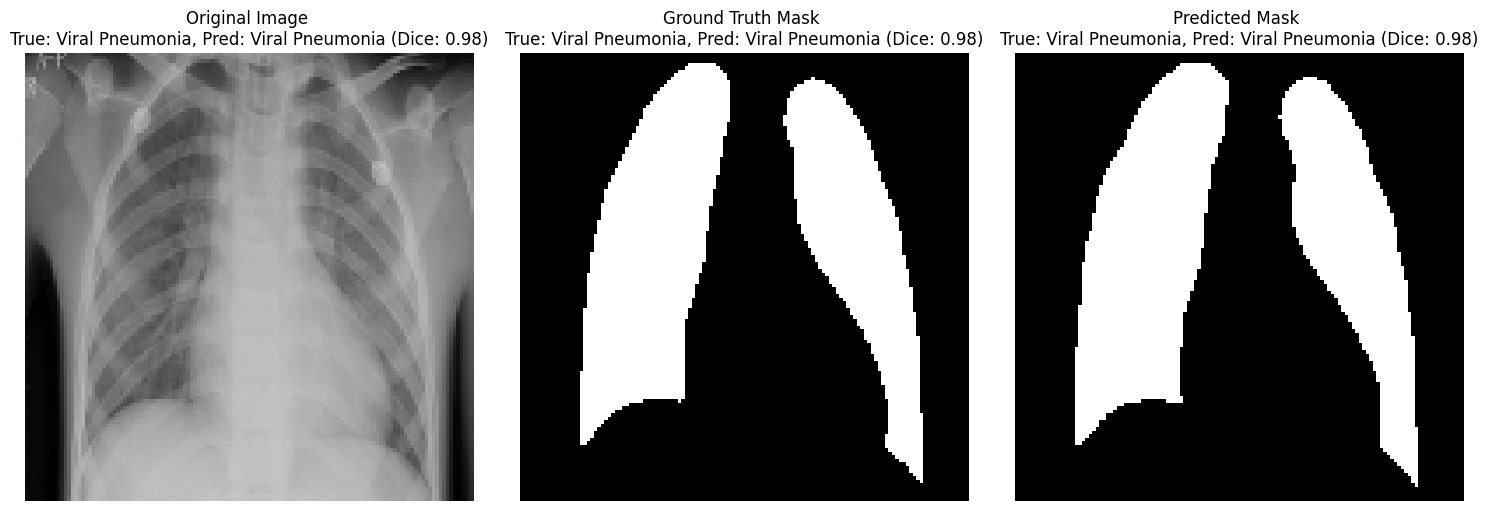

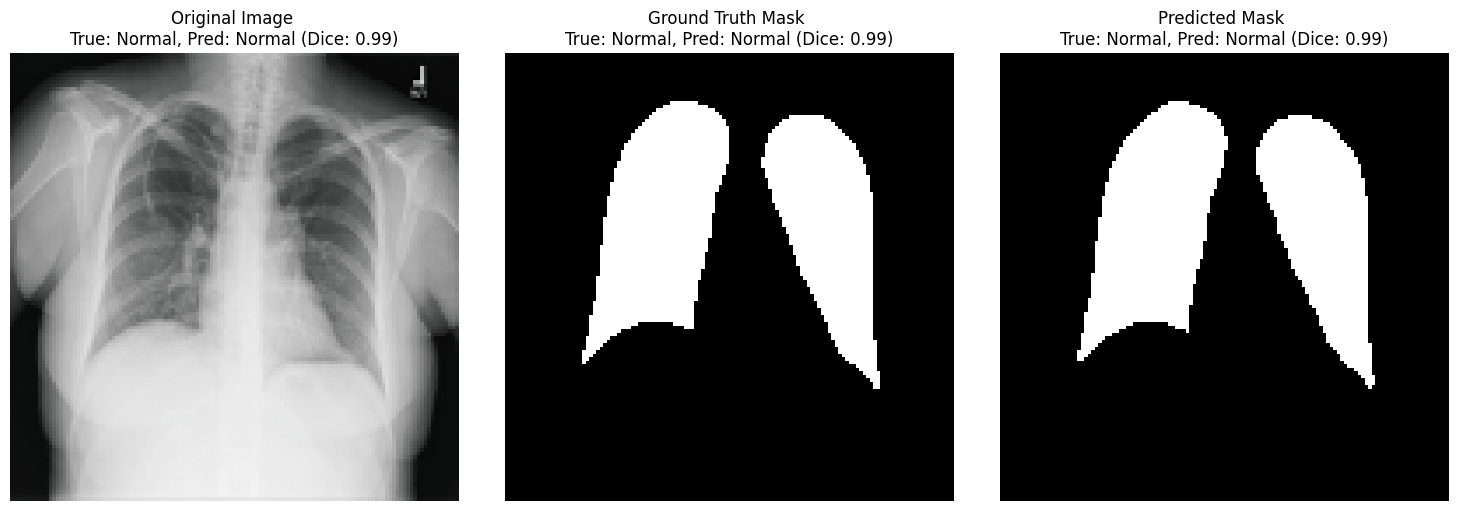

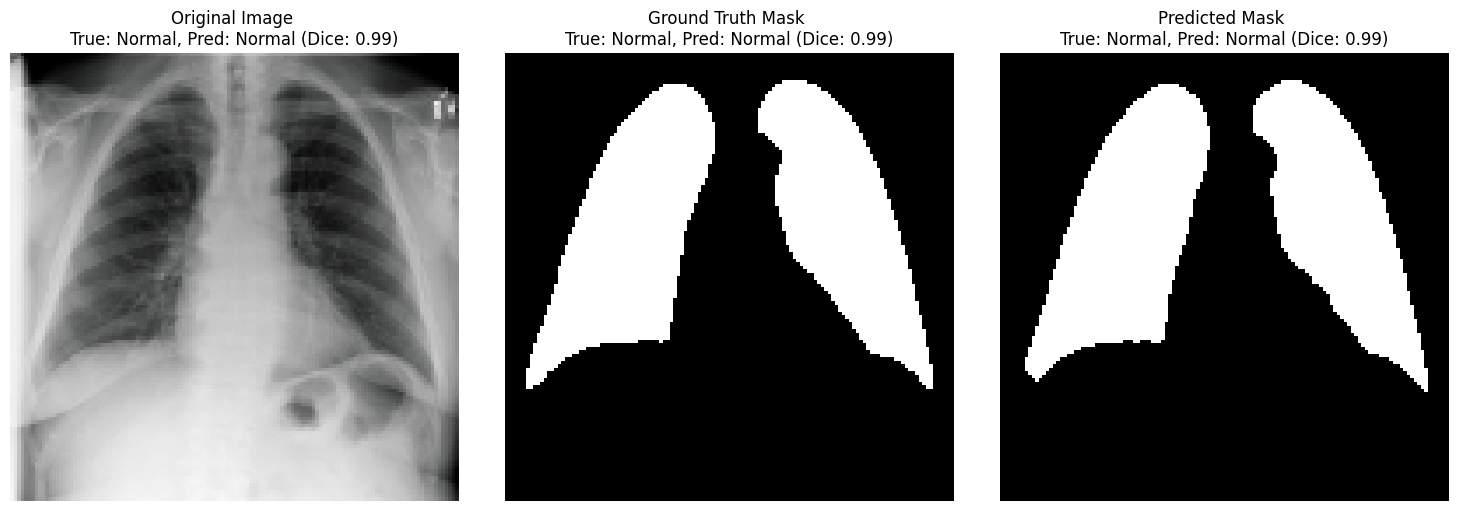

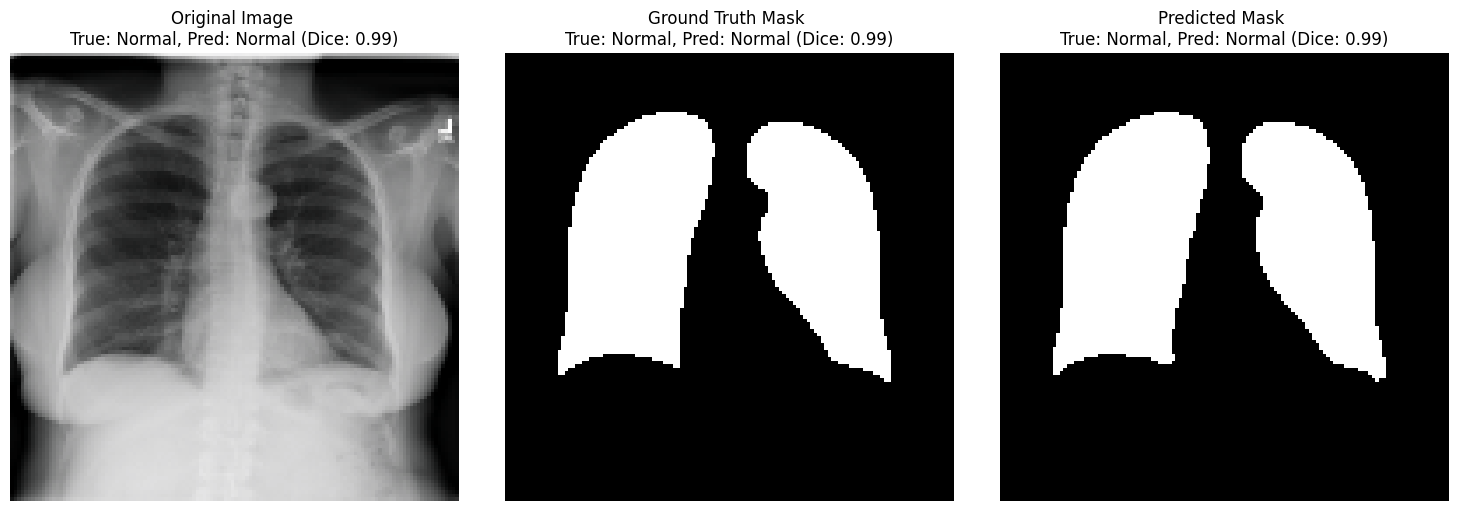

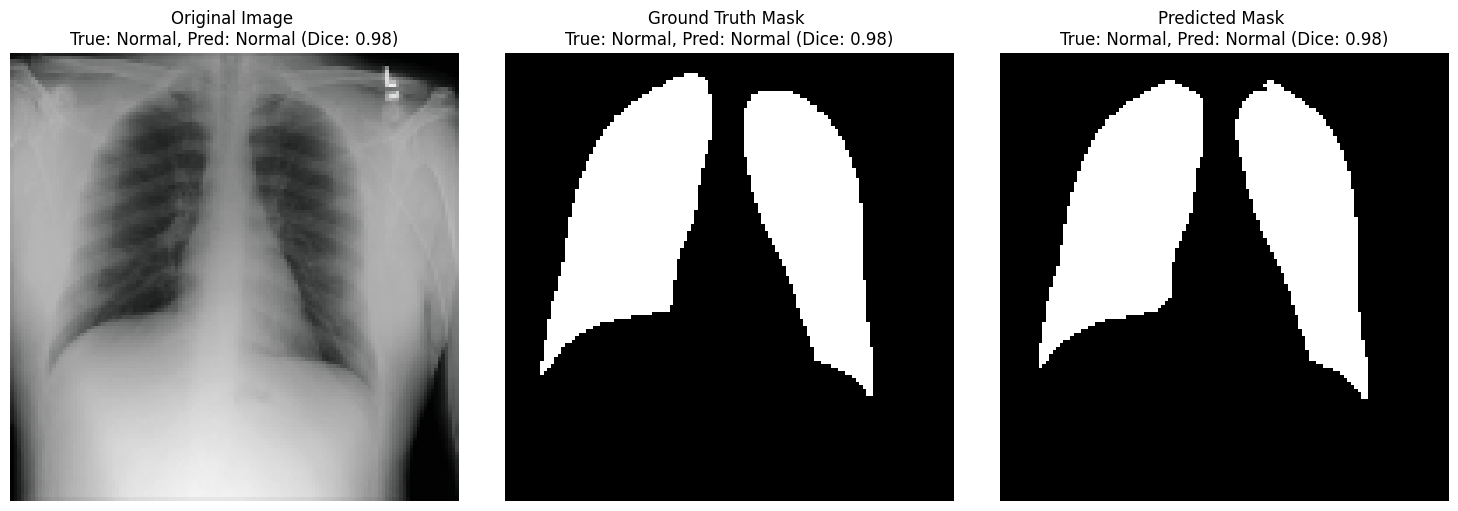

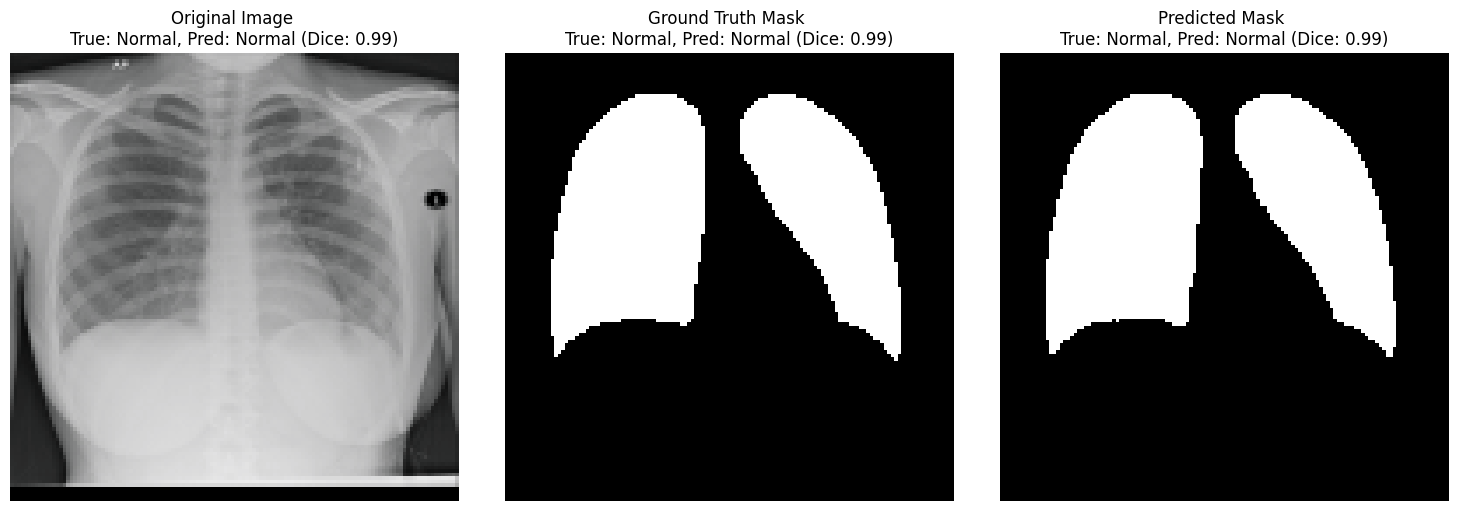

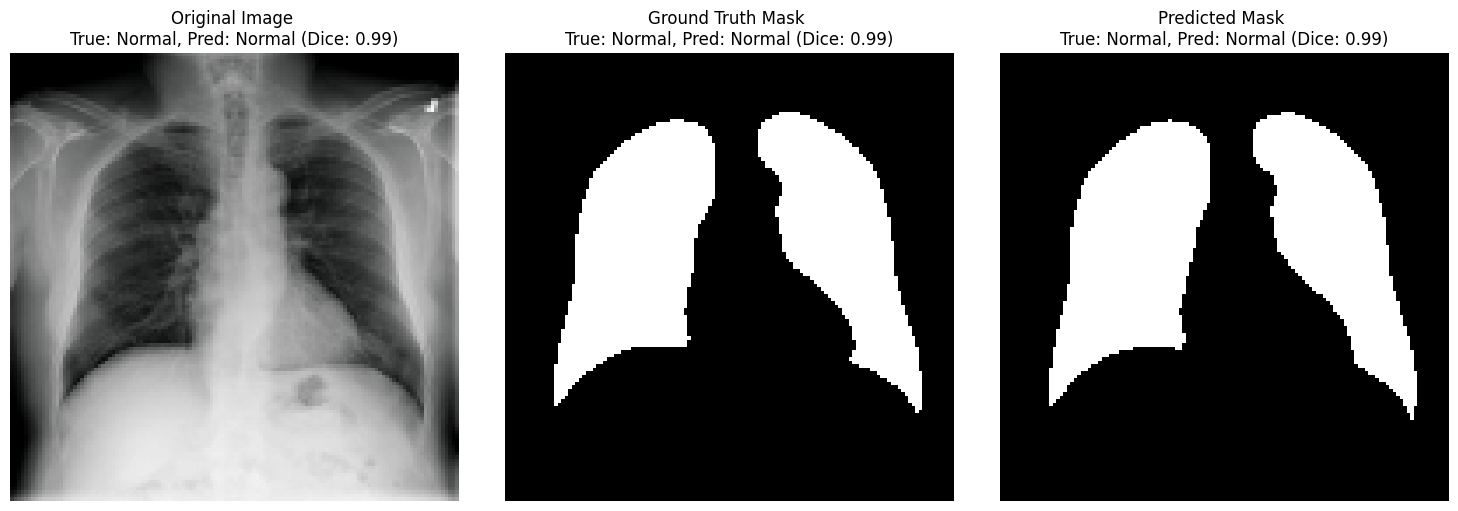

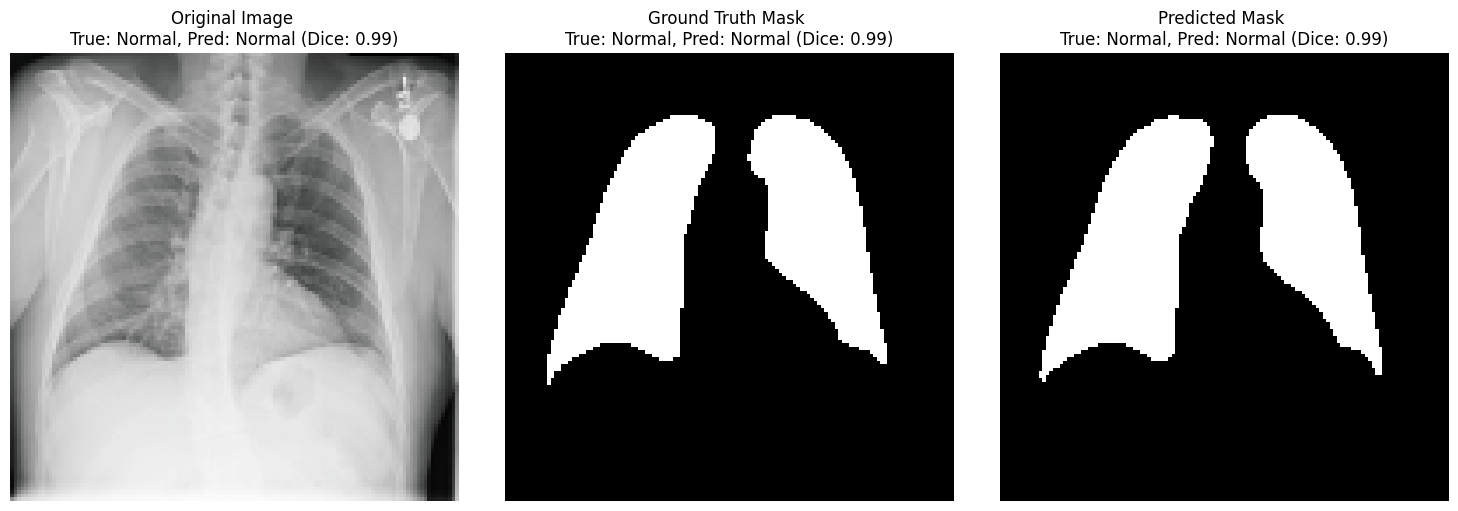

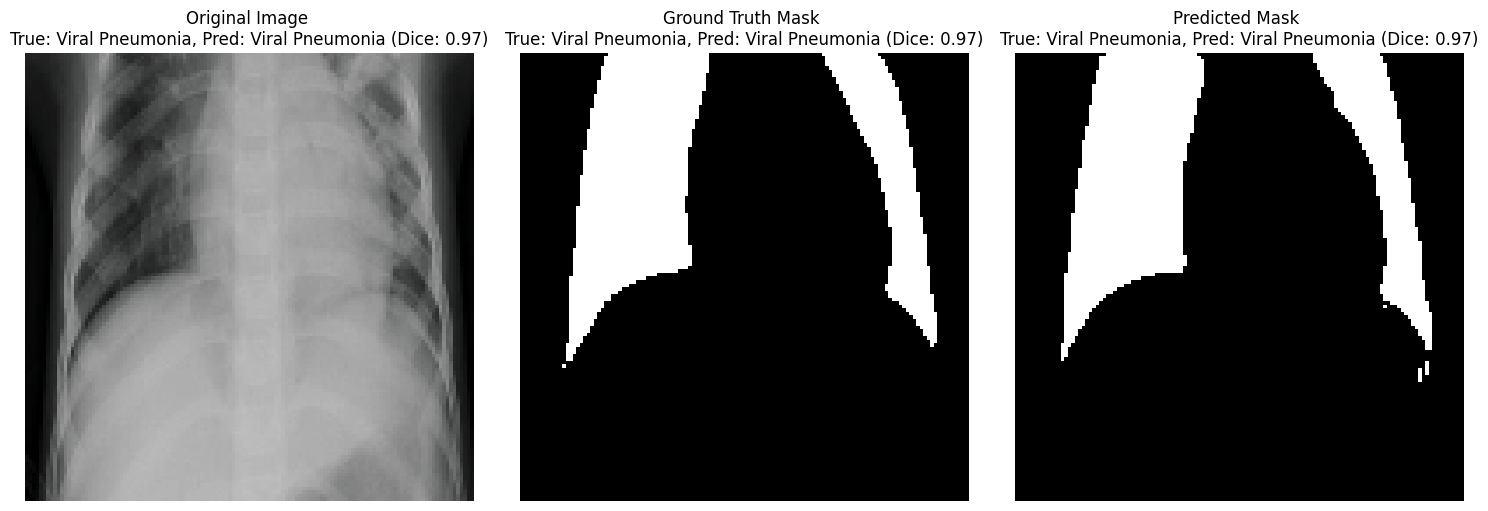

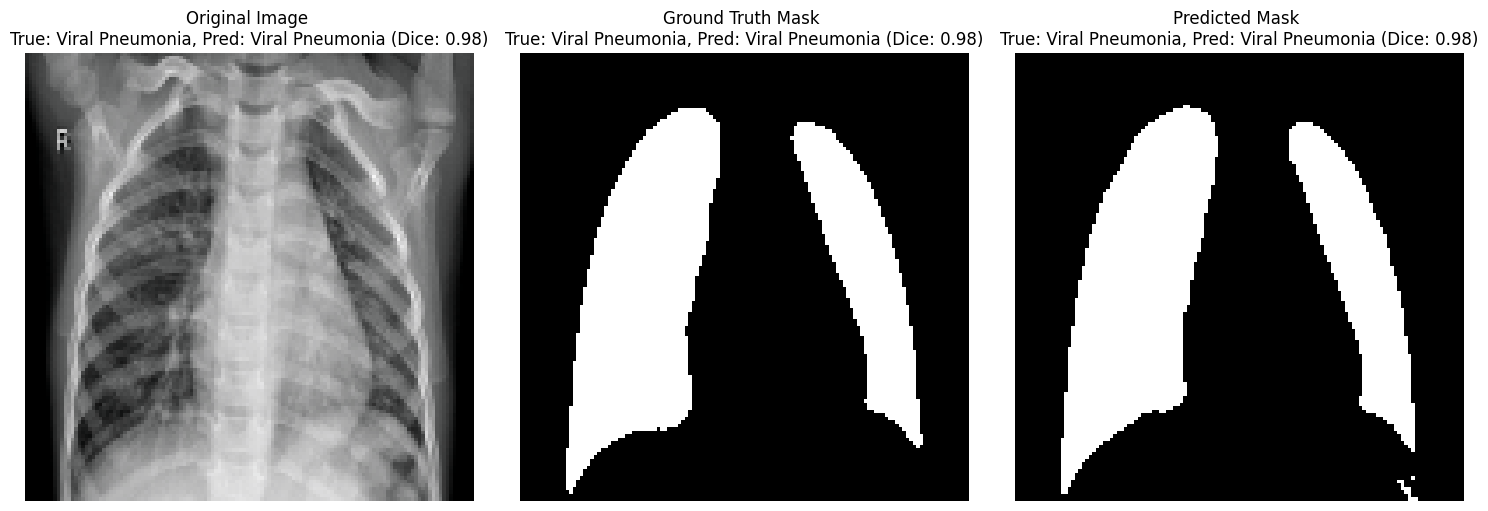

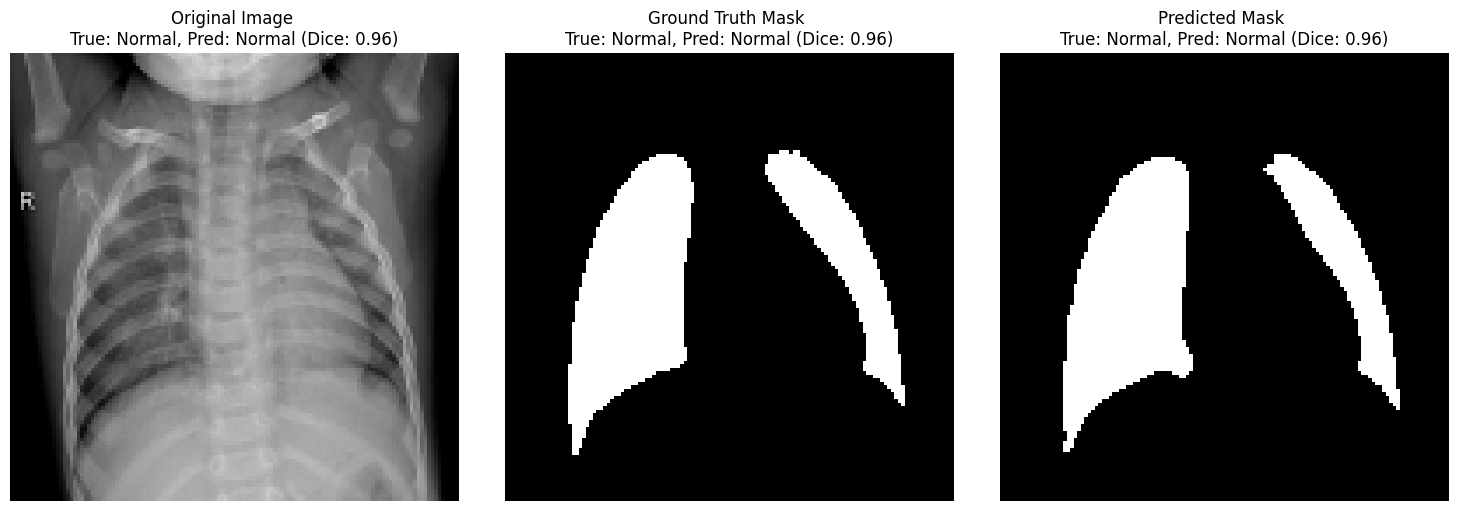

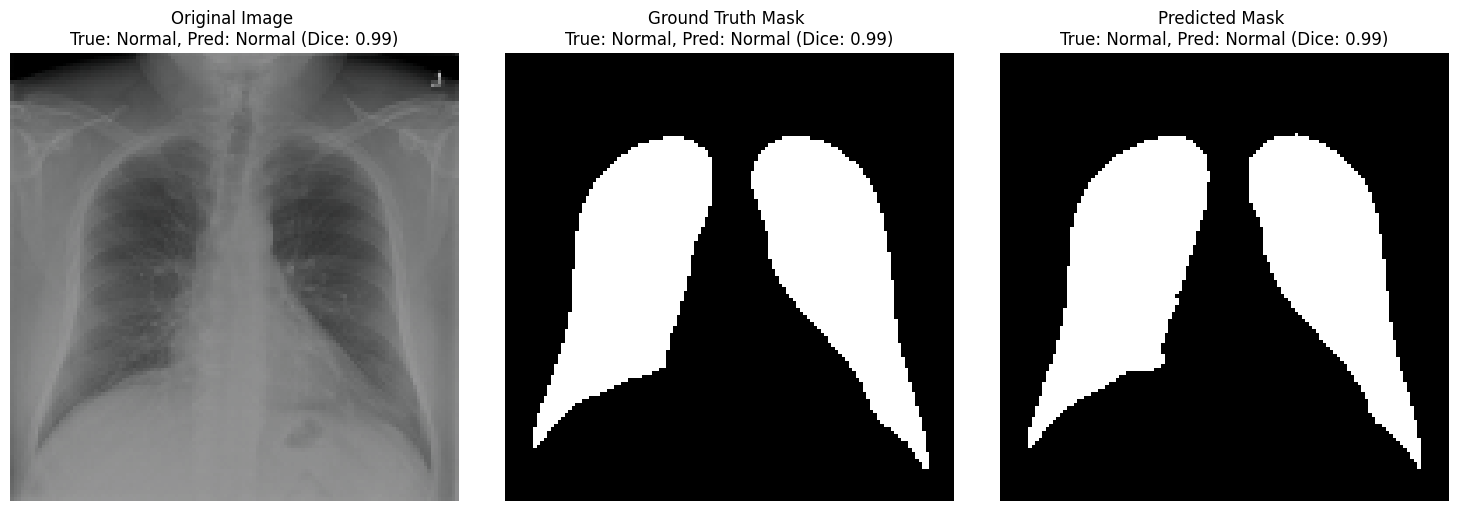

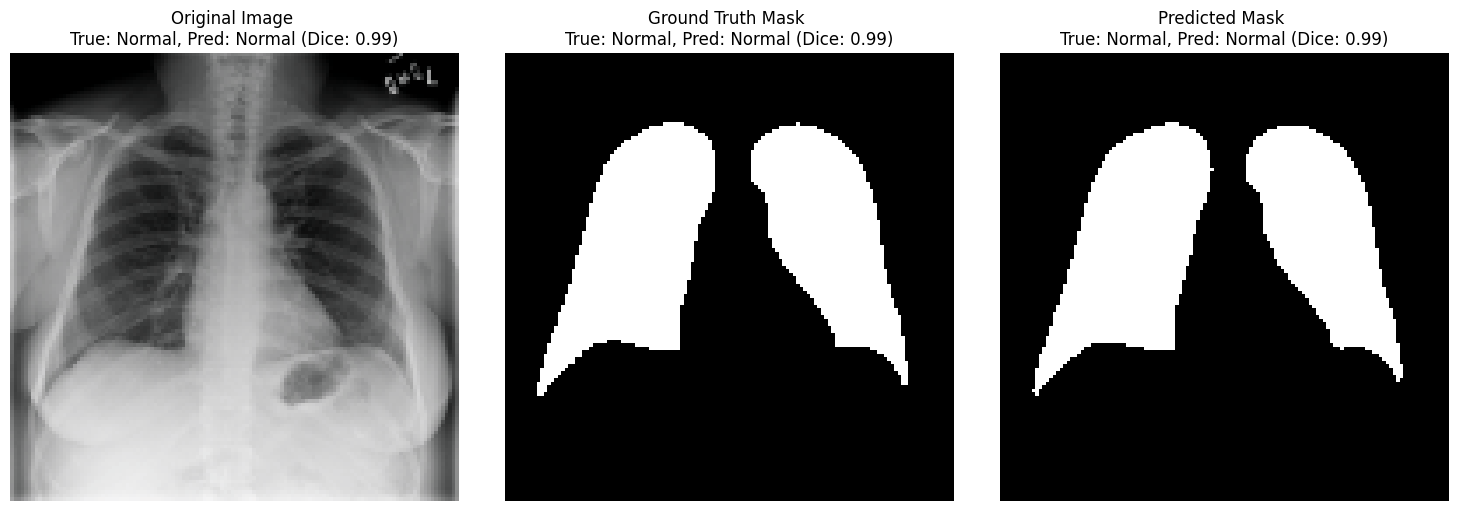

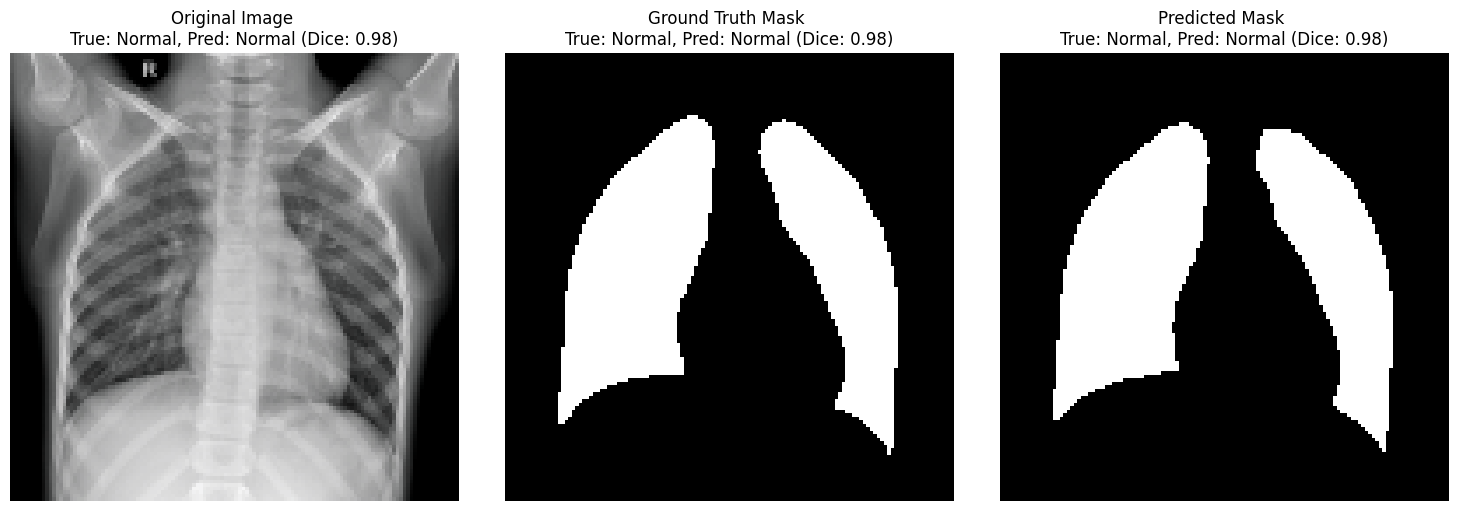

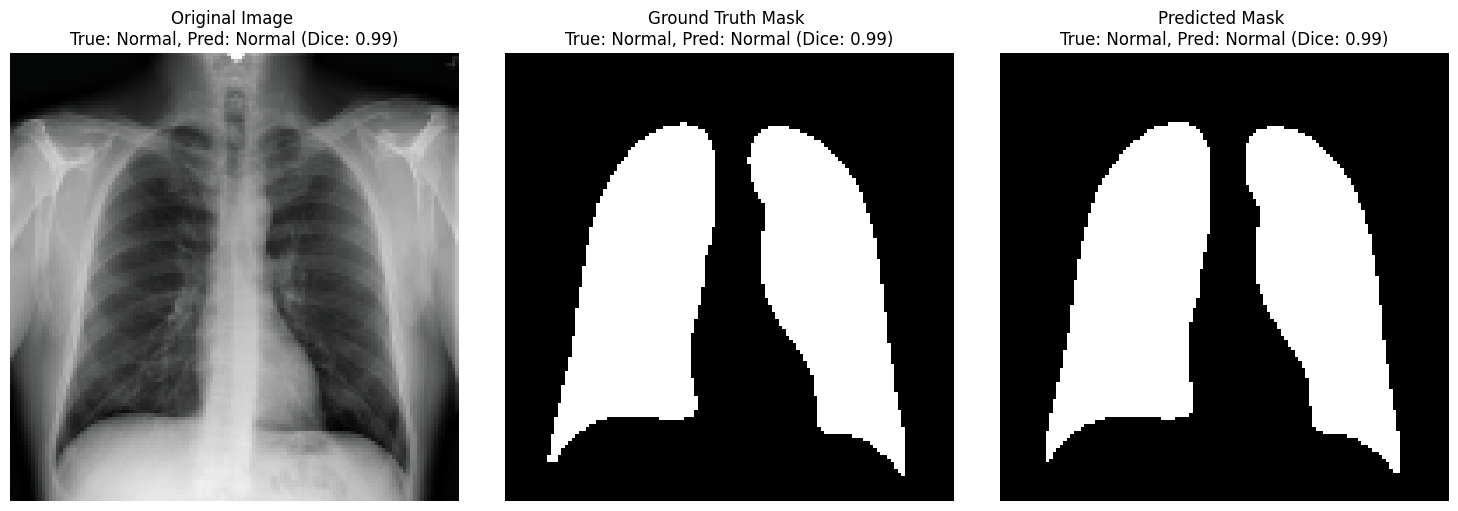

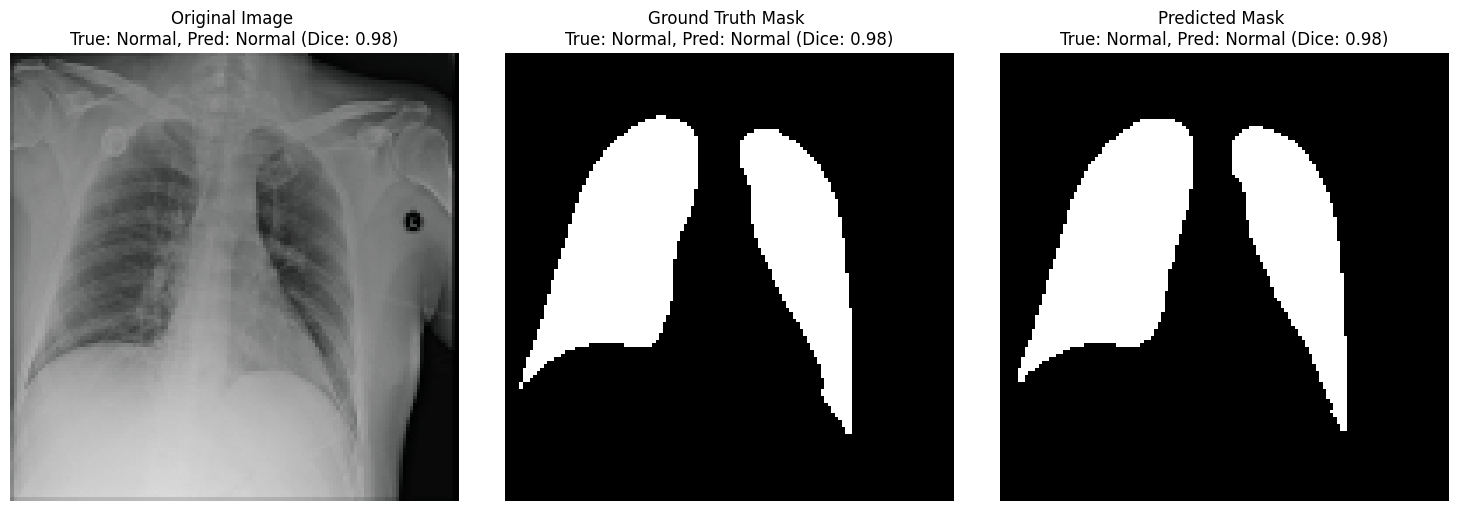

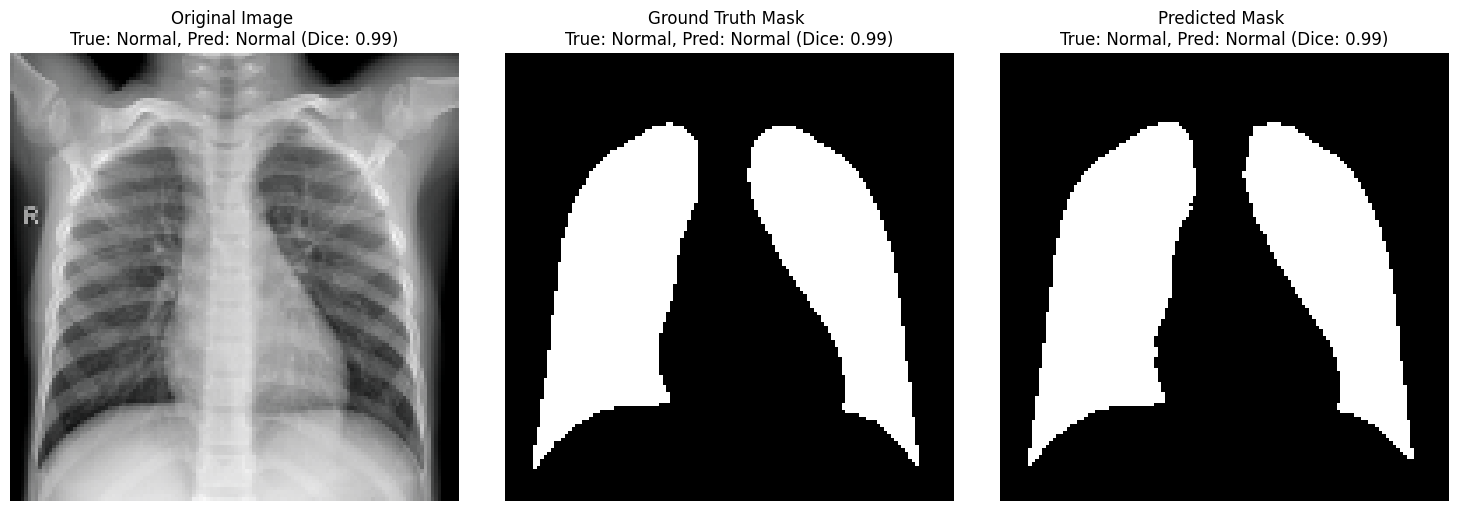

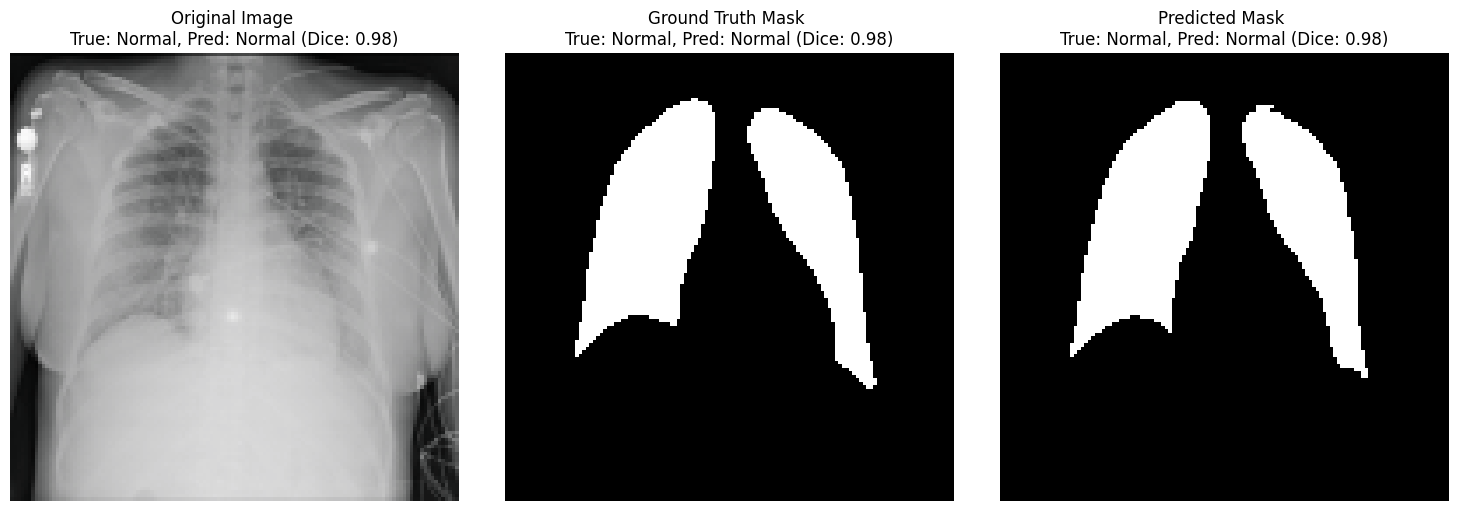

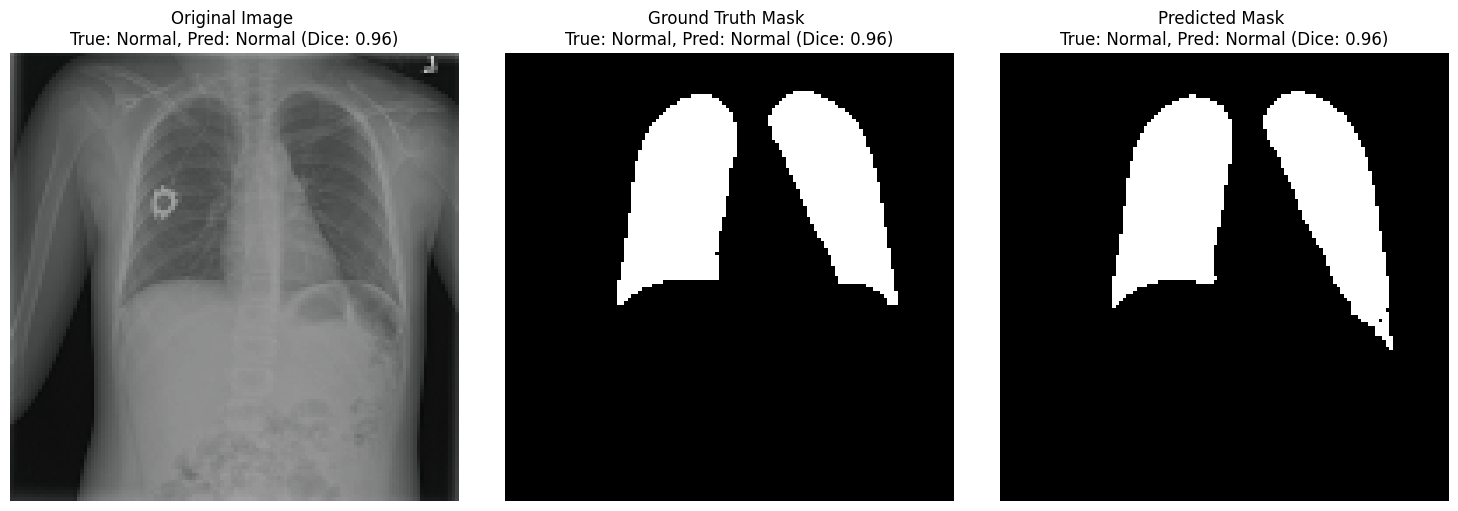

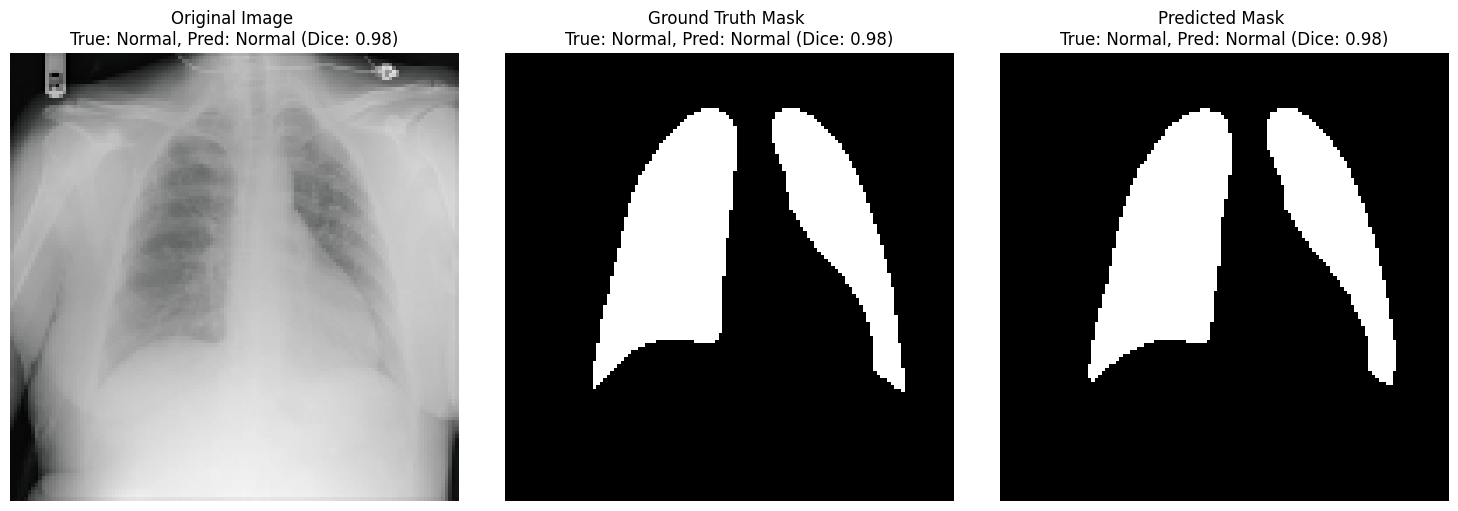

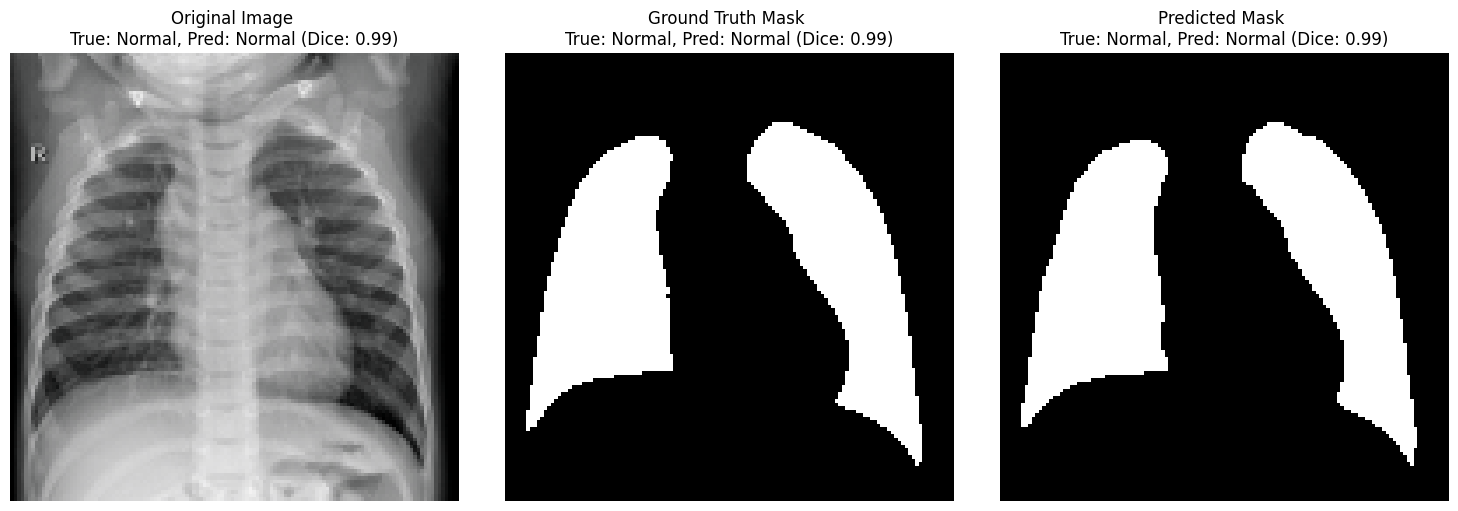

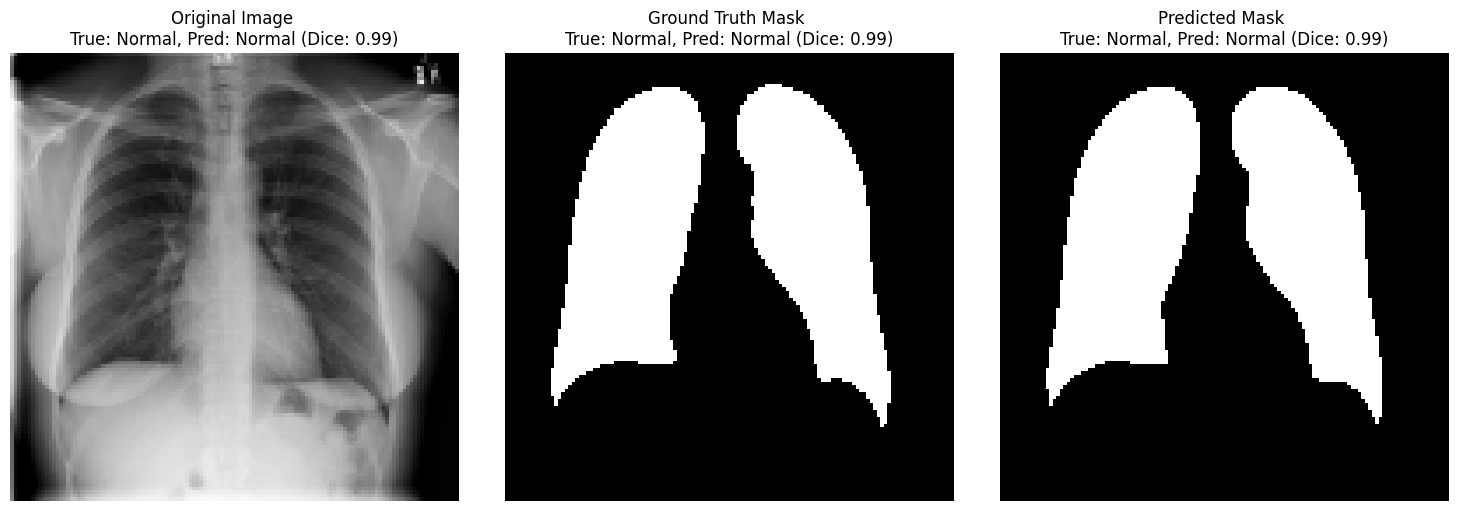

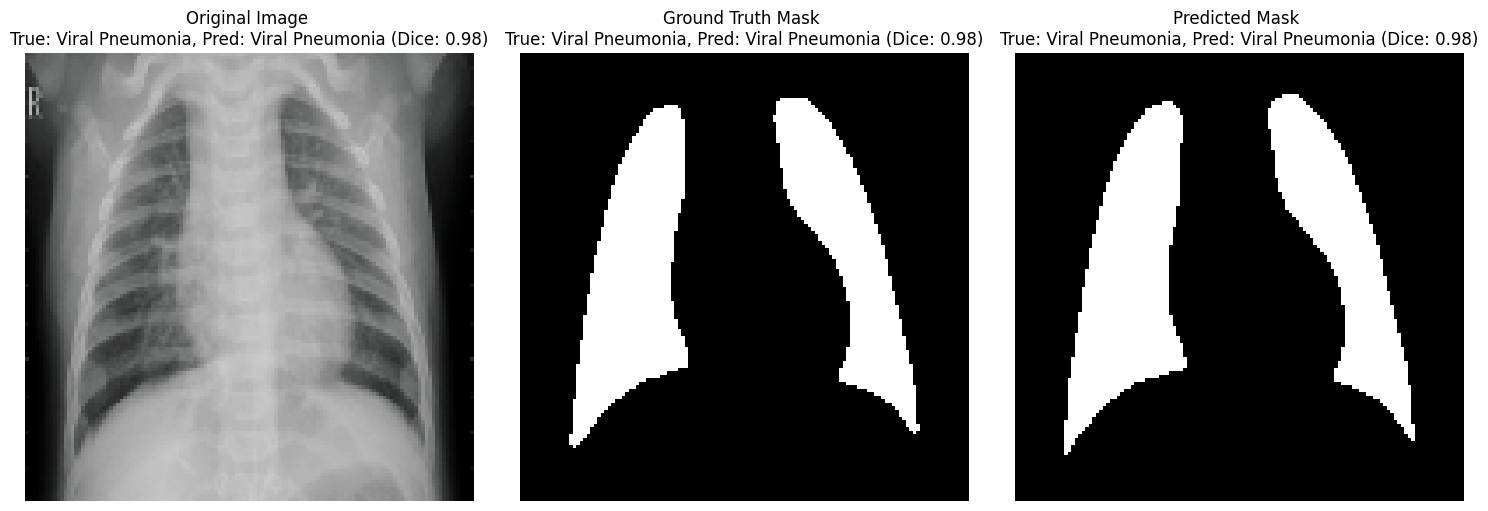

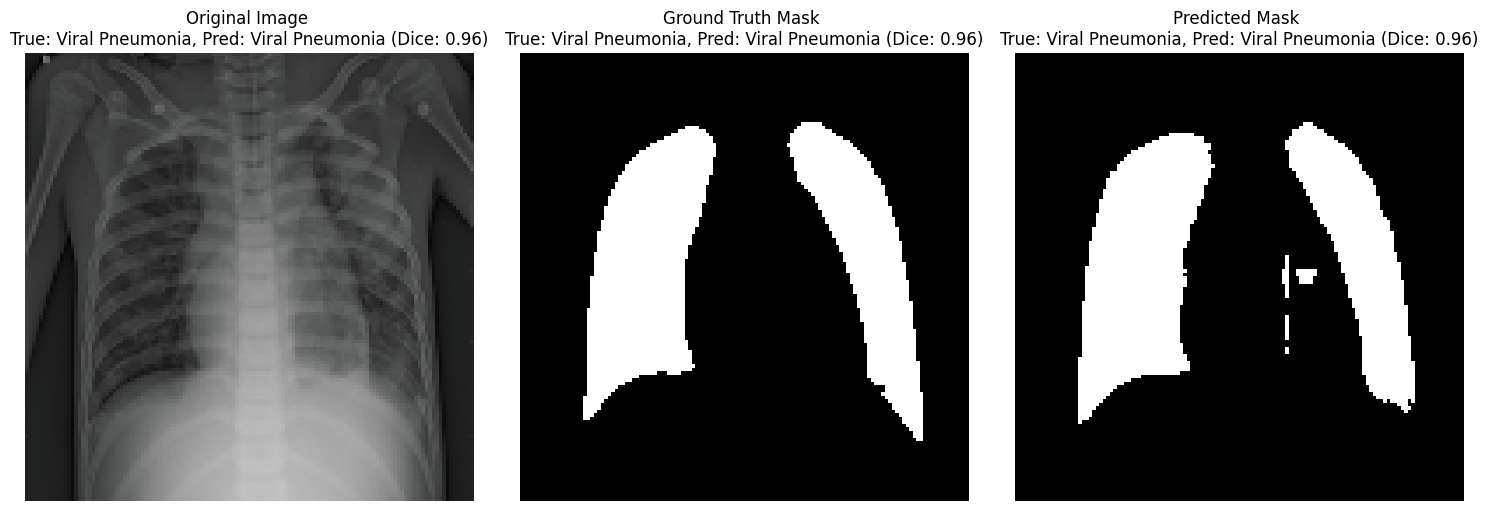

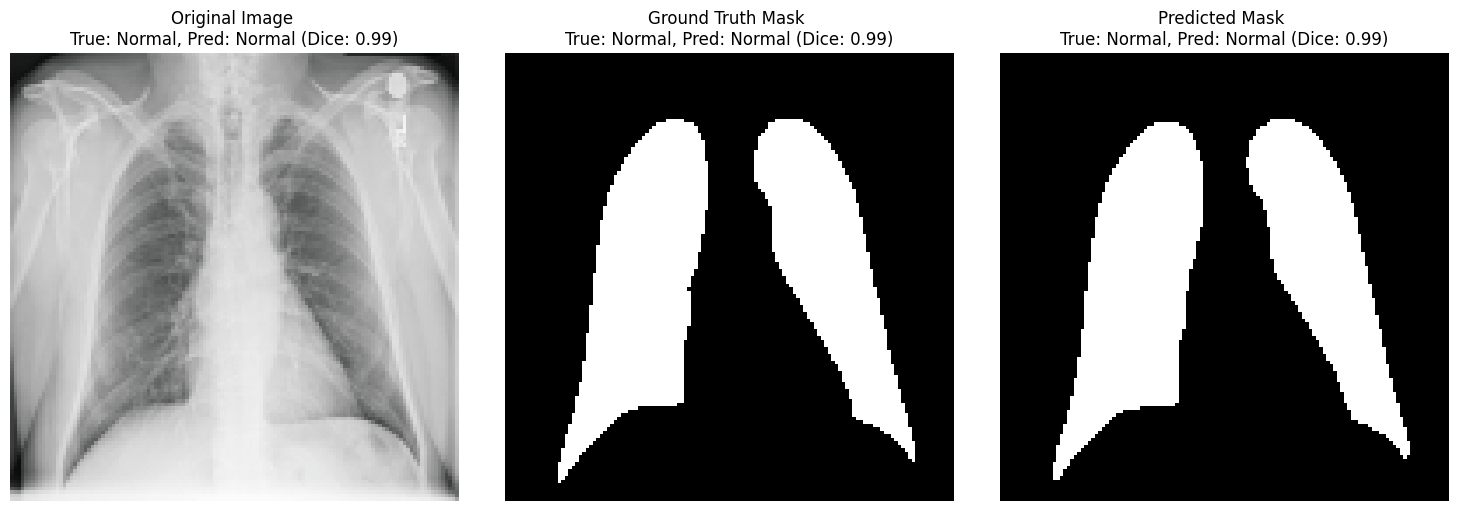

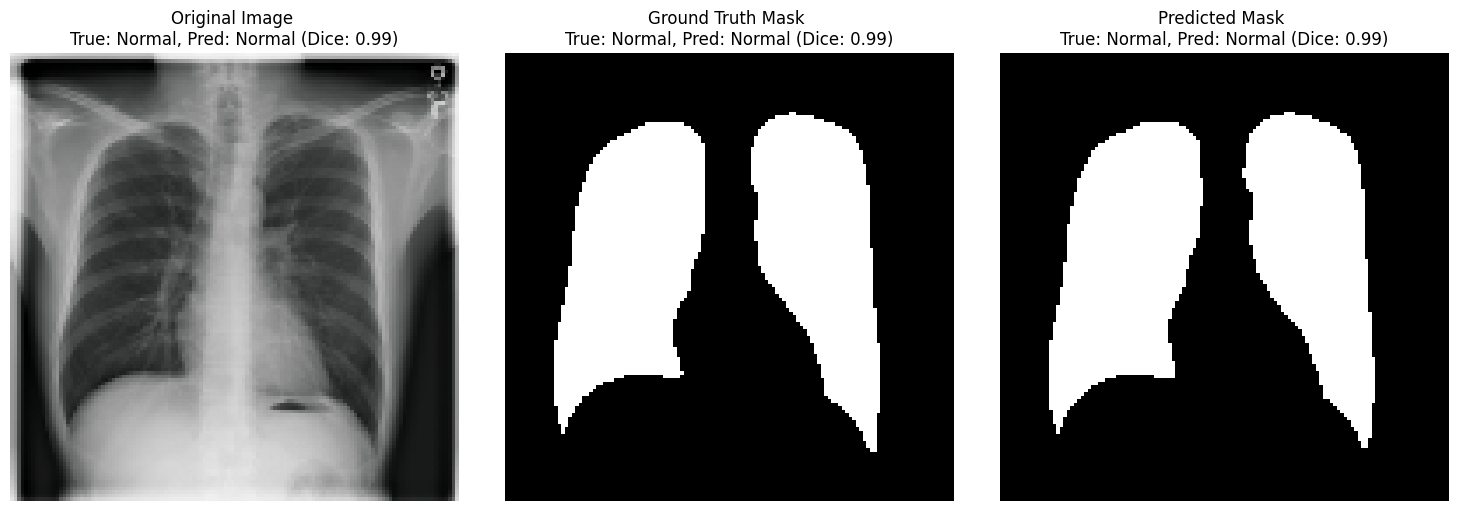

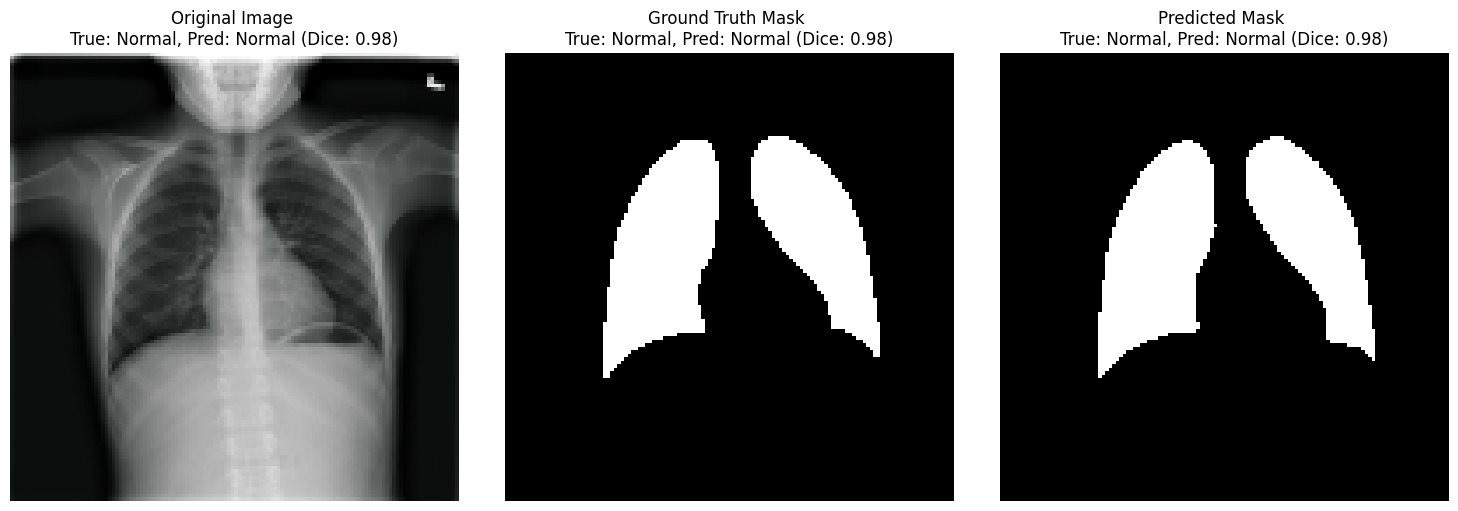

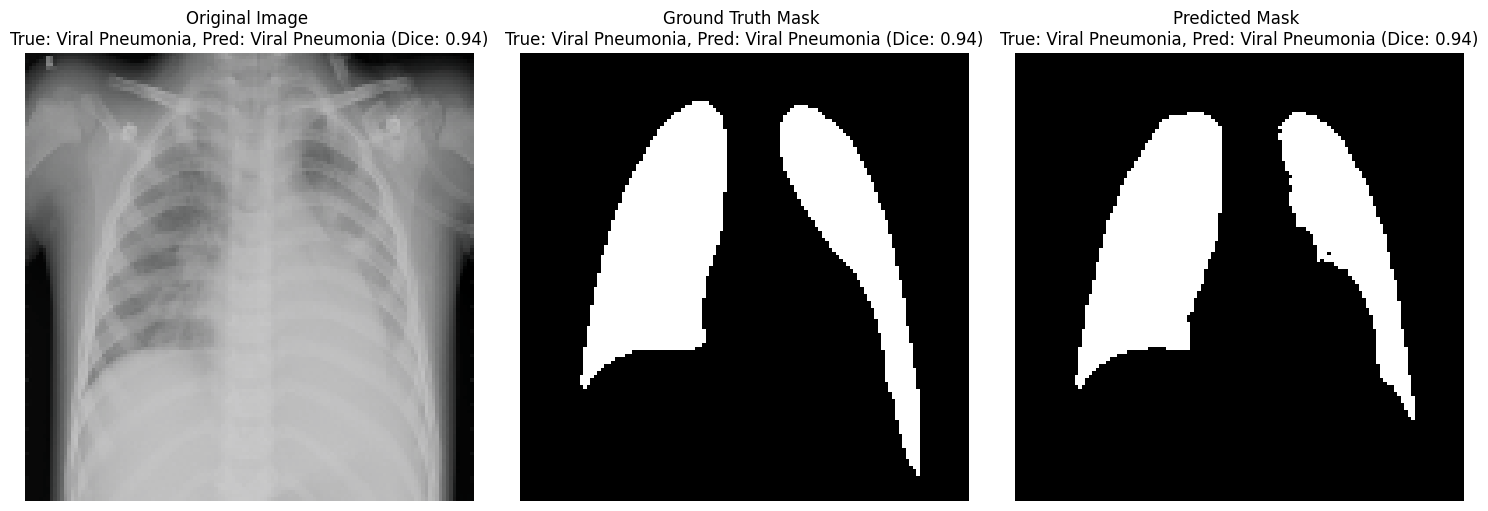

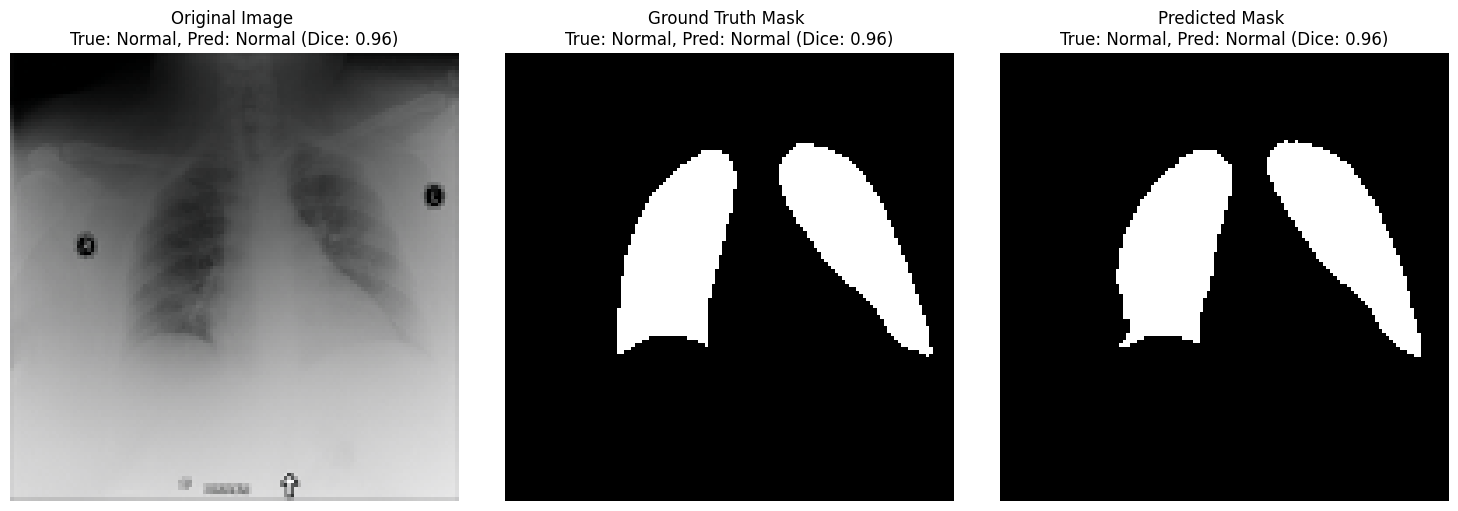

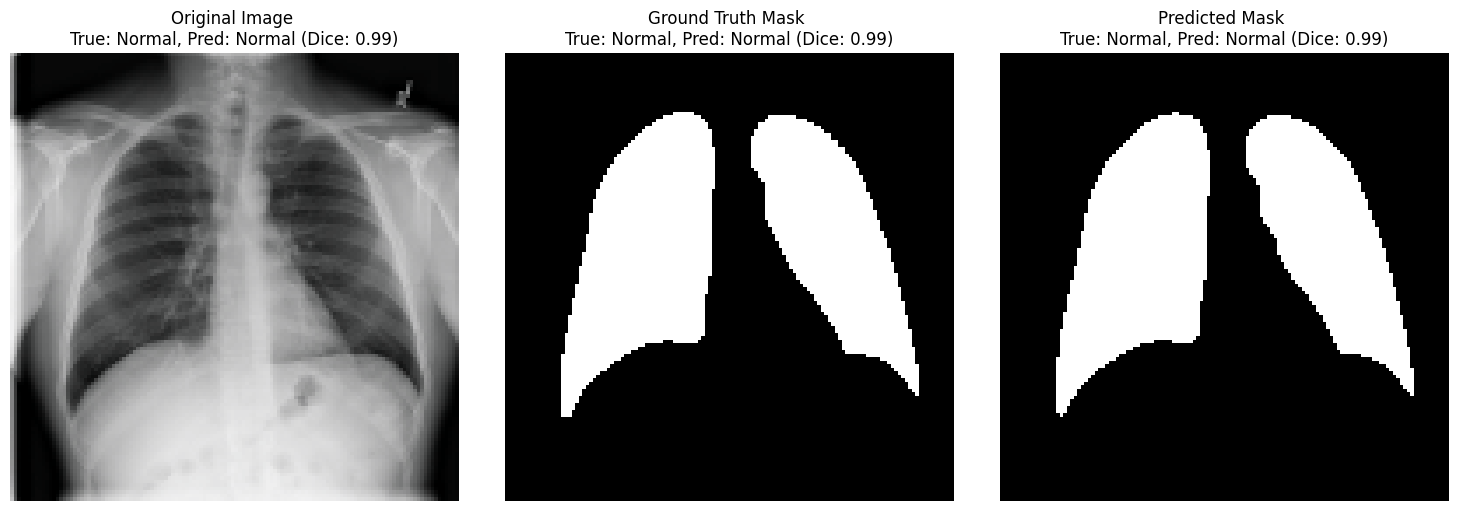

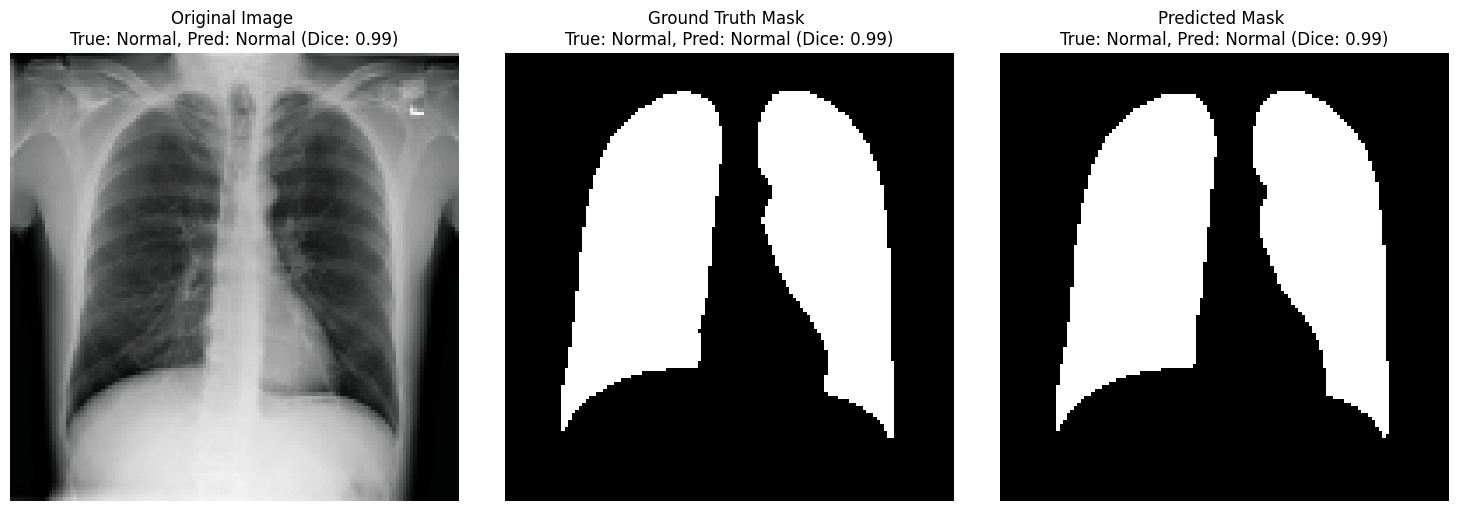

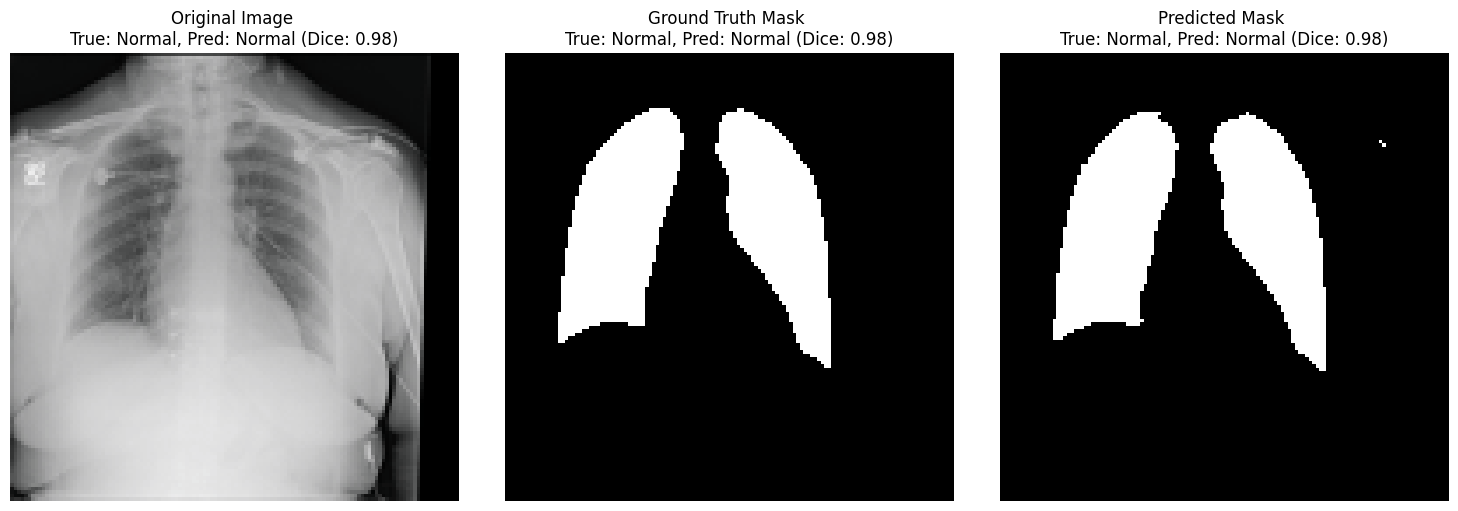

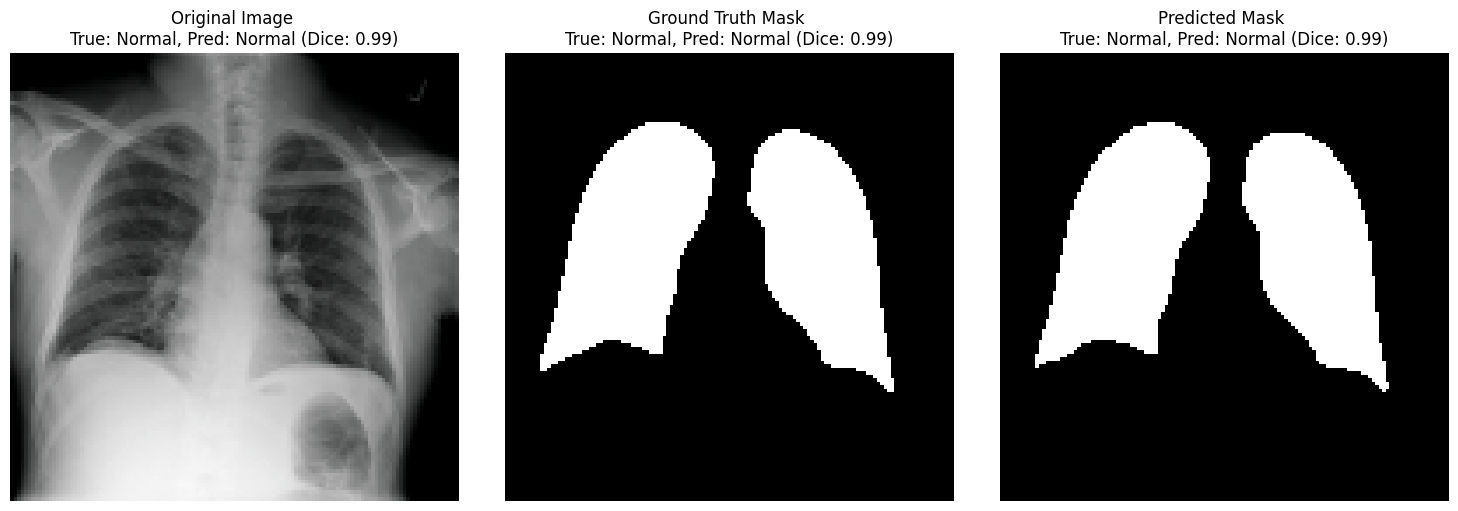

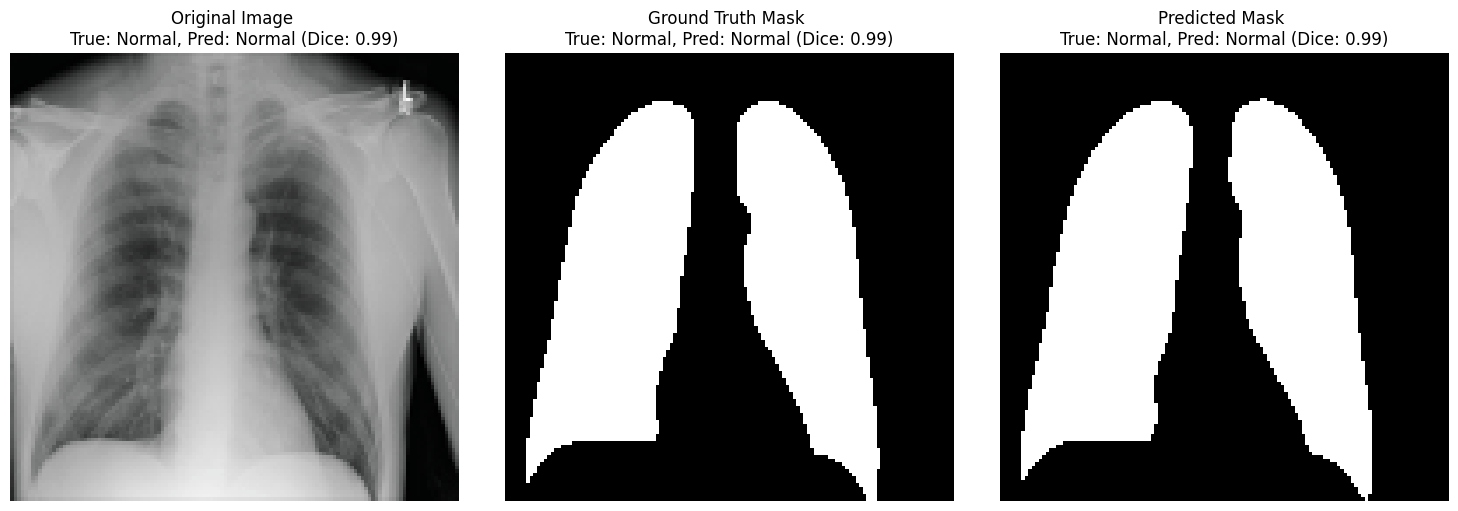

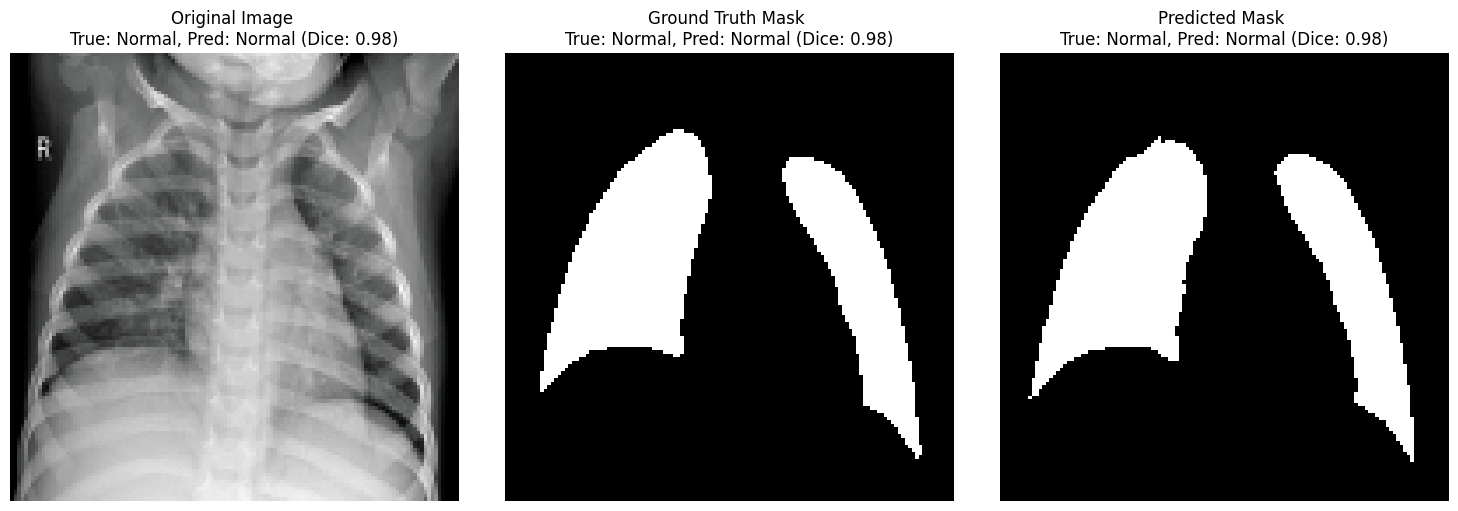

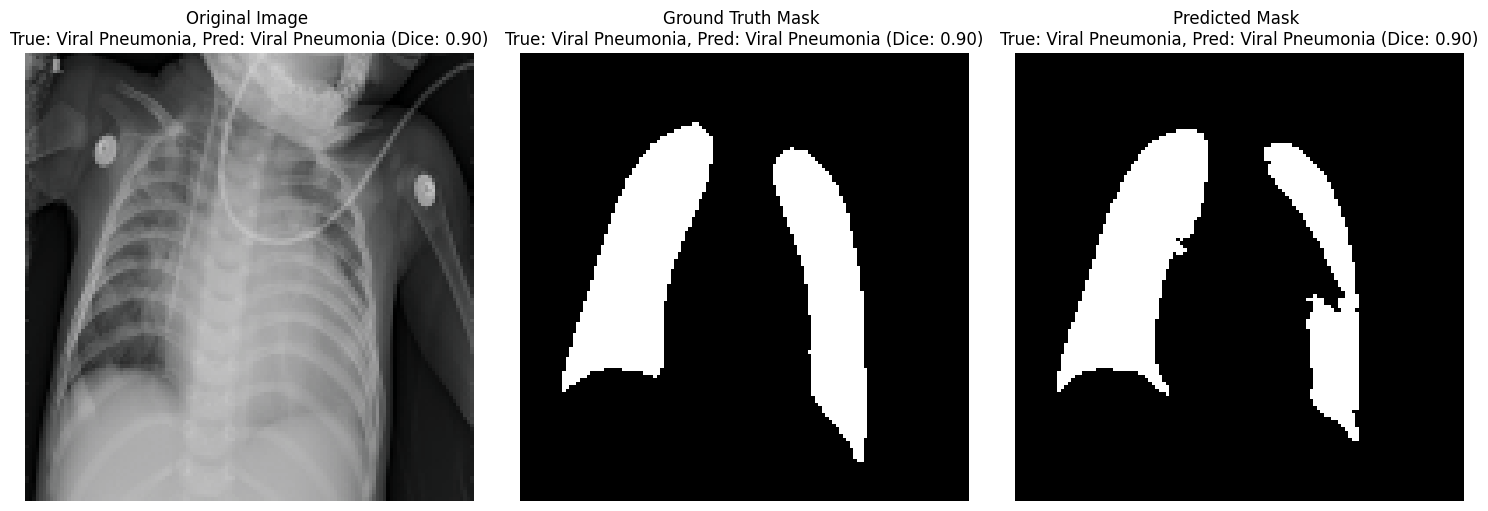

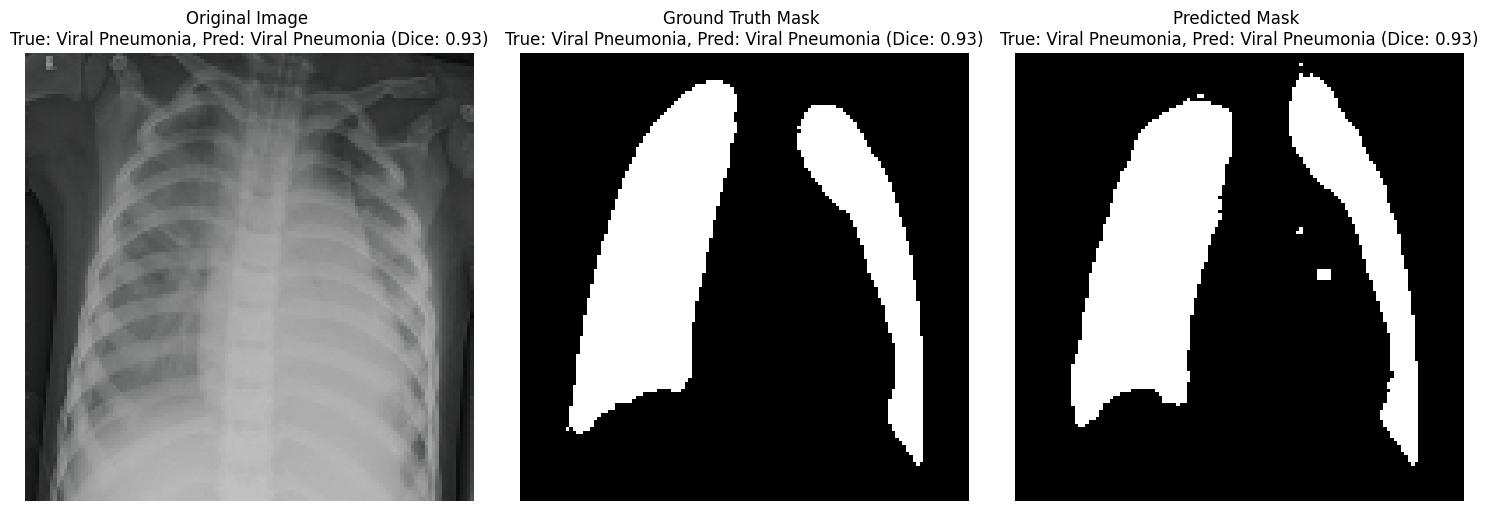

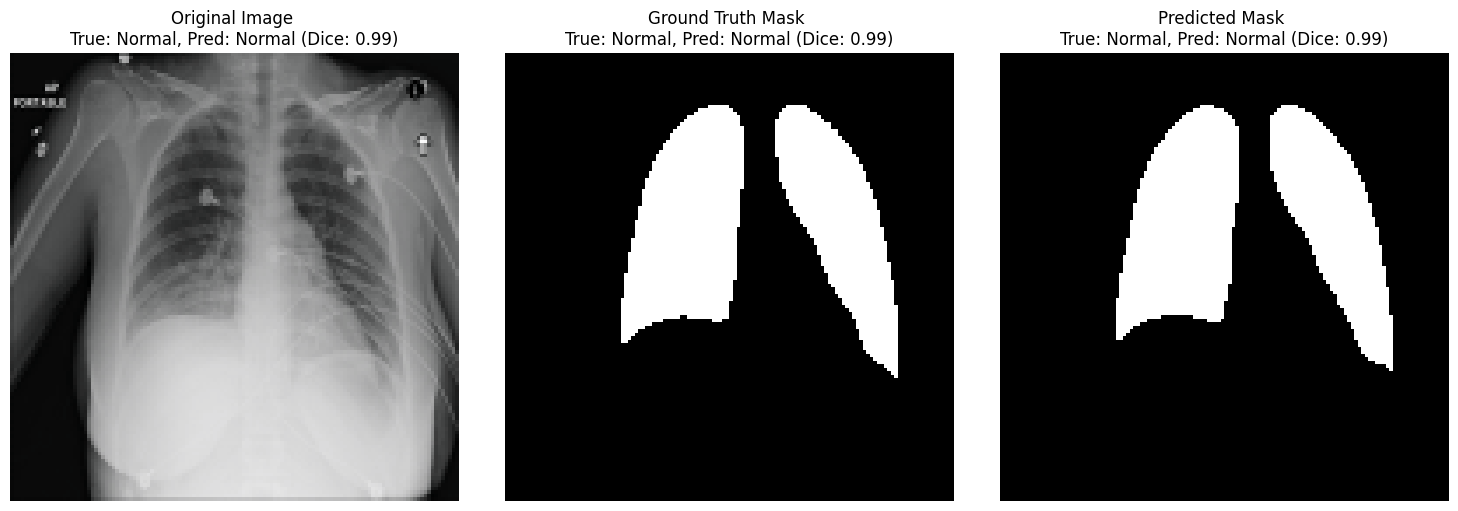

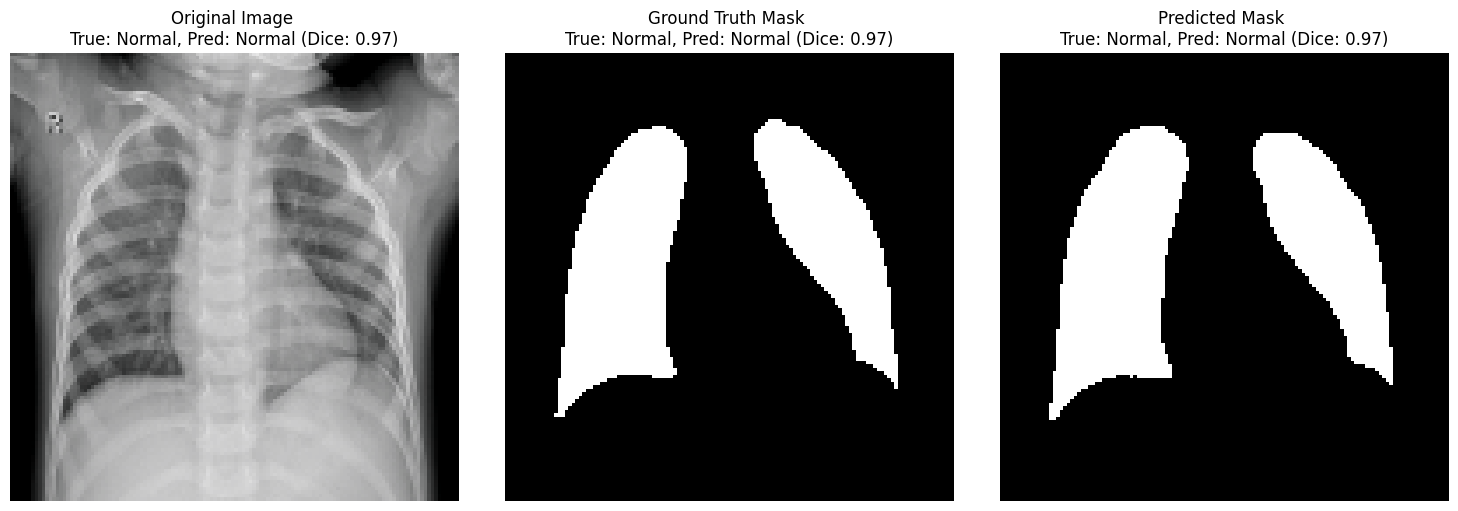

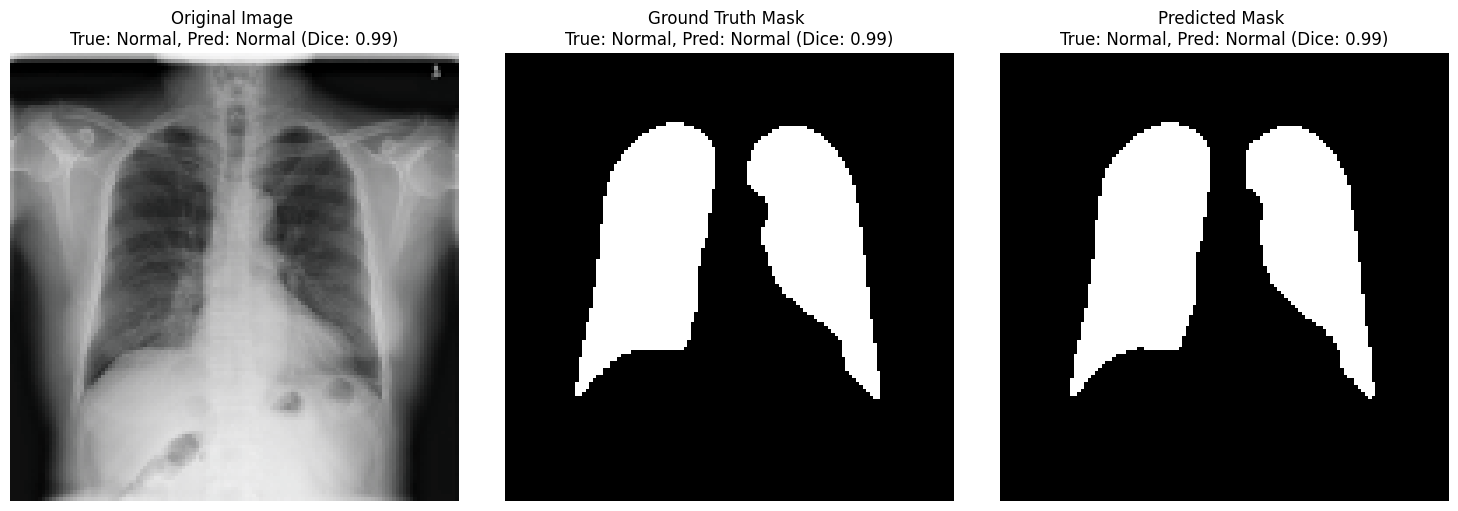

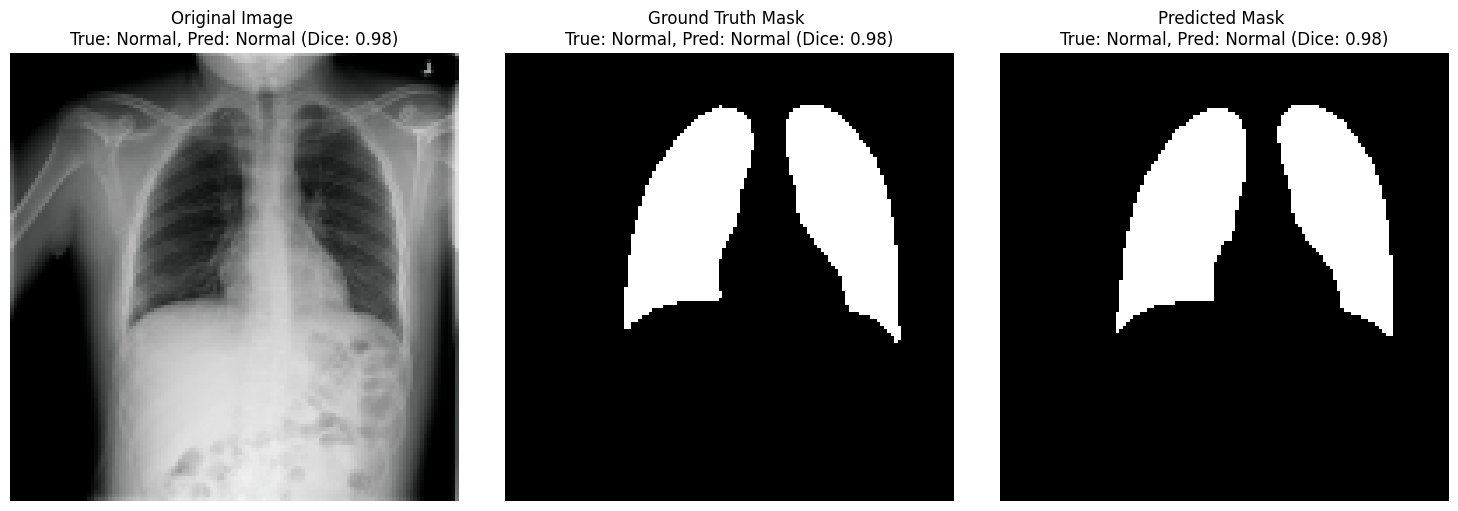

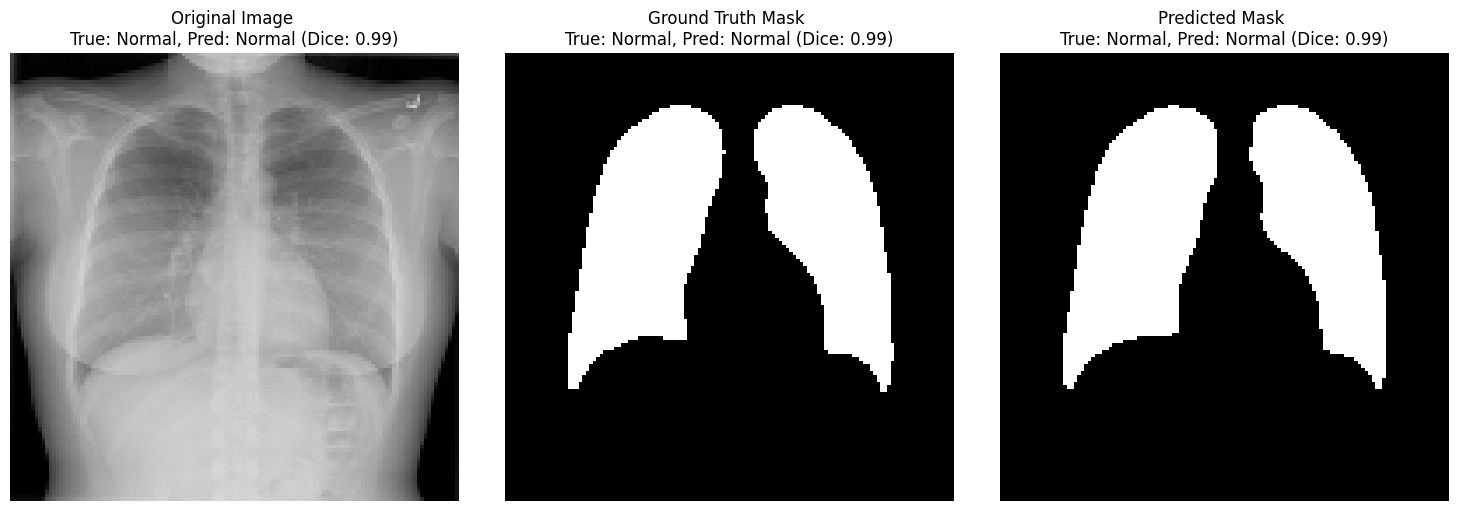

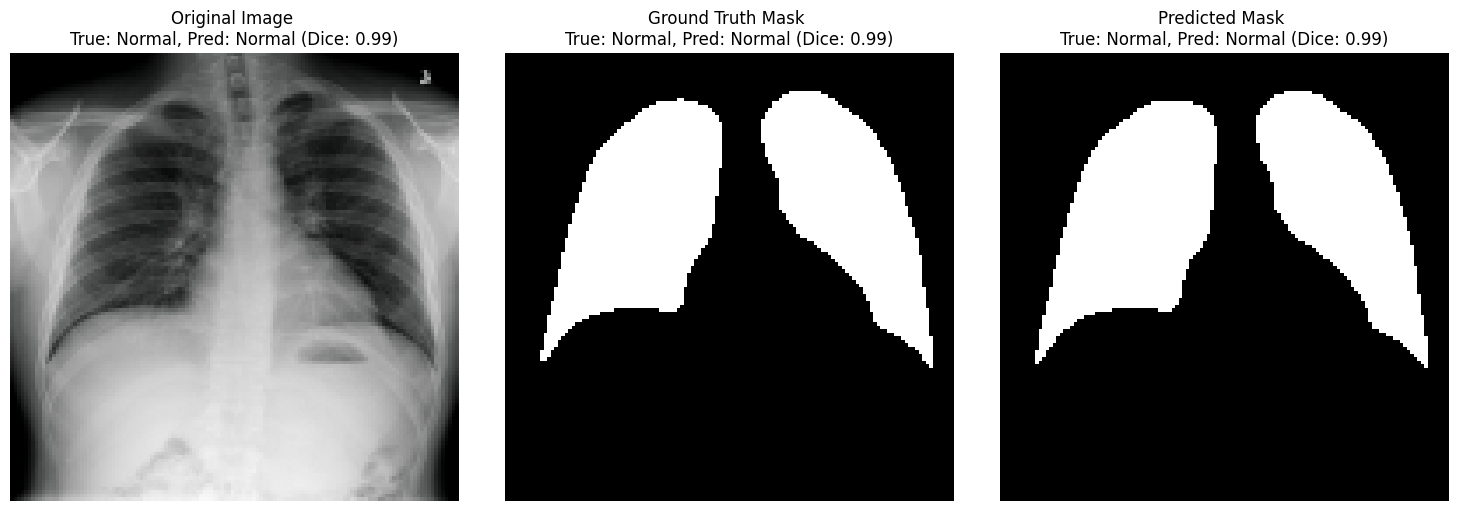

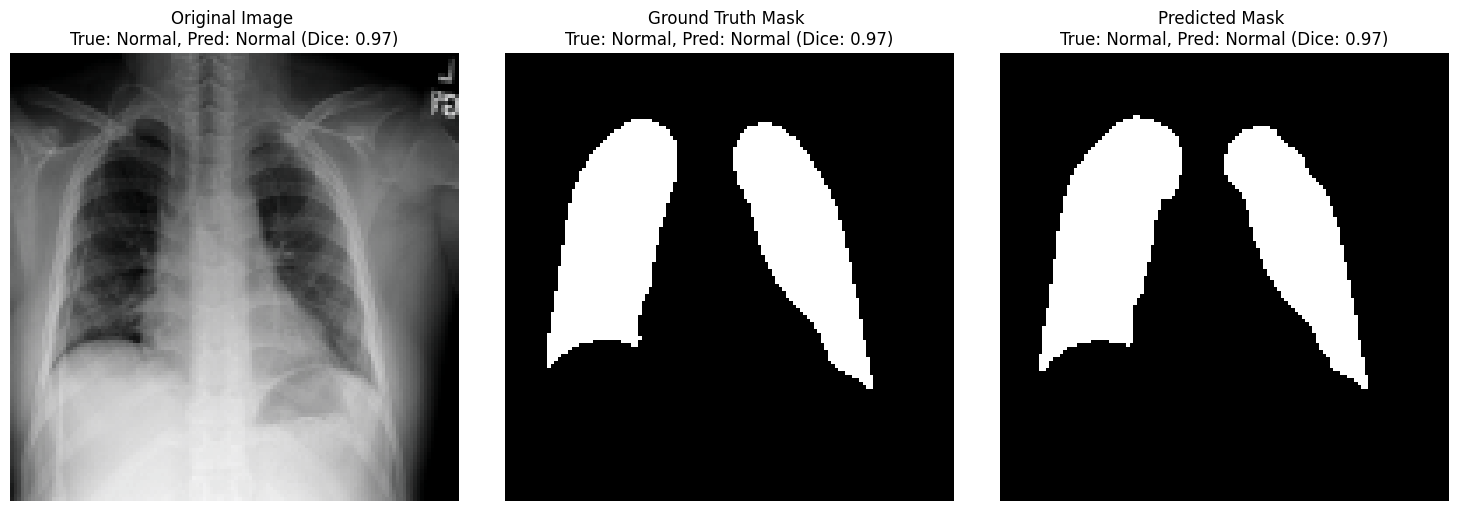

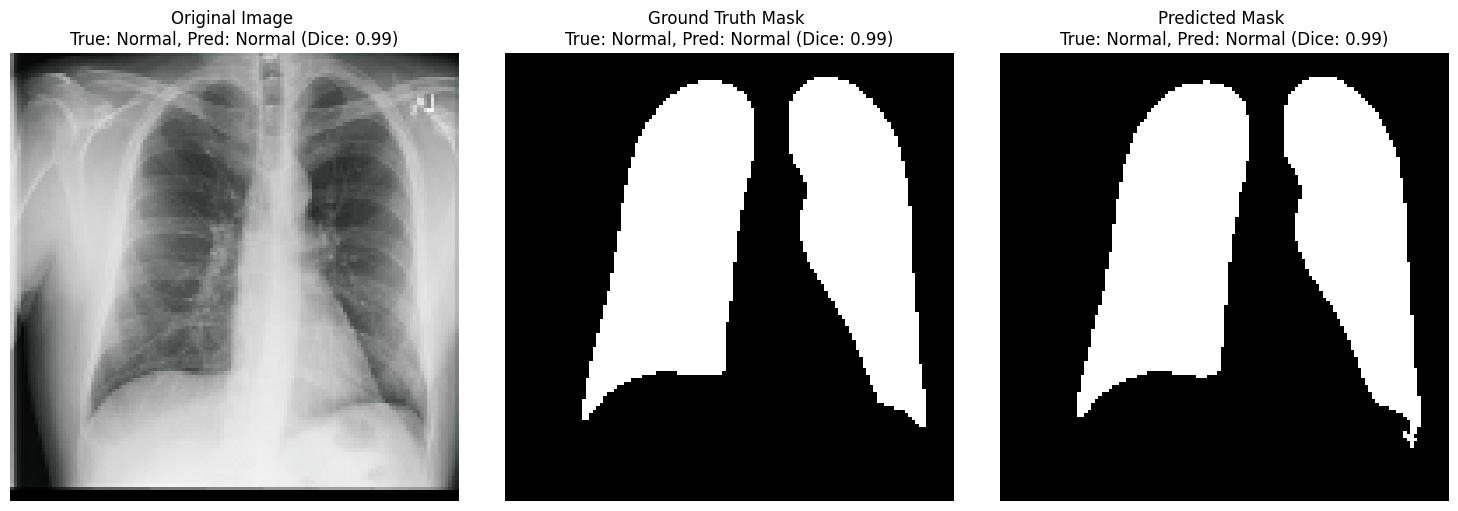

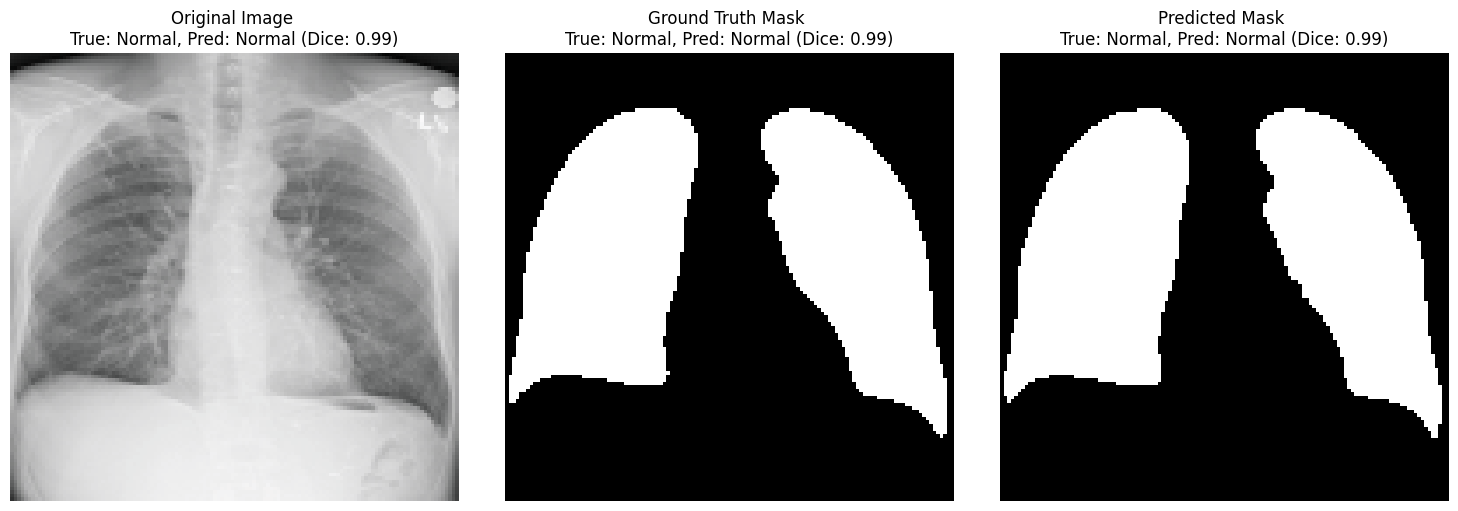

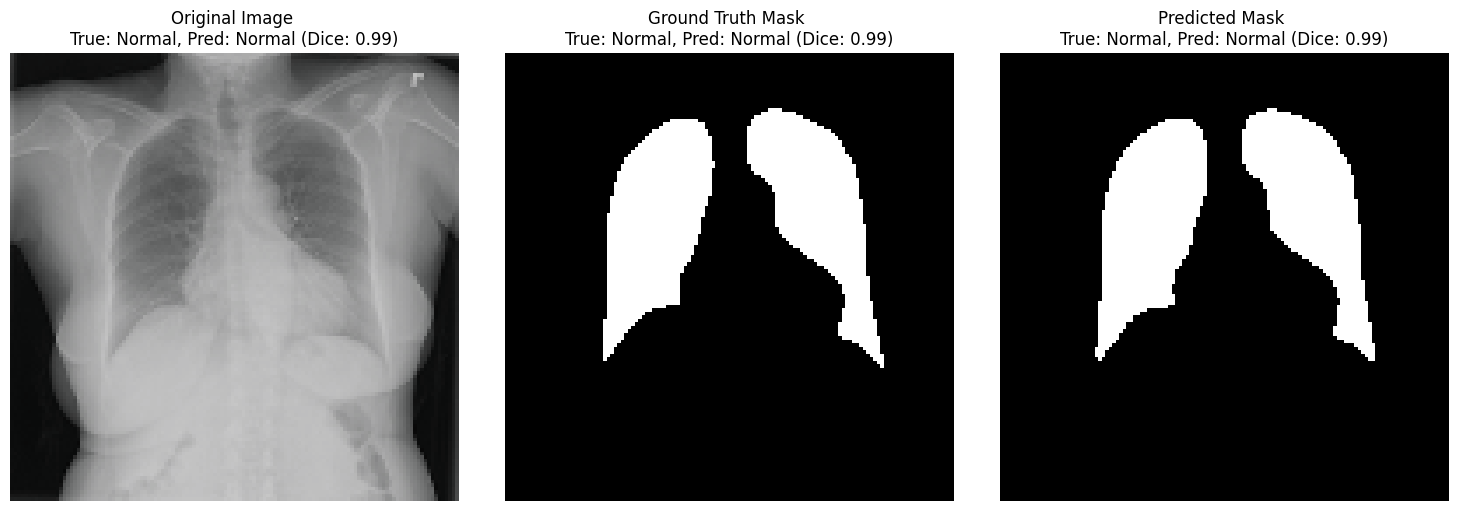

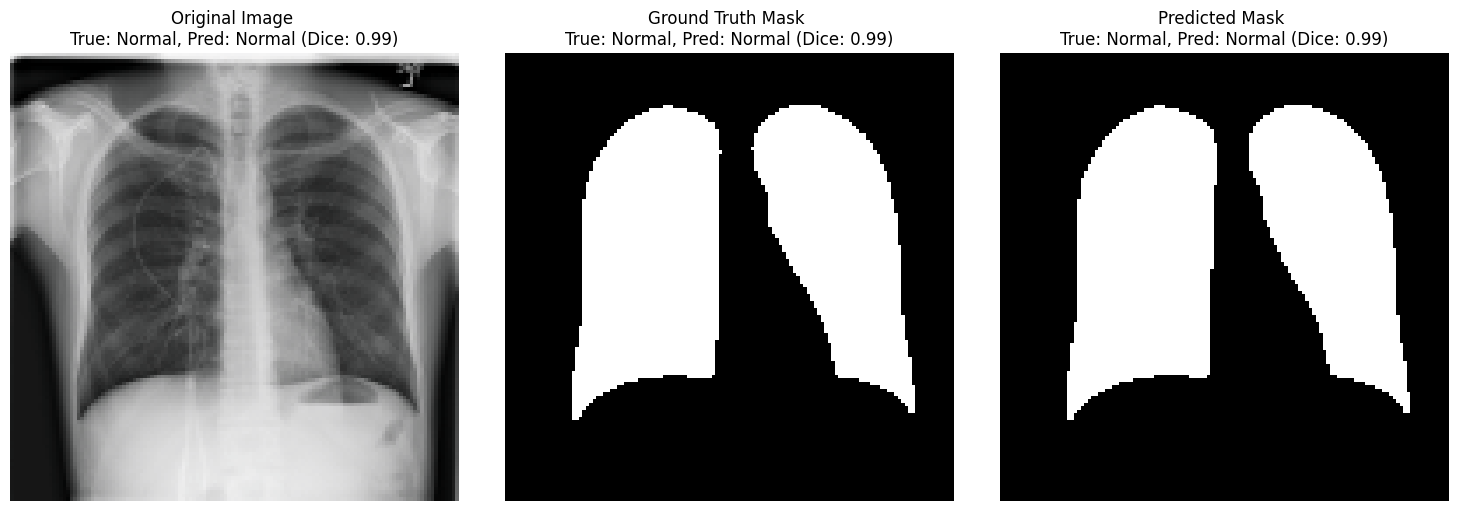

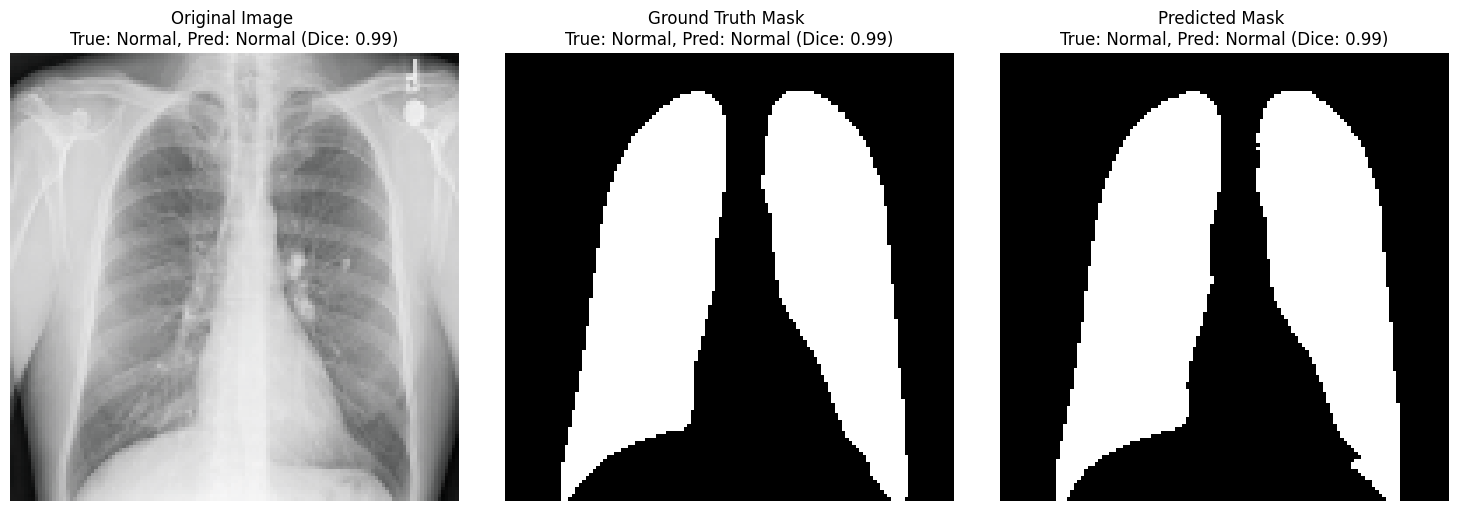

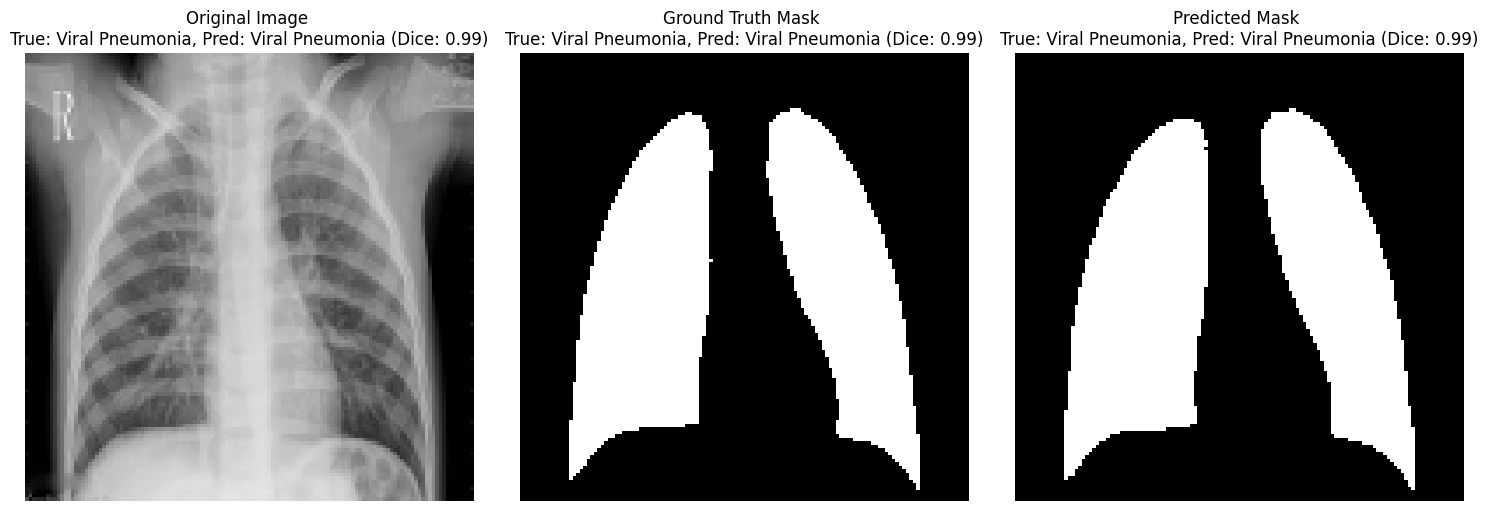

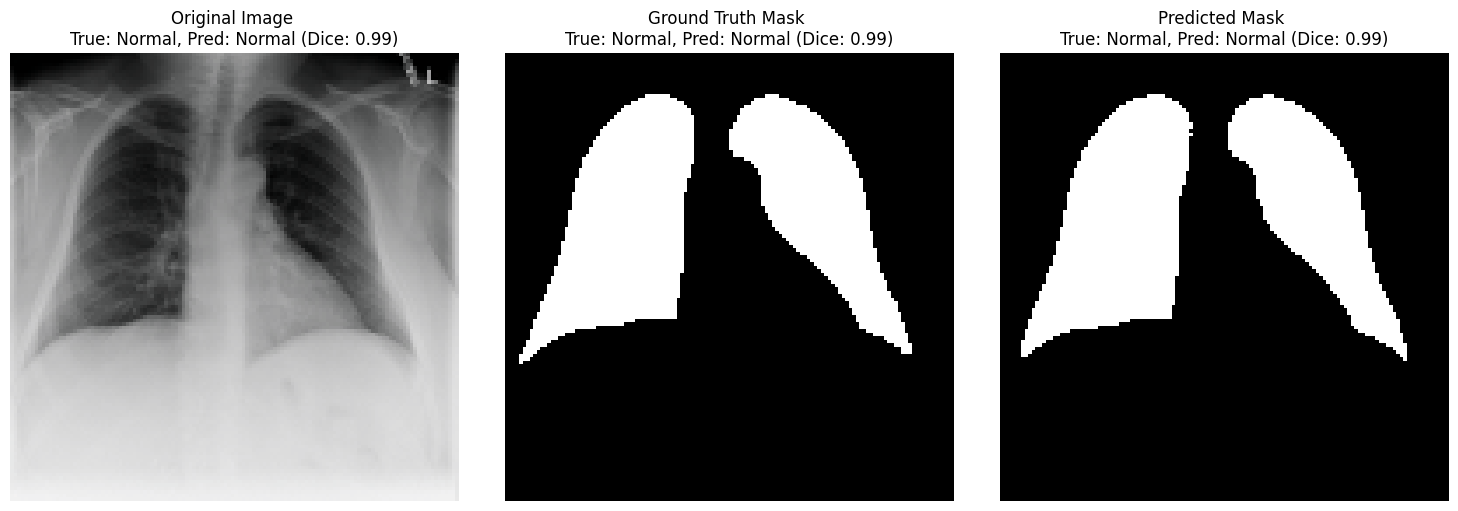


Finished visualizing samples. Remaining predictions saved to 'segmentation_predictions' directory.


In [11]:
# Load the best trained model
# First, instantiate the model with the same architecture as during training
model_path = "best_ecunet_combined_model.pth"
loaded_model = ECUNet(n_classes=NUM_CLASSES_CLASSIFICATION).to(device)

try:
    # Load the saved state dictionary (the learned weights)
    checkpoint = torch.load(model_path, map_location=device)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from {model_path} (Epoch {checkpoint['epoch']+1}, Val Loss: {checkpoint['val_total_loss']:.4f})")
except FileNotFoundError:
    print(f"Error: Model file '{model_path}' not found. Please ensure training was successful and saved the model.")
    # Exit or handle the error appropriately if the model isn't found
    exit()

# Set the loaded model to evaluation mode
loaded_model.eval()

# Function to visualize segmentation predictions
def visualize_segmentation(image_tensor, true_mask_tensor, predicted_mask_tensor, title_suffix="", save_path=None):
    """
    Visualizes the original image, ground truth mask, and predicted mask.

    Parameters:
    - image_tensor (torch.Tensor): Original input image (CxHxW).
    - true_mask_tensor (torch.Tensor): Ground truth segmentation mask (1xHxW).
    - predicted_mask_tensor (torch.Tensor): Model's predicted segmentation mask (1xHxW, probabilities).
    - title_suffix (str): Additional text for plot titles.
    - save_path (str): Optional path to save the visualization.
    """
    plt.figure(figsize=(15, 5)) # Create a figure with a specific size

    # Convert tensors to NumPy arrays for plotting
    # .cpu(): move tensor to CPU if it's on GPU
    # .squeeze(): remove single-dimensional entries (e.g., channel dim for grayscale)
    # .numpy(): convert to NumPy array
    image_np = image_tensor.cpu().permute(1, 2, 0).numpy() # CHW -> HWC for plotting RGB
    true_mask_np = true_mask_tensor.cpu().squeeze().numpy()
    # Threshold predicted mask to binary for clear visualization
    predicted_mask_np = (predicted_mask_tensor.cpu().squeeze().numpy() > 0.5).astype(np.float32)

    # Denormalize image for visualization if it was normalized
    # Your model uses ImageNet stats. We reverse that for display.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1) # Clip values to 0-1 range

    # Plot Original Image
    plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
    plt.imshow(image_np)
    plt.title(f"Original Image {title_suffix}")
    plt.axis("off") # Hide axes

    # Plot Ground Truth Mask
    plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
    plt.imshow(true_mask_np, cmap='gray') # Use grayscale colormap for masks
    plt.title(f"Ground Truth Mask {title_suffix}")
    plt.axis("off")

    # Plot Predicted Mask
    plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
    plt.imshow(predicted_mask_np, cmap='gray')
    plt.title(f"Predicted Mask {title_suffix}")
    plt.axis("off")

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1) # Save the figure
        plt.close() # Close plot to free memory if saving many
    else:
        plt.show() # Display the figure

# --- Make predictions on a few samples and visualize ---
num_samples_to_visualize = 5 # Number of samples to display directly in the notebook
output_save_dir = "segmentation_predictions" # Directory to save remaining predictions
os.makedirs(output_save_dir, exist_ok=True) # Create the directory if it doesn't exist

print(f"\nMaking predictions and visualizing {num_samples_to_visualize} samples...")

# Iterate through the validation loader to get samples
for i, batch_data in enumerate(val_loader):
    if i >= num_samples_to_visualize and i > 0: # Stop after visualizing N samples
        break

    images = batch_data['image'].to(device)
    masks = batch_data['mask'].to(device)
    labels = batch_data['label'].to(device)
    paths = batch_data['path'] # Get original file paths for naming saved images

    with torch.no_grad(): # No gradient calculation for inference
        seg_preds, cls_preds = loaded_model(images) # Get predictions

    # Process each image in the batch
    for j in range(images.size(0)): # Iterate through samples in the current batch
        img_tensor = images[j]
        true_mask_tensor = masks[j]
        predicted_mask_tensor = seg_preds[j] # Segmentation prediction for this sample
        true_label = labels[j].item() # True class label (0 or 1)
        predicted_label_idx = torch.argmax(cls_preds[j]).item() # Predicted class index
        original_path = paths[j]

        # Get class names for display
        class_names = {0: "Normal", 1: "Viral Pneumonia"}
        true_label_name = class_names.get(true_label, "Unknown")
        predicted_label_name = class_names.get(predicted_label_idx, "Unknown")

        # Calculate Dice score for this individual sample
        current_dice = dice_coefficient_metric(predicted_mask_tensor.unsqueeze(0), true_mask_tensor.unsqueeze(0)).item()

        # Create title suffix for visualization
        title_suffix = f"\nTrue: {true_label_name}, Pred: {predicted_label_name} (Dice: {current_dice:.2f})"

        # Determine if we display or save
        if i < num_samples_to_visualize:
            # Display the first few samples directly
            visualize_segmentation(img_tensor, true_mask_tensor, predicted_mask_tensor, title_suffix=title_suffix)
        else:
            # Save remaining samples to the specified directory
            # Use original filename for saving
            base_filename = os.path.basename(original_path).replace('.png', '').replace('.jpg', '').replace('.jpeg', '')
            save_file_path = os.path.join(output_save_dir, f"{base_filename}_seg_pred.png")
            visualize_segmentation(img_tensor, true_mask_tensor, predicted_mask_tensor, title_suffix=title_suffix, save_path=save_file_path)

print(f"\nFinished visualizing samples. Remaining predictions saved to '{output_save_dir}' directory.")